In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [2]:
df = pd.read_csv('./평점별리뷰/5점리뷰.csv')
df.head()

,강의명,학점,강좌유형,패논패여부,이수학년,전공여부,학과,교수명,리뷰,작성시점,평가별점수,공감수,캠퍼스,강의명길이,리뷰길이,리뷰_형태소_tuple,리뷰_형태소_list,리뷰_형태소_only_N,개정형태소
0,기업가정신과창업 KCU,3,이론,x,전학년,교양,교양,김한수,역시 꿀강의 꼭 들으세요 시험도 과제도 쉬움,22년 2학기 수강자,5,0,인문,13,24,"[('역시', 'Noun'), ('꿀', 'Noun'), ('강의', 'Noun')...","['역시', '꿀', '강의', '꼭', '들으세요', '시험', '도', '과제'...","['역시', '꿀', '강의', '꼭', '시험', '과제', '쉬움']","역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움"
1,기업가정신과창업 KCU,3,이론,x,전학년,교양,교양,김한수,진짜 꼭 들으시기를 추천합니다 배우는 것도 많고 편합니다 추천해요,22년 2학기 수강자,5,0,인문,13,36,"[('진짜', 'Noun'), ('꼭', 'Noun'), ('들으', 'Verb')...","['진짜', '꼭', '들으', '시기', '를', '추천', '합니다', '배우는...","['진짜', '꼭', '시기', '추천', '것', '추천']","진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니다..."
2,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,kcu면 말 다했다고 봄 퀴즈5번 과제1번 둘 다 매우 쉬움 시험은 기말 한 번 꿀...,22년 2학기 수강자,5,0,인문,10,62,"[('kcu', 'Alpha'), ('면', 'Noun'), ('말', 'Noun'...","['kcu', '면', '말', '다', '했다고', '봄', '퀴즈', '5', ...","['면', '말', '봄', '퀴즈', '번', '과제', '번', '둘', '매우...","kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다, ..."
3,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,학점 편하게 따기에 좋음 근데 족보는 있어야 편할듯,22년 2학기 수강자,5,0,인문,10,28,"[('학점', 'Noun'), ('편하게', 'Adjective'), ('따기에',...","['학점', '편하게', '따기에', '좋음', '근데', '족보', '는', '있...","['학점', '족보']","학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯"
4,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,그냥 kcu 강의는 꿀강의다 아무리 할게 많아봤자 다른 교양보다 쉽다,22년 2학기 수강자,5,0,인문,10,39,"[('그냥', 'Noun'), ('kcu', 'Alpha'), ('강의', 'Nou...","['그냥', 'kcu', '강의', '는', '꿀', '강의', '다', '아무리'...","['그냥', '강의', '꿀', '강의', '다른', '교양']","그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, 교..."


In [10]:
# 3개가 아무것도 없는 경우가 있어서 제거함
df = df[~df['개정형태소'].isnull()]
df = df[['개정형태소']]
df.reset_index(drop=True, inplace=True)
df.head()

,개정형태소
0,"역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움"
1,"진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니다..."
2,"kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다, ..."
3,"학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯"
4,"그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, 교..."


In [4]:
stopwords = ['역시', '도', '꼭', '은', '는', '이', '가', '을', '를', '에게', '것', '해요', '면', '말', '다른', '으로',
             '때', '수', '매우', '받으실', '오면', '에서', '정말', '너무', '진짜', '정도', '많이', '마세요', '합니다', '하고',
             '하는', '해서', '있음', '하면', '인데', '그냥', '근데', '같아요', '들어', '듣는', '듣고', '이제', '정도', '입니다',
             '대한', '하지만', '제발', '너무', '하세요', '그리고', '매우', '에서', '있는', '때문', '하면', '나옴', '해주시',
             '하면', '해주시고', '해주셔서', '이라', '없이', '조금', '있음', '되는', '듣는', '한다', '++', '무조건', '있다',
             '나오는듯', '그런거', '갖고', '있게','께서','대해', '이었습니다',' 이였습니다','였습니다','거의']

In [14]:
tokenized_doc = df['개정형태소'].apply(lambda x: x.split(', '))
tokenized_doc

0                     [역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움]
1        [진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니...
2        [kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다,...
3                  [학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯]
4        [그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, ...
                               ...                        
20991    [교수, 가, 친하면, 점수, 잘, 줌, 첫, 시간, 부터, 영어, 로, 말, 걸면...
20992    [난, 재밌게, 들었음, 부담, 스럽지, 않고, 조음, 시험, 때, 자신감, 있고,...
20993    [강의평, 보다는, 실제, 는, 들으면, 훨씬, 재미있고, 부담, 도, 적음, 성적...
20994          [하는, 만큼, 나와요, 못, 해도, 연습, 하고, 천천히, 하니까, A++]
20995    [비, 대면, 으로, 했을, 때, 는, 좋았음, 티처챗, 2번, 파트너, 챗, 1번...
Name: 개정형태소, Length: 20996, dtype: object

In [15]:
for i in range(len(tokenized_doc)):
    new_tokens = []
    for j in range(len(tokenized_doc[i])):
        if len(tokenized_doc[i][j]) > 1:
            if tokenized_doc[i][j] not in stopwords:
                new_tokens.append(tokenized_doc[i][j])
    tokenized_doc[i] = new_tokens

In [16]:
tokenized_doc

0                                  [꿀강의, 들으세요, 시험, 과제, 쉬움]
1                          [들으, 시기, 추천, 배우는, 많고, 편합니다, 추천]
2        [kcu, 했다고, 퀴즈, 과제, 1번, 쉬움, 시험, 기말, 꿀강의, 니까, 수강...
3                         [학점, 편하게, 따기에, 좋음, 족보, 있어야, 편할듯]
4              [kcu, 강의, 꿀강의, 아무리, 할게, 많아, 봤자, 교양, 보다, 쉽다]
                               ...                        
20991    [교수, 친하면, 점수, 시간, 부터, 영어, 걸면, 점수, 굳이, 영어, 필요없고...
20992    [재밌게, 들었음, 부담, 스럽지, 않고, 조음, 시험, 자신감, 있고, 조리, 점...
20993       [강의평, 보다는, 실제, 들으면, 훨씬, 재미있고, 부담, 적음, 성적, 주시고]
20994                     [만큼, 나와요, 해도, 연습, 천천히, 하니까, A++]
20995          [대면, 했을, 좋았음, 티처챗, 2번, 파트너, 1번, 밖에, 과제, 쉽고]
Name: 개정형태소, Length: 20996, dtype: object

In [21]:
token_data = []
for i in range(len(tokenized_doc)):
    token_data.append(tokenized_doc[i])

pd.DataFrame(token_data)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,꿀강의,들으세요,시험,과제,쉬움,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,들으,시기,추천,배우는,많고,편합니다,추천,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,kcu,했다고,퀴즈,과제,1번,쉬움,시험,기말,꿀강의,니까,...,None,None,None,None,None,None,None,None,None,None
3,학점,편하게,따기에,좋음,족보,있어야,편할듯,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,kcu,강의,꿀강의,아무리,할게,많아,봤자,교양,보다,쉽다,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20991,교수,친하면,점수,시간,부터,영어,걸면,점수,굳이,영어,...,None,None,None,None,None,None,None,None,None,None
20992,재밌게,들었음,부담,스럽지,않고,조음,시험,자신감,있고,조리,...,None,None,None,None,None,None,None,None,None,None
20993,강의평,보다는,실제,들으면,훨씬,재미있고,부담,적음,성적,주시고,...,None,None,None,None,None,None,None,None,None,None
20994,만큼,나와요,해도,연습,천천히,하니까,A++,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [22]:
pd.DataFrame(token_data).to_csv('평점별리뷰/review_tokenized0304.csv', encoding='utf-8-sig', index=False, header=False)

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
100%|██████████████████████████████████| 20996/20996 [00:00<00:00, 65584.22it/s]
2023-03-04 16:19:16,446 : INFO : using symmetric alpha at 0.5
2023-03-04 16:19:16,446 : INFO : using symmetric eta at 0.5
2023-03-04 16:19:16,447 : INFO : using serial LDA version on this node
2023-03-04 16:19:16,451 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-04 16:19:16,451 : INFO : PROGRESS: pass 0, at document #2000/20996


Number of unique tokens: 4239
Number of documents: 20996


2023-03-04 16:19:17,348 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:19:17,351 : INFO : topic #0 (0.500): 0.005*"께서" + 0.004*"매주" + 0.004*"대해" + 0.004*"중간고사" + 0.004*"전공" + 0.004*"발표" + 0.004*"배려" + 0.004*"사람" + 0.004*"미리" + 0.004*"팀플"
2023-03-04 16:19:17,352 : INFO : topic #1 (0.500): 0.005*"엄청" + 0.005*"많은" + 0.004*"팀플" + 0.004*"학기" + 0.004*"진행" + 0.004*"피드백" + 0.004*"있습니다" + 0.004*"자체" + 0.004*"중간기말" + 0.003*"제출"
2023-03-04 16:19:17,352 : INFO : topic diff=1.721162, rho=1.000000
2023-03-04 16:19:17,353 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:19:18,139 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:19:18,140 : INFO : topic #0 (0.500): 0.008*"회계" + 0.005*"팀플" + 0.004*"레포트" + 0.004*"께서" + 0.004*"필기" + 0.004*"그래도" + 0.004*"만큼" + 0.004*"하기" + 0.004*"질문" + 0.004*"중간고사"
2023-03-04 16:19:18,140 : INFO : topic #1 (0.500): 0.006*"팀플" + 0.006*"엄청" + 0.005*"학기" + 0.005*"많은" + 0.005

2023-03-04 16:19:26,575 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:19:26,599 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:19:26,612 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:19:26,670 : INFO : 12 batches submitted to accumulate stats from 768 documents (301824 virtual)
2023-03-04 16:19:26,687 : INFO : 13 batches submitted to accumulate stats from 832 documents (326976 virtual)
2023-03-04 16:19:26,704 : INFO : 14 batches submitted to accumulate stats from 896 documents (352128 virtual)
2023-03-04 16:19:26,721 : INFO : 15 batches submitted to accumulate stats from 960 documents (377280 virtual)
2023-03-04 16:19:26,769 : INFO : 16 batches submitted to accumulate stats from 1024 documents (402432 virtual)
2023-03-04 16:19:26,795 : INFO : 17 batches submitted to accumulate stats from 1088 documents (427584 virtual)
2023-03-0

2023-03-04 16:19:27,878 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:19:27,886 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:19:27,894 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 virtual)
2023-03-04 16:19:27,906 : INFO : 86 batches submitted to accumulate stats from 5504 documents (2163072 virtual)
2023-03-04 16:19:27,921 : INFO : 87 batches submitted to accumulate stats from 5568 documents (2188224 virtual)
2023-03-04 16:19:27,937 : INFO : 88 batches submitted to accumulate stats from 5632 documents (2213376 virtual)
2023-03-04 16:19:27,954 : INFO : 89 batches submitted to accumulate stats from 5696 documents (2238528 virtual)
2023-03-04 16:19:27,986 : INFO : 90 batches submitted to accumulate stats from 5760 documents (2263680 virtual)
2023-03-04 16:19:28,002 : INFO : 91 batches submitted to accumulate stats from 5824 documents (2288832 v

2023-03-04 16:19:29,004 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:19:29,017 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:19:29,048 : INFO : 158 batches submitted to accumulate stats from 10112 documents (3974016 virtual)
2023-03-04 16:19:29,078 : INFO : 159 batches submitted to accumulate stats from 10176 documents (3999168 virtual)
2023-03-04 16:19:29,101 : INFO : 160 batches submitted to accumulate stats from 10240 documents (4024320 virtual)
2023-03-04 16:19:29,115 : INFO : 161 batches submitted to accumulate stats from 10304 documents (4049472 virtual)
2023-03-04 16:19:29,129 : INFO : 162 batches submitted to accumulate stats from 10368 documents (4074624 virtual)
2023-03-04 16:19:29,146 : INFO : 163 batches submitted to accumulate stats from 10432 documents (4099776 virtual)
2023-03-04 16:19:29,165 : INFO : 164 batches submitted to accumulate stats from 10496 doc

2023-03-04 16:19:31,125 : INFO : topic #0 (0.333): 0.005*"사람" + 0.005*"엄청" + 0.005*"매주" + 0.004*"피드백" + 0.004*"좋았습니다" + 0.004*"께서" + 0.004*"배려" + 0.004*"대해" + 0.004*"전공" + 0.004*"처음"
2023-03-04 16:19:31,126 : INFO : topic #1 (0.333): 0.007*"팀플" + 0.006*"미리" + 0.005*"발표" + 0.005*"많은" + 0.005*"진행" + 0.005*"보고서" + 0.004*"필기" + 0.004*"대해" + 0.004*"말씀" + 0.004*"피피티"
2023-03-04 16:19:31,126 : INFO : topic #2 (0.333): 0.005*"중간고사" + 0.005*"하기" + 0.005*"자체" + 0.004*"학기" + 0.004*"배려" + 0.004*"받을" + 0.004*"엄청" + 0.004*"에는" + 0.004*"팀플" + 0.004*"기말고사"
2023-03-04 16:19:31,126 : INFO : topic diff=2.123449, rho=1.000000
2023-03-04 16:19:31,128 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:19:31,857 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:19:31,858 : INFO : topic #0 (0.333): 0.006*"엄청" + 0.005*"들으면" + 0.005*"사람" + 0.005*"처음" + 0.005*"있어서" + 0.004*"회계" + 0.004*"했는데" + 0.004*"좋았습니다" + 0.004*"매주" + 0.004*"복습"
2023-03-04 16:19:31,858 :

2023-03-04 16:19:38,080 : INFO : topic #0 (0.333): 0.007*"엄청" + 0.006*"질문" + 0.005*"좋음" + 0.005*"들으면" + 0.005*"실험" + 0.005*"사람" + 0.005*"좋았음" + 0.005*"친절하시고" + 0.005*"좋았어요" + 0.004*"피드백"
2023-03-04 16:19:38,080 : INFO : topic #1 (0.333): 0.008*"발표" + 0.005*"많은" + 0.005*"레포트" + 0.005*"수업시간" + 0.005*"있습니다" + 0.005*"교양" + 0.005*"필기" + 0.005*"출석" + 0.004*"한번" + 0.004*"퀴즈"
2023-03-04 16:19:38,081 : INFO : topic #2 (0.333): 0.011*"조교" + 0.007*"레포트" + 0.007*"학기" + 0.005*"이번" + 0.005*"한번" + 0.005*"중간고사" + 0.005*"관심" + 0.004*"기말고사" + 0.004*"하게" + 0.004*"A++"
2023-03-04 16:19:38,081 : INFO : topic diff=0.262179, rho=0.301511
2023-03-04 16:19:38,081 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=3, decay=0.5, chunksize=2000) in 7.80s', 'datetime': '2023-03-04T16:19:38.081778', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:19:38,082 : INF

2023-03-04 16:19:41,306 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:19:41,318 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:19:41,332 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:19:41,368 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 virtual)
2023-03-04 16:19:41,382 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:19:41,393 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:19:41,412 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:19:41,422 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:19:41,441 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 v

2023-03-04 16:19:42,447 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:19:42,464 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:19:42,485 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:19:42,496 : INFO : 141 batches submitted to accumulate stats from 9024 documents (3546432 virtual)
2023-03-04 16:19:42,506 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:19:42,513 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:19:42,519 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:19:42,531 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:19:42,585 : INFO : 146 batches submitted to accumulate stats from 9344 documents (

2023-03-04 16:19:43,619 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:19:43,641 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:19:43,649 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:19:43,661 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:19:43,672 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:19:43,679 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:19:43,695 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:19:43,728 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:19:43,736 : INFO : 219 batches submitted to accumulate stats from 14016 do

2023-03-04 16:19:47,029 : INFO : topic diff=0.552592, rho=0.500000
2023-03-04 16:19:47,030 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:19:47,630 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:19:47,631 : INFO : topic #0 (0.250): 0.007*"배려" + 0.007*"발표" + 0.006*"엄청" + 0.006*"수업시간" + 0.006*"좋았음" + 0.005*"않고" + 0.005*"레포트" + 0.005*"없고" + 0.005*"하시는" + 0.005*"무난"
2023-03-04 16:19:47,632 : INFO : topic #1 (0.250): 0.010*"친절하시고" + 0.007*"기독교" + 0.006*"좋음" + 0.005*"느낌" + 0.005*"준비" + 0.005*"출석과제" + 0.005*"듣기" + 0.004*"엄청" + 0.004*"피드백" + 0.004*"교양"
2023-03-04 16:19:47,632 : INFO : topic #2 (0.250): 0.006*"퀴즈" + 0.006*"께서" + 0.005*"많은" + 0.004*"좋았어요" + 0.004*"한번" + 0.004*"열정" + 0.004*"좋았습니다" + 0.004*"힐링" + 0.004*"비대면" + 0.004*"고등학교"
2023-03-04 16:19:47,633 : INFO : topic #3 (0.250): 0.008*"학기" + 0.007*"이번" + 0.006*"질문" + 0.006*"온라인" + 0.005*"들으면" + 0.005*"보면" + 0.005*"진행" + 0.005*"필기" + 0.005*"배려" + 0.005*"방식"
2023-03-04 16:19:4

2023-03-04 16:19:52,194 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:19:52,210 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:19:53,808 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:19:53,848 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:19:53,869 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:19:53,903 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:19:53,940 : INFO : 12 batches submitted to accumulate stats from 768 documents (301824 virtual)
2023-03-04 16:19:53,979 : INFO : 13 batches submitted to accumulate stats from 832 documents (326976 virtual)
2023-03-04 16:19:53,988 : INFO : 14 batches submitted to accumulate stats from 896 documents (352128 virtual)
2023-03-04 16:

2023-03-04 16:19:55,133 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:19:55,151 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:19:55,174 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:19:55,203 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:19:55,219 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:19:55,250 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 virtual)
2023-03-04 16:19:55,271 : INFO : 86 batches submitted to accumulate stats from 5504 documents (2163072 virtual)
2023-03-04 16:19:55,286 : INFO : 87 batches submitted to accumulate stats from 5568 documents (2188224 virtual)
2023-03-04 16:19:55,293 : INFO : 88 batches submitted to accumulate stats from 5632 documents (2213376 v

2023-03-04 16:19:56,271 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:19:56,294 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:19:56,306 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:19:56,321 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:19:56,348 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:19:56,353 : INFO : 158 batches submitted to accumulate stats from 10112 documents (3974016 virtual)
2023-03-04 16:19:56,379 : INFO : 159 batches submitted to accumulate stats from 10176 documents (3999168 virtual)
2023-03-04 16:19:56,398 : INFO : 160 batches submitted to accumulate stats from 10240 documents (4024320 virtual)
2023-03-04 16:19:56,423 : INFO : 161 batches submitted to accumulate stats from 10304 docume

2023-03-04 16:19:57,404 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:19:57,423 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:19:57,438 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:19:57,453 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:19:57,459 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:19:57,480 : INFO : 230 batches submitted to accumulate stats from 14720 documents (5784960 virtual)
2023-03-04 16:19:57,498 : INFO : 231 batches submitted to accumulate stats from 14784 documents (5810112 virtual)
2023-03-04 16:19:57,505 : INFO : 232 batches submitted to accumulate stats from 14848 documents (5835264 virtual)
2023-03-04 16:19:57,512 : INFO : 233 batches submitted to accumulate stats from 14912 do

2023-03-04 16:20:00,207 : INFO : topic #2 (0.200): 0.019*"온라인" + 0.013*"비대면" + 0.011*"채플" + 0.009*"학기" + 0.008*"강연" + 0.007*"이번" + 0.006*"들으세요" + 0.006*"코딩" + 0.005*"듣기" + 0.005*"좋음"
2023-03-04 16:20:00,208 : INFO : topic #3 (0.200): 0.013*"힐링" + 0.007*"온라인" + 0.005*"학기" + 0.005*"개꿀" + 0.005*"대해" + 0.005*"이번" + 0.004*"채플" + 0.004*"있어서" + 0.004*"비대면" + 0.004*"이고"
2023-03-04 16:20:00,208 : INFO : topic #4 (0.200): 0.013*"회계" + 0.008*"없고" + 0.006*"필기" + 0.006*"팀플" + 0.006*"하게" + 0.005*"힐링" + 0.005*"있습니다" + 0.004*"좋았어요" + 0.004*"좋습니다" + 0.004*"하기"
2023-03-04 16:20:00,208 : INFO : topic diff=0.569132, rho=0.577350
2023-03-04 16:20:00,210 : INFO : PROGRESS: pass 0, at document #8000/20996
2023-03-04 16:20:00,771 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:20:00,772 : INFO : topic #0 (0.200): 0.008*"배려" + 0.008*"좋았어요" + 0.007*"듣기" + 0.007*"발표" + 0.006*"종교" + 0.005*"좋았습니다" + 0.005*"피드백" + 0.005*"기독교" + 0.005*"대체" + 0.005*"진행"
2023-03-04 16:20:00,7

2023-03-04 16:20:04,513 : INFO : topic #2 (0.200): 0.013*"학기" + 0.012*"채플" + 0.012*"온라인" + 0.011*"비대면" + 0.009*"이번" + 0.007*"들으세요" + 0.006*"도움" + 0.005*"코딩" + 0.005*"좋음" + 0.005*"됩니다"
2023-03-04 16:20:04,513 : INFO : topic #3 (0.200): 0.007*"퀴즈" + 0.006*"발표" + 0.006*"대해" + 0.005*"사람" + 0.004*"족보" + 0.004*"질문" + 0.004*"관심" + 0.004*"학기" + 0.003*"있는데" + 0.003*"에는"
2023-03-04 16:20:04,513 : INFO : topic #4 (0.200): 0.007*"받을" + 0.006*"없고" + 0.006*"있습니다" + 0.006*"필기" + 0.006*"하게" + 0.005*"수업시간" + 0.005*"보면" + 0.005*"하시는" + 0.005*"노력" + 0.005*"해도"
2023-03-04 16:20:04,514 : INFO : topic diff=0.244628, rho=0.316228
2023-03-04 16:20:04,801 : INFO : -7.887 per-word bound, 236.7 perplexity estimate based on a held-out corpus of 996 documents with 12777 words
2023-03-04 16:20:04,802 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:20:05,029 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:20:05,031 : INFO : topic #0 (0.200): 0.011*"교양" + 0.

2023-03-04 16:20:08,113 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:20:08,130 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:20:08,136 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:20:08,148 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 virtual)
2023-03-04 16:20:08,169 : INFO : 58 batches submitted to accumulate stats from 3712 documents (1458816 virtual)
2023-03-04 16:20:08,183 : INFO : 59 batches submitted to accumulate stats from 3776 documents (1483968 virtual)
2023-03-04 16:20:08,192 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:20:08,198 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:20:08,230 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 v

2023-03-04 16:20:09,234 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:20:09,240 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:20:09,248 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:20:09,261 : INFO : 130 batches submitted to accumulate stats from 8320 documents (3269760 virtual)
2023-03-04 16:20:09,268 : INFO : 131 batches submitted to accumulate stats from 8384 documents (3294912 virtual)
2023-03-04 16:20:09,279 : INFO : 132 batches submitted to accumulate stats from 8448 documents (3320064 virtual)
2023-03-04 16:20:09,285 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:20:09,295 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:20:09,304 : INFO : 135 batches submitted to accumulate stats from 8640 documents (

2023-03-04 16:20:10,326 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:20:10,335 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:20:10,344 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:20:10,383 : INFO : 203 batches submitted to accumulate stats from 12992 documents (5105856 virtual)
2023-03-04 16:20:10,392 : INFO : 204 batches submitted to accumulate stats from 13056 documents (5131008 virtual)
2023-03-04 16:20:10,400 : INFO : 205 batches submitted to accumulate stats from 13120 documents (5156160 virtual)
2023-03-04 16:20:10,414 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:20:10,429 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:20:10,445 : INFO : 208 batches submitted to accumulate stats from 13312 do

2023-03-04 16:20:11,412 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:20:11,420 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6855492 virtual)
2023-03-04 16:20:11,599 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:20:11,615 : INFO : accumulated word occurrence stats for 6855492 virtual documents
2023-03-04 16:20:11,730 : INFO : using symmetric alpha at 0.16666666666666666
2023-03-04 16:20:11,731 : INFO : using symmetric eta at 0.16666666666666666
2023-03-04 16:20:11,731 : INFO : using serial LDA version on this node
2023-03-04 16:20:11,733 : INFO : running online (single-pass) LDA training, 6 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-04 16:20:11,735 : INFO : PROGRESS: pass 0, at document #2000/20996
2023-03-04 16:20:

2023-03-04 16:20:15,608 : INFO : topic #5 (0.167): 0.037*"교양" + 0.011*"무난" + 0.010*"듣기" + 0.009*"좋았음" + 0.007*"재밌게" + 0.006*"없고" + 0.006*"좋음" + 0.006*"좋으" + 0.006*"재밌고" + 0.005*"패논패"
2023-03-04 16:20:15,609 : INFO : topic #4 (0.167): 0.007*"토론" + 0.007*"대해" + 0.006*"발표" + 0.005*"하시는" + 0.005*"있습니다" + 0.005*"같은" + 0.005*"주제" + 0.005*"한번" + 0.005*"좋았습니다" + 0.005*"께서"
2023-03-04 16:20:15,609 : INFO : topic #2 (0.167): 0.009*"관심" + 0.006*"많아서" + 0.006*"처음" + 0.006*"사람" + 0.005*"그래도" + 0.005*"들으면" + 0.005*"필기" + 0.005*"않고" + 0.004*"편이" + 0.004*"발표"
2023-03-04 16:20:15,609 : INFO : topic #3 (0.167): 0.007*"출석" + 0.007*"없고" + 0.007*"팀플" + 0.007*"출석과제" + 0.006*"중간고사" + 0.006*"학기" + 0.006*"제출" + 0.006*"매주" + 0.005*"기말고사" + 0.005*"비대면"
2023-03-04 16:20:15,610 : INFO : topic diff=0.296587, rho=0.377964
2023-03-04 16:20:15,611 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 16:20:16,079 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:20:16,

2023-03-04 16:20:20,376 : INFO : 19 batches submitted to accumulate stats from 1216 documents (477888 virtual)
2023-03-04 16:20:20,383 : INFO : 20 batches submitted to accumulate stats from 1280 documents (503040 virtual)
2023-03-04 16:20:20,429 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:20:20,435 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:20:20,445 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:20:20,481 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2023-03-04 16:20:20,491 : INFO : 25 batches submitted to accumulate stats from 1600 documents (628800 virtual)
2023-03-04 16:20:20,497 : INFO : 26 batches submitted to accumulate stats from 1664 documents (653952 virtual)
2023-03-04 16:20:20,528 : INFO : 27 batches submitted to accumulate stats from 1728 documents (679104 virtual)
2

2023-03-04 16:20:21,535 : INFO : 93 batches submitted to accumulate stats from 5952 documents (2339136 virtual)
2023-03-04 16:20:21,543 : INFO : 94 batches submitted to accumulate stats from 6016 documents (2364288 virtual)
2023-03-04 16:20:21,568 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:20:21,590 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:20:21,614 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:20:21,619 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 virtual)
2023-03-04 16:20:21,639 : INFO : 99 batches submitted to accumulate stats from 6336 documents (2490048 virtual)
2023-03-04 16:20:21,647 : INFO : 100 batches submitted to accumulate stats from 6400 documents (2515200 virtual)
2023-03-04 16:20:21,663 : INFO : 101 batches submitted to accumulate stats from 6464 documents (2540352

2023-03-04 16:20:22,659 : INFO : 166 batches submitted to accumulate stats from 10624 documents (4175232 virtual)
2023-03-04 16:20:22,681 : INFO : 167 batches submitted to accumulate stats from 10688 documents (4200384 virtual)
2023-03-04 16:20:22,691 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:20:22,728 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:20:22,743 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:20:22,750 : INFO : 171 batches submitted to accumulate stats from 10944 documents (4300992 virtual)
2023-03-04 16:20:22,758 : INFO : 172 batches submitted to accumulate stats from 11008 documents (4326144 virtual)
2023-03-04 16:20:22,779 : INFO : 173 batches submitted to accumulate stats from 11072 documents (4351296 virtual)
2023-03-04 16:20:22,787 : INFO : 174 batches submitted to accumulate stats from 11136 do

2023-03-04 16:20:23,795 : INFO : 238 batches submitted to accumulate stats from 15232 documents (5986176 virtual)
2023-03-04 16:20:23,801 : INFO : 239 batches submitted to accumulate stats from 15296 documents (6011328 virtual)
2023-03-04 16:20:23,809 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:20:23,833 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:20:23,854 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:20:23,875 : INFO : 243 batches submitted to accumulate stats from 15552 documents (6111936 virtual)
2023-03-04 16:20:23,887 : INFO : 244 batches submitted to accumulate stats from 15616 documents (6137088 virtual)
2023-03-04 16:20:23,900 : INFO : 245 batches submitted to accumulate stats from 15680 documents (6162240 virtual)
2023-03-04 16:20:23,909 : INFO : 246 batches submitted to accumulate stats from 15744 do

2023-03-04 16:20:26,082 : INFO : topic #0 (0.143): 0.007*"원리" + 0.006*"복습" + 0.005*"쉽고" + 0.005*"있어서" + 0.005*"좋았어요" + 0.005*"도움" + 0.005*"그래도" + 0.005*"필기" + 0.005*"팀플" + 0.004*"자료"
2023-03-04 16:20:26,082 : INFO : topic diff=0.738786, rho=0.707107
2023-03-04 16:20:26,083 : INFO : PROGRESS: pass 0, at document #6000/20996
2023-03-04 16:20:26,527 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:20:26,528 : INFO : topic #4 (0.143): 0.010*"힐링" + 0.008*"온라인" + 0.007*"비대면" + 0.006*"까지" + 0.005*"제일" + 0.005*"있어서" + 0.005*"모두" + 0.005*"중간고사" + 0.005*"없음" + 0.005*"학기"
2023-03-04 16:20:26,529 : INFO : topic #0 (0.143): 0.014*"비대면" + 0.008*"있어서" + 0.007*"좋았어요" + 0.007*"듣기" + 0.006*"좋습니다" + 0.006*"좋음" + 0.006*"편하게" + 0.005*"온라인" + 0.005*"좋고" + 0.005*"들으세요"
2023-03-04 16:20:26,529 : INFO : topic #1 (0.143): 0.016*"힐링" + 0.014*"회계" + 0.010*"온라인" + 0.008*"배려" + 0.007*"엄청" + 0.006*"비대면" + 0.006*"자체" + 0.006*"개꿀" + 0.006*"좋았습니다" + 0.006*"처음"
2023-03-04 16:20:

2023-03-04 16:20:29,477 : INFO : topic diff=0.241535, rho=0.333333
2023-03-04 16:20:30,031 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 2000 documents with 29730 words
2023-03-04 16:20:30,032 : INFO : PROGRESS: pass 0, at document #20000/20996
2023-03-04 16:20:30,466 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:20:30,468 : INFO : topic #3 (0.143): 0.011*"발표" + 0.008*"있습니다" + 0.007*"보고서" + 0.007*"작성" + 0.006*"진행" + 0.006*"매주" + 0.006*"제출" + 0.006*"중간고사" + 0.006*"주제" + 0.006*"예제"
2023-03-04 16:20:30,468 : INFO : topic #1 (0.143): 0.011*"질문" + 0.011*"배려" + 0.010*"엄청" + 0.009*"해주십니다" + 0.007*"자체" + 0.007*"되게" + 0.006*"쉽고" + 0.006*"친절하게" + 0.006*"좋음" + 0.006*"좋았습니다"
2023-03-04 16:20:30,469 : INFO : topic #0 (0.143): 0.008*"퀴즈" + 0.008*"좋았어요" + 0.007*"있어서" + 0.006*"듣기" + 0.006*"친절하시고" + 0.005*"좋음" + 0.005*"좋았습니다" + 0.005*"엄청" + 0.005*"해석" + 0.005*"회화"
2023-03-04 16:20:30,469 : INFO : topic #4 (0.143): 0.

2023-03-04 16:20:33,764 : INFO : 47 batches submitted to accumulate stats from 3008 documents (1182144 virtual)
2023-03-04 16:20:33,780 : INFO : 48 batches submitted to accumulate stats from 3072 documents (1207296 virtual)
2023-03-04 16:20:33,794 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:20:33,843 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 virtual)
2023-03-04 16:20:33,854 : INFO : 51 batches submitted to accumulate stats from 3264 documents (1282752 virtual)
2023-03-04 16:20:33,862 : INFO : 52 batches submitted to accumulate stats from 3328 documents (1307904 virtual)
2023-03-04 16:20:33,872 : INFO : 53 batches submitted to accumulate stats from 3392 documents (1333056 virtual)
2023-03-04 16:20:33,880 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:20:33,892 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 v

2023-03-04 16:20:34,902 : INFO : 120 batches submitted to accumulate stats from 7680 documents (3018240 virtual)
2023-03-04 16:20:34,909 : INFO : 121 batches submitted to accumulate stats from 7744 documents (3043392 virtual)
2023-03-04 16:20:34,926 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:20:34,941 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:20:34,948 : INFO : 124 batches submitted to accumulate stats from 7936 documents (3118848 virtual)
2023-03-04 16:20:34,959 : INFO : 125 batches submitted to accumulate stats from 8000 documents (3144000 virtual)
2023-03-04 16:20:34,988 : INFO : 126 batches submitted to accumulate stats from 8064 documents (3169152 virtual)
2023-03-04 16:20:34,999 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:20:35,010 : INFO : 128 batches submitted to accumulate stats from 8192 documents (

2023-03-04 16:20:36,073 : INFO : 193 batches submitted to accumulate stats from 12352 documents (4854336 virtual)
2023-03-04 16:20:36,084 : INFO : 194 batches submitted to accumulate stats from 12416 documents (4879488 virtual)
2023-03-04 16:20:36,094 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:20:36,100 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:20:36,130 : INFO : 197 batches submitted to accumulate stats from 12608 documents (4954944 virtual)
2023-03-04 16:20:36,135 : INFO : 198 batches submitted to accumulate stats from 12672 documents (4980096 virtual)
2023-03-04 16:20:36,182 : INFO : 199 batches submitted to accumulate stats from 12736 documents (5005248 virtual)
2023-03-04 16:20:36,189 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:20:36,198 : INFO : 201 batches submitted to accumulate stats from 12864 do

2023-03-04 16:20:37,168 : INFO : 265 batches submitted to accumulate stats from 16960 documents (6665280 virtual)
2023-03-04 16:20:37,181 : INFO : 266 batches submitted to accumulate stats from 17024 documents (6690432 virtual)
2023-03-04 16:20:37,198 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:20:37,204 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:20:37,230 : INFO : 269 batches submitted to accumulate stats from 17216 documents (6765888 virtual)
2023-03-04 16:20:37,254 : INFO : 270 batches submitted to accumulate stats from 17280 documents (6791040 virtual)
2023-03-04 16:20:37,260 : INFO : 271 batches submitted to accumulate stats from 17344 documents (6816192 virtual)
2023-03-04 16:20:37,269 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:20:37,286 : INFO : 273 batches submitted to accumulate stats from 17472 do

2023-03-04 16:20:40,475 : INFO : topic #3 (0.125): 0.012*"좋았어요" + 0.012*"엄청" + 0.008*"없고" + 0.007*"있어요" + 0.007*"쉽고" + 0.006*"했는데" + 0.006*"레포트" + 0.006*"배려" + 0.005*"노력" + 0.005*"에이쁠"
2023-03-04 16:20:40,476 : INFO : topic #4 (0.125): 0.013*"온라인" + 0.010*"듣기" + 0.010*"스피킹" + 0.008*"이에요" + 0.007*"문법" + 0.007*"피드백" + 0.007*"좋습니다" + 0.007*"사람" + 0.007*"진행" + 0.007*"방식"
2023-03-04 16:20:40,476 : INFO : topic diff=0.462658, rho=0.447214
2023-03-04 16:20:40,477 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:20:40,998 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:20:41,000 : INFO : topic #2 (0.125): 0.009*"학기" + 0.008*"좋음" + 0.008*"이번" + 0.007*"좋고" + 0.007*"이랑" + 0.006*"좋았음" + 0.006*"소통" + 0.005*"미리" + 0.005*"영상" + 0.005*"진행"
2023-03-04 16:20:41,000 : INFO : topic #7 (0.125): 0.007*"교양" + 0.007*"보면" + 0.006*"힐링" + 0.006*"본문" + 0.005*"많은" + 0.005*"께서" + 0.005*"회화" + 0.005*"하시는" + 0.005*"느낌" + 0.005*"관련"
2023-03-04 16:20:41,001 : 

2023-03-04 16:20:44,352 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:20:44,364 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:20:44,374 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:20:44,390 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:20:44,400 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:20:44,415 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:20:44,426 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:20:45,912 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:20:46,003 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:20:46,010

2023-03-04 16:20:47,197 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:20:47,211 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:20:47,236 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:20:47,248 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:20:47,261 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:20:47,271 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:20:47,284 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:20:47,292 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:20:47,300 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 v

2023-03-04 16:20:48,282 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:20:48,292 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:20:48,325 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:20:48,336 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:20:48,366 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:20:48,376 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:20:48,387 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:20:48,400 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:20:48,411 : INFO : 156 batches submitted to accumulate stats from 9984 documents (

2023-03-04 16:20:49,422 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:20:49,438 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:20:49,463 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:20:49,483 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:20:49,490 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:20:49,505 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:20:49,525 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:20:49,538 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:20:49,556 : INFO : 228 batches submitted to accumulate stats from 14592 do

2023-03-04 16:20:50,555 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:20:50,563 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:20:50,565 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7377396 virtual)
2023-03-04 16:20:50,760 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:20:50,781 : INFO : accumulated word occurrence stats for 7377396 virtual documents
2023-03-04 16:20:50,961 : INFO : using symmetric alpha at 0.1111111111111111
2023-03-04 16:20:50,961 : INFO : using symmetric eta at 0.1111111111111111
2023-03-04 16:20:50,962 : INFO : using serial LDA version on this node
2023-03-04 16:20:50,965 : INFO : running online (single-pass) LDA training, 9 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence th

2023-03-04 16:20:54,614 : INFO : topic #8 (0.111): 0.008*"하기" + 0.007*"친절하시고" + 0.006*"객관식" + 0.006*"서술형" + 0.006*"그래도" + 0.005*"좋았습니다" + 0.005*"좋으세요" + 0.005*"있어요" + 0.005*"진행" + 0.005*"굉장히"
2023-03-04 16:20:54,615 : INFO : topic #3 (0.111): 0.008*"에이쁠" + 0.007*"교양" + 0.007*"레포트" + 0.007*"A++" + 0.007*"수업시간" + 0.007*"없고" + 0.007*"피피티" + 0.006*"보면" + 0.006*"발표" + 0.006*"있는데"
2023-03-04 16:20:54,615 : INFO : topic #4 (0.111): 0.008*"처음" + 0.008*"좋았어요" + 0.007*"질문" + 0.006*"수강" + 0.006*"부터" + 0.006*"교양" + 0.005*"그런지" + 0.005*"쉽고" + 0.005*"학기" + 0.005*"싸강"
2023-03-04 16:20:54,616 : INFO : topic #7 (0.111): 0.014*"대해" + 0.008*"많은" + 0.007*"엑셀" + 0.007*"교양" + 0.007*"필기" + 0.007*"좋았어요" + 0.006*"그래도" + 0.005*"대체과제" + 0.005*"배울" + 0.005*"께서"
2023-03-04 16:20:54,616 : INFO : topic diff=0.323494, rho=0.377964
2023-03-04 16:20:54,617 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 16:20:55,050 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 1

2023-03-04 16:20:59,297 : INFO : 19 batches submitted to accumulate stats from 1216 documents (477888 virtual)
2023-03-04 16:20:59,320 : INFO : 20 batches submitted to accumulate stats from 1280 documents (503040 virtual)
2023-03-04 16:20:59,330 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:20:59,346 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:20:59,380 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:20:59,407 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2023-03-04 16:20:59,421 : INFO : 25 batches submitted to accumulate stats from 1600 documents (628800 virtual)
2023-03-04 16:20:59,435 : INFO : 26 batches submitted to accumulate stats from 1664 documents (653952 virtual)
2023-03-04 16:20:59,463 : INFO : 27 batches submitted to accumulate stats from 1728 documents (679104 virtual)
2

2023-03-04 16:21:00,512 : INFO : 93 batches submitted to accumulate stats from 5952 documents (2339136 virtual)
2023-03-04 16:21:00,527 : INFO : 94 batches submitted to accumulate stats from 6016 documents (2364288 virtual)
2023-03-04 16:21:00,535 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:21:00,557 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:21:00,599 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:21:00,605 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 virtual)
2023-03-04 16:21:00,617 : INFO : 99 batches submitted to accumulate stats from 6336 documents (2490048 virtual)
2023-03-04 16:21:00,624 : INFO : 100 batches submitted to accumulate stats from 6400 documents (2515200 virtual)
2023-03-04 16:21:00,643 : INFO : 101 batches submitted to accumulate stats from 6464 documents (2540352

2023-03-04 16:21:01,774 : INFO : 166 batches submitted to accumulate stats from 10624 documents (4175232 virtual)
2023-03-04 16:21:01,794 : INFO : 167 batches submitted to accumulate stats from 10688 documents (4200384 virtual)
2023-03-04 16:21:01,813 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:21:01,830 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:21:01,845 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:21:01,861 : INFO : 171 batches submitted to accumulate stats from 10944 documents (4300992 virtual)
2023-03-04 16:21:01,869 : INFO : 172 batches submitted to accumulate stats from 11008 documents (4326144 virtual)
2023-03-04 16:21:01,895 : INFO : 173 batches submitted to accumulate stats from 11072 documents (4351296 virtual)
2023-03-04 16:21:01,908 : INFO : 174 batches submitted to accumulate stats from 11136 do

2023-03-04 16:21:02,950 : INFO : 238 batches submitted to accumulate stats from 15232 documents (5986176 virtual)
2023-03-04 16:21:02,958 : INFO : 239 batches submitted to accumulate stats from 15296 documents (6011328 virtual)
2023-03-04 16:21:02,985 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:21:02,994 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:21:03,015 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:21:03,040 : INFO : 243 batches submitted to accumulate stats from 15552 documents (6111936 virtual)
2023-03-04 16:21:03,058 : INFO : 244 batches submitted to accumulate stats from 15616 documents (6137088 virtual)
2023-03-04 16:21:03,070 : INFO : 245 batches submitted to accumulate stats from 15680 documents (6162240 virtual)
2023-03-04 16:21:03,078 : INFO : 246 batches submitted to accumulate stats from 15744 do

2023-03-04 16:21:04,853 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:21:05,404 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:05,406 : INFO : topic #7 (0.100): 0.010*"팀플" + 0.006*"피피티" + 0.006*"어려운" + 0.006*"무난" + 0.006*"하게" + 0.006*"온라인" + 0.006*"오픈북" + 0.005*"엄청" + 0.005*"개인적" + 0.005*"보면"
2023-03-04 16:21:05,407 : INFO : topic #5 (0.100): 0.012*"회계" + 0.009*"엄청" + 0.007*"받을" + 0.007*"있어요" + 0.006*"굉장히" + 0.006*"하기" + 0.005*"일단" + 0.005*"들으세요" + 0.005*"교재" + 0.005*"처음"
2023-03-04 16:21:05,407 : INFO : topic #3 (0.100): 0.007*"매주" + 0.006*"보면" + 0.006*"없음" + 0.006*"인사" + 0.005*"중간고사" + 0.005*"않고" + 0.005*"이랑" + 0.005*"팀플" + 0.004*"기말고사" + 0.004*"자체"
2023-03-04 16:21:05,407 : INFO : topic #2 (0.100): 0.012*"필기" + 0.009*"피피티" + 0.007*"들으면" + 0.007*"않고" + 0.006*"쉽고" + 0.006*"개념" + 0.006*"보면" + 0.006*"좋습니다" + 0.005*"좋음" + 0.005*"해야"
2023-03-04 16:21:05,408 : INFO : topic #8 (0.100): 0.010*"좋았습니다" + 0.008*"중간고사" + 0.007*"기말

2023-03-04 16:21:08,658 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:08,659 : INFO : topic #0 (0.100): 0.008*"개꿀" + 0.007*"사람" + 0.006*"친구" + 0.006*"없고" + 0.006*"어려운" + 0.005*"하는거" + 0.005*"주시" + 0.005*"걱정" + 0.005*"토론" + 0.005*"니당"
2023-03-04 16:21:08,660 : INFO : topic #3 (0.100): 0.011*"퀴즈" + 0.009*"매주" + 0.007*"발표" + 0.006*"거의" + 0.006*"없음" + 0.006*"보면" + 0.006*"레포트" + 0.005*"이랑" + 0.005*"해도" + 0.005*"있는데"
2023-03-04 16:21:08,660 : INFO : topic #4 (0.100): 0.011*"노력" + 0.008*"하시는" + 0.008*"질문" + 0.007*"열정" + 0.006*"학기" + 0.006*"하시고" + 0.006*"대해" + 0.006*"께서" + 0.006*"많은" + 0.005*"가장"
2023-03-04 16:21:08,661 : INFO : topic #2 (0.100): 0.009*"필기" + 0.009*"A++" + 0.008*"보면" + 0.007*"않고" + 0.007*"좋음" + 0.007*"들으면" + 0.007*"개념" + 0.007*"충분히" + 0.006*"에이쁠" + 0.006*"예제"
2023-03-04 16:21:08,661 : INFO : topic #6 (0.100): 0.008*"까지" + 0.007*"질문" + 0.007*"자체" + 0.007*"수업내용" + 0.007*"교양" + 0.007*"피드백" + 0.007*"느낌" + 0.006*"코드" + 0.006*"프로그래밍" +

2023-03-04 16:21:12,755 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2023-03-04 16:21:12,772 : INFO : 39 batches submitted to accumulate stats from 2496 documents (980928 virtual)
2023-03-04 16:21:12,780 : INFO : 40 batches submitted to accumulate stats from 2560 documents (1006080 virtual)
2023-03-04 16:21:12,822 : INFO : 41 batches submitted to accumulate stats from 2624 documents (1031232 virtual)
2023-03-04 16:21:12,846 : INFO : 42 batches submitted to accumulate stats from 2688 documents (1056384 virtual)
2023-03-04 16:21:12,851 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:21:12,861 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtual)
2023-03-04 16:21:12,871 : INFO : 45 batches submitted to accumulate stats from 2880 documents (1131840 virtual)
2023-03-04 16:21:12,899 : INFO : 46 batches submitted to accumulate stats from 2944 documents (1156992 vir

2023-03-04 16:21:13,914 : INFO : 112 batches submitted to accumulate stats from 7168 documents (2817024 virtual)
2023-03-04 16:21:13,934 : INFO : 113 batches submitted to accumulate stats from 7232 documents (2842176 virtual)
2023-03-04 16:21:13,951 : INFO : 114 batches submitted to accumulate stats from 7296 documents (2867328 virtual)
2023-03-04 16:21:13,971 : INFO : 115 batches submitted to accumulate stats from 7360 documents (2892480 virtual)
2023-03-04 16:21:13,991 : INFO : 116 batches submitted to accumulate stats from 7424 documents (2917632 virtual)
2023-03-04 16:21:14,002 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:21:14,015 : INFO : 118 batches submitted to accumulate stats from 7552 documents (2967936 virtual)
2023-03-04 16:21:14,021 : INFO : 119 batches submitted to accumulate stats from 7616 documents (2993088 virtual)
2023-03-04 16:21:14,028 : INFO : 120 batches submitted to accumulate stats from 7680 documents (

2023-03-04 16:21:15,101 : INFO : 185 batches submitted to accumulate stats from 11840 documents (4653120 virtual)
2023-03-04 16:21:15,111 : INFO : 186 batches submitted to accumulate stats from 11904 documents (4678272 virtual)
2023-03-04 16:21:15,118 : INFO : 187 batches submitted to accumulate stats from 11968 documents (4703424 virtual)
2023-03-04 16:21:15,124 : INFO : 188 batches submitted to accumulate stats from 12032 documents (4728576 virtual)
2023-03-04 16:21:15,161 : INFO : 189 batches submitted to accumulate stats from 12096 documents (4753728 virtual)
2023-03-04 16:21:15,171 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:21:15,197 : INFO : 191 batches submitted to accumulate stats from 12224 documents (4804032 virtual)
2023-03-04 16:21:15,209 : INFO : 192 batches submitted to accumulate stats from 12288 documents (4829184 virtual)
2023-03-04 16:21:15,215 : INFO : 193 batches submitted to accumulate stats from 12352 do

2023-03-04 16:21:16,250 : INFO : 257 batches submitted to accumulate stats from 16448 documents (6464064 virtual)
2023-03-04 16:21:16,260 : INFO : 258 batches submitted to accumulate stats from 16512 documents (6489216 virtual)
2023-03-04 16:21:16,270 : INFO : 259 batches submitted to accumulate stats from 16576 documents (6514368 virtual)
2023-03-04 16:21:16,281 : INFO : 260 batches submitted to accumulate stats from 16640 documents (6539520 virtual)
2023-03-04 16:21:16,298 : INFO : 261 batches submitted to accumulate stats from 16704 documents (6564672 virtual)
2023-03-04 16:21:16,323 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:21:16,333 : INFO : 263 batches submitted to accumulate stats from 16832 documents (6614976 virtual)
2023-03-04 16:21:16,351 : INFO : 264 batches submitted to accumulate stats from 16896 documents (6640128 virtual)
2023-03-04 16:21:16,359 : INFO : 265 batches submitted to accumulate stats from 16960 do

2023-03-04 16:21:18,917 : INFO : topic #6 (0.091): 0.037*"비대면" + 0.014*"개꿀" + 0.009*"학기" + 0.007*"힐링" + 0.007*"들으세요" + 0.006*"온라인" + 0.006*"회계" + 0.005*"엑셀" + 0.005*"하기" + 0.005*"같은"
2023-03-04 16:21:18,917 : INFO : topic #7 (0.091): 0.027*"회계" + 0.009*"엄청" + 0.009*"사람들" + 0.007*"듣기" + 0.006*"들으세요" + 0.006*"강요" + 0.006*"수업내용" + 0.005*"마케팅" + 0.005*"친절하시고" + 0.005*"개인적"
2023-03-04 16:21:18,917 : INFO : topic #2 (0.091): 0.015*"비대면" + 0.014*"편하게" + 0.010*"원리" + 0.010*"좋음" + 0.008*"종교" + 0.006*"좋았습니다" + 0.006*"출석과제" + 0.005*"쉽고" + 0.005*"듣기" + 0.005*"빨리"
2023-03-04 16:21:18,918 : INFO : topic #1 (0.091): 0.023*"온라인" + 0.011*"학기" + 0.011*"이번" + 0.007*"팀플" + 0.006*"없고" + 0.006*"듣기" + 0.006*"방식" + 0.006*"질문" + 0.005*"진행" + 0.005*"제일"
2023-03-04 16:21:18,918 : INFO : topic diff=0.485296, rho=0.577350
2023-03-04 16:21:18,919 : INFO : PROGRESS: pass 0, at document #8000/20996
2023-03-04 16:21:19,395 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:19

2023-03-04 16:21:22,611 : INFO : topic #1 (0.091): 0.013*"질문" + 0.013*"학기" + 0.011*"이번" + 0.009*"온라인" + 0.008*"발표" + 0.008*"가장" + 0.007*"2학기" + 0.006*"제일" + 0.006*"노력" + 0.005*"1학기"
2023-03-04 16:21:22,611 : INFO : topic #8 (0.091): 0.009*"보면" + 0.009*"단어" + 0.007*"에이쁠" + 0.007*"들으면" + 0.007*"준비" + 0.007*"한번" + 0.007*"본문" + 0.007*"필기" + 0.006*"받을" + 0.006*"수업시간"
2023-03-04 16:21:22,611 : INFO : topic #2 (0.091): 0.012*"편하게" + 0.009*"글쓰기" + 0.008*"좋음" + 0.008*"대해" + 0.008*"교양" + 0.008*"종교" + 0.007*"기독교" + 0.007*"출석과제" + 0.007*"비대면" + 0.006*"피드백"
2023-03-04 16:21:22,612 : INFO : topic #10 (0.091): 0.009*"질문" + 0.009*"대해" + 0.007*"피드백" + 0.007*"께서" + 0.006*"에는" + 0.006*"좋았어요" + 0.005*"이론" + 0.005*"실험" + 0.005*"중간고사" + 0.005*"처음"
2023-03-04 16:21:22,612 : INFO : topic diff=0.231423, rho=0.316228
2023-03-04 16:21:22,853 : INFO : -8.361 per-word bound, 328.8 perplexity estimate based on a held-out corpus of 996 documents with 12777 words
2023-03-04 16:21:22,854 : INFO : PROGRESS: pass 0, at 

2023-03-04 16:21:26,057 : INFO : 52 batches submitted to accumulate stats from 3328 documents (1307904 virtual)
2023-03-04 16:21:26,067 : INFO : 53 batches submitted to accumulate stats from 3392 documents (1333056 virtual)
2023-03-04 16:21:26,079 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:21:26,094 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:21:26,105 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:21:26,113 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 virtual)
2023-03-04 16:21:26,128 : INFO : 58 batches submitted to accumulate stats from 3712 documents (1458816 virtual)
2023-03-04 16:21:26,152 : INFO : 59 batches submitted to accumulate stats from 3776 documents (1483968 virtual)
2023-03-04 16:21:26,165 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 v

2023-03-04 16:21:27,221 : INFO : 125 batches submitted to accumulate stats from 8000 documents (3144000 virtual)
2023-03-04 16:21:27,228 : INFO : 126 batches submitted to accumulate stats from 8064 documents (3169152 virtual)
2023-03-04 16:21:27,238 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:21:27,247 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:21:27,258 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:21:27,265 : INFO : 130 batches submitted to accumulate stats from 8320 documents (3269760 virtual)
2023-03-04 16:21:27,270 : INFO : 131 batches submitted to accumulate stats from 8384 documents (3294912 virtual)
2023-03-04 16:21:27,276 : INFO : 132 batches submitted to accumulate stats from 8448 documents (3320064 virtual)
2023-03-04 16:21:27,319 : INFO : 133 batches submitted to accumulate stats from 8512 documents (

2023-03-04 16:21:28,367 : INFO : 198 batches submitted to accumulate stats from 12672 documents (4980096 virtual)
2023-03-04 16:21:28,393 : INFO : 199 batches submitted to accumulate stats from 12736 documents (5005248 virtual)
2023-03-04 16:21:28,419 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:21:28,432 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:21:28,445 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:21:28,459 : INFO : 203 batches submitted to accumulate stats from 12992 documents (5105856 virtual)
2023-03-04 16:21:28,468 : INFO : 204 batches submitted to accumulate stats from 13056 documents (5131008 virtual)
2023-03-04 16:21:28,486 : INFO : 205 batches submitted to accumulate stats from 13120 documents (5156160 virtual)
2023-03-04 16:21:28,508 : INFO : 206 batches submitted to accumulate stats from 13184 do

2023-03-04 16:21:29,509 : INFO : 270 batches submitted to accumulate stats from 17280 documents (6791040 virtual)
2023-03-04 16:21:29,542 : INFO : 271 batches submitted to accumulate stats from 17344 documents (6816192 virtual)
2023-03-04 16:21:29,552 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:21:29,558 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6866496 virtual)
2023-03-04 16:21:29,572 : INFO : 274 batches submitted to accumulate stats from 17536 documents (6891648 virtual)
2023-03-04 16:21:29,594 : INFO : 275 batches submitted to accumulate stats from 17600 documents (6916800 virtual)
2023-03-04 16:21:29,623 : INFO : 276 batches submitted to accumulate stats from 17664 documents (6941952 virtual)
2023-03-04 16:21:29,636 : INFO : 277 batches submitted to accumulate stats from 17728 documents (6967104 virtual)
2023-03-04 16:21:29,644 : INFO : 278 batches submitted to accumulate stats from 17792 do

2023-03-04 16:21:32,524 : INFO : topic #9 (0.083): 0.010*"했는데" + 0.010*"좋았어요" + 0.010*"비대면" + 0.009*"무난" + 0.008*"엄마" + 0.007*"하게" + 0.007*"개꿀" + 0.007*"걱정" + 0.007*"느낌" + 0.007*"했어요"
2023-03-04 16:21:32,524 : INFO : topic #2 (0.083): 0.007*"과학" + 0.007*"보고" + 0.006*"질문" + 0.006*"코딩" + 0.005*"있습니다" + 0.005*"않고" + 0.005*"있어요" + 0.005*"집중" + 0.005*"듣기" + 0.005*"완전"
2023-03-04 16:21:32,524 : INFO : topic #3 (0.083): 0.011*"쉽고" + 0.008*"있고" + 0.006*"해도" + 0.006*"만큼" + 0.005*"느낌" + 0.005*"교재" + 0.005*"중간기말" + 0.005*"비대면" + 0.005*"영상" + 0.005*"프로그래밍"
2023-03-04 16:21:32,525 : INFO : topic #6 (0.083): 0.012*"발표" + 0.010*"강연" + 0.008*"사람" + 0.006*"출석" + 0.006*"없고" + 0.006*"거부" + 0.006*"팀플" + 0.006*"좋음" + 0.006*"듣기" + 0.006*"미리"
2023-03-04 16:21:32,525 : INFO : topic diff=0.403604, rho=0.500000
2023-03-04 16:21:32,526 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:21:33,005 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:33,007 : 

2023-03-04 16:21:36,167 : INFO : topic #6 (0.083): 0.014*"발표" + 0.012*"사람" + 0.011*"출석" + 0.010*"레포트" + 0.008*"좋음" + 0.008*"미리" + 0.008*"한번" + 0.007*"없음" + 0.006*"없고" + 0.006*"있는데"
2023-03-04 16:21:36,168 : INFO : topic #3 (0.083): 0.014*"교재" + 0.009*"쉽고" + 0.008*"해도" + 0.007*"만큼" + 0.007*"있고" + 0.007*"언어" + 0.006*"관심" + 0.006*"자체" + 0.006*"에쁠" + 0.006*"이다"
2023-03-04 16:21:36,168 : INFO : topic #10 (0.083): 0.009*"됩니다" + 0.008*"대해" + 0.007*"있어서" + 0.007*"매주" + 0.006*"레포트" + 0.006*"필기" + 0.006*"조모임" + 0.006*"종교" + 0.006*"거의" + 0.006*"말씀"
2023-03-04 16:21:36,168 : INFO : topic #0 (0.083): 0.021*"실험" + 0.015*"좋으" + 0.013*"무난" + 0.012*"가능" + 0.012*"보면" + 0.010*"에이쁠" + 0.009*"하게" + 0.009*"좋았음" + 0.007*"엄청" + 0.007*"피피티"
2023-03-04 16:21:36,169 : INFO : topic #7 (0.083): 0.026*"학기" + 0.021*"이번" + 0.008*"고등학교" + 0.008*"많은" + 0.007*"이에요" + 0.007*"있지만" + 0.007*"실습" + 0.006*"수강" + 0.006*"들은" + 0.006*"않고"
2023-03-04 16:21:36,169 : INFO : topic diff=0.205705, rho=0.301511
2023-03-04 16:21:36,169 

2023-03-04 16:21:39,249 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 virtual)
2023-03-04 16:21:39,302 : INFO : 63 batches submitted to accumulate stats from 4032 documents (1584576 virtual)
2023-03-04 16:21:39,314 : INFO : 64 batches submitted to accumulate stats from 4096 documents (1609728 virtual)
2023-03-04 16:21:39,322 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:21:39,343 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:21:39,359 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:21:39,378 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 virtual)
2023-03-04 16:21:39,401 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:21:39,407 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 v

2023-03-04 16:21:40,414 : INFO : 135 batches submitted to accumulate stats from 8640 documents (3395520 virtual)
2023-03-04 16:21:40,422 : INFO : 136 batches submitted to accumulate stats from 8704 documents (3420672 virtual)
2023-03-04 16:21:40,435 : INFO : 137 batches submitted to accumulate stats from 8768 documents (3445824 virtual)
2023-03-04 16:21:40,456 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:21:40,470 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:21:40,476 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:21:40,506 : INFO : 141 batches submitted to accumulate stats from 9024 documents (3546432 virtual)
2023-03-04 16:21:40,518 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:21:40,530 : INFO : 143 batches submitted to accumulate stats from 9152 documents (

2023-03-04 16:21:41,606 : INFO : 208 batches submitted to accumulate stats from 13312 documents (5231616 virtual)
2023-03-04 16:21:41,627 : INFO : 209 batches submitted to accumulate stats from 13376 documents (5256768 virtual)
2023-03-04 16:21:41,634 : INFO : 210 batches submitted to accumulate stats from 13440 documents (5281920 virtual)
2023-03-04 16:21:41,691 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:21:41,702 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:21:41,720 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:21:41,735 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:21:41,752 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:21:41,759 : INFO : 216 batches submitted to accumulate stats from 13824 do

2023-03-04 16:21:42,787 : INFO : 280 batches submitted to accumulate stats from 17920 documents (7042560 virtual)
2023-03-04 16:21:42,809 : INFO : 281 batches submitted to accumulate stats from 17984 documents (7067712 virtual)
2023-03-04 16:21:42,818 : INFO : 282 batches submitted to accumulate stats from 18048 documents (7092864 virtual)
2023-03-04 16:21:42,834 : INFO : 283 batches submitted to accumulate stats from 18112 documents (7118016 virtual)
2023-03-04 16:21:42,848 : INFO : 284 batches submitted to accumulate stats from 18176 documents (7143168 virtual)
2023-03-04 16:21:42,866 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:21:42,881 : INFO : 286 batches submitted to accumulate stats from 18304 documents (7193472 virtual)
2023-03-04 16:21:42,897 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:21:42,906 : INFO : 288 batches submitted to accumulate stats from 18432 do

2023-03-04 16:21:45,750 : INFO : topic #7 (0.077): 0.025*"들으세요" + 0.024*"힐링" + 0.015*"개꿀" + 0.014*"이에요" + 0.013*"회계" + 0.012*"듣기" + 0.012*"좋고" + 0.010*"좋습니다" + 0.008*"황은경" + 0.008*"사람들"
2023-03-04 16:21:45,750 : INFO : topic diff=0.382732, rho=0.500000
2023-03-04 16:21:45,751 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:21:46,224 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:46,226 : INFO : topic #8 (0.077): 0.015*"발표" + 0.010*"되게" + 0.009*"강연" + 0.008*"거부" + 0.008*"좋습니다" + 0.007*"한번" + 0.007*"예요" + 0.006*"듣기" + 0.006*"필기" + 0.006*"열정"
2023-03-04 16:21:46,226 : INFO : topic #3 (0.077): 0.017*"고등학교" + 0.013*"느낌" + 0.012*"기독교" + 0.011*"종교" + 0.010*"교양" + 0.009*"재밌게" + 0.008*"단어" + 0.007*"들었습니다" + 0.006*"친절하시고" + 0.006*"노력"
2023-03-04 16:21:46,227 : INFO : topic #1 (0.077): 0.011*"무난" + 0.010*"좋았어요" + 0.009*"역사" + 0.009*"본문" + 0.008*"했는데" + 0.008*"엄청" + 0.007*"수업시간" + 0.007*"대화" + 0.007*"필기" + 0.007*"팀플"
2023-03-04 16:21

2023-03-04 16:21:49,315 : INFO : topic #10 (0.077): 0.038*"조교" + 0.023*"레포트" + 0.020*"발표" + 0.011*"까지" + 0.009*"글쓰기" + 0.008*"만점" + 0.008*"마다" + 0.007*"대신" + 0.006*"받을" + 0.006*"가능"
2023-03-04 16:21:49,315 : INFO : topic #12 (0.077): 0.017*"중간고사" + 0.016*"기말고사" + 0.016*"보고서" + 0.015*"진행" + 0.012*"매주" + 0.010*"제출" + 0.010*"작성" + 0.009*"오픈북" + 0.009*"비대면" + 0.008*"됩니다"
2023-03-04 16:21:49,315 : INFO : topic diff=0.195304, rho=0.301511
2023-03-04 16:21:49,316 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=13, decay=0.5, chunksize=2000) in 5.58s', 'datetime': '2023-03-04T16:21:49.316026', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:21:49,318 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:21:49,788 : INFO : 1 batches submitted to accumulate

2023-03-04 16:21:52,568 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:21:52,603 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 virtual)
2023-03-04 16:21:52,628 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:21:52,635 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:21:52,650 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:21:52,664 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:21:52,674 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 virtual)
2023-03-04 16:21:52,690 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:21:52,715 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 v

2023-03-04 16:21:53,801 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:21:53,812 : INFO : 141 batches submitted to accumulate stats from 9024 documents (3546432 virtual)
2023-03-04 16:21:53,836 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:21:53,851 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:21:53,859 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:21:53,883 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:21:53,897 : INFO : 146 batches submitted to accumulate stats from 9344 documents (3672192 virtual)
2023-03-04 16:21:53,906 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:21:53,926 : INFO : 148 batches submitted to accumulate stats from 9472 documents (

2023-03-04 16:21:55,067 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:21:55,079 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:21:55,101 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:21:55,118 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:21:55,131 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:21:55,149 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:21:55,168 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:21:55,183 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:21:55,193 : INFO : 221 batches submitted to accumulate stats from 14144 do

2023-03-04 16:21:56,255 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:21:56,282 : INFO : 286 batches submitted to accumulate stats from 18304 documents (7193472 virtual)
2023-03-04 16:21:56,297 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:21:56,313 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:21:56,331 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:21:56,343 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:21:56,354 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:21:56,378 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:21:56,396 : INFO : 293 batches submitted to accumulate stats from 18752 do

2023-03-04 16:21:59,847 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:21:59,849 : INFO : topic #13 (0.071): 0.023*"내신" + 0.020*"배려" + 0.014*"쉽고" + 0.013*"친절하시고" + 0.012*"엄청" + 0.012*"교양" + 0.010*"마크" + 0.010*"편하게" + 0.009*"레포트" + 0.008*"느낌"
2023-03-04 16:21:59,850 : INFO : topic #0 (0.071): 0.010*"없고" + 0.010*"비대면" + 0.010*"발표" + 0.007*"수업시간" + 0.007*"배려" + 0.006*"있습니다" + 0.006*"숙제" + 0.006*"필기" + 0.006*"질문" + 0.006*"출석"
2023-03-04 16:21:59,850 : INFO : topic #9 (0.071): 0.016*"힐링" + 0.011*"교양" + 0.010*"무난" + 0.010*"싸강" + 0.009*"들으세요" + 0.009*"되게" + 0.008*"온라인" + 0.008*"퀴즈" + 0.008*"가장" + 0.008*"들었음"
2023-03-04 16:21:59,851 : INFO : topic #7 (0.071): 0.019*"본문" + 0.018*"좋았어요" + 0.014*"문법" + 0.013*"스피킹" + 0.009*"듣기" + 0.009*"학기" + 0.008*"친절하시고" + 0.007*"엄청" + 0.007*"퀴즈" + 0.007*"1학기"
2023-03-04 16:21:59,851 : INFO : topic #11 (0.071): 0.009*"중간고사" + 0.009*"기말고사" + 0.008*"출석" + 0.008*"진행" + 0.006*"대체과제" + 0.006*"질문" + 0.006*"대해" + 0.005*"같은" +

2023-03-04 16:22:03,058 : INFO : topic diff=0.196281, rho=0.301511
2023-03-04 16:22:03,058 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=14, decay=0.5, chunksize=2000) in 5.79s', 'datetime': '2023-03-04T16:22:03.058476', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:22:03,062 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:22:03,566 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:22:03,573 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:22:03,590 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:22:03,606 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023

2023-03-04 16:22:06,759 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:22:06,764 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:22:06,777 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:22:06,788 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 virtual)
2023-03-04 16:22:06,795 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:22:06,804 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:22:06,850 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:22:06,857 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:22:06,868 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 v

2023-03-04 16:22:07,952 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:22:07,967 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:22:08,002 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:22:08,026 : INFO : 146 batches submitted to accumulate stats from 9344 documents (3672192 virtual)
2023-03-04 16:22:08,044 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:22:08,054 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:22:08,063 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:22:08,079 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:22:08,090 : INFO : 151 batches submitted to accumulate stats from 9664 documents (

2023-03-04 16:22:09,239 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:22:09,250 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:22:09,261 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:22:09,278 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:22:09,297 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:22:09,331 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:22:09,339 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:22:09,355 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:22:09,361 : INFO : 223 batches submitted to accumulate stats from 14272 do

2023-03-04 16:22:10,515 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:22:10,524 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:22:10,549 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:22:10,560 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:22:10,570 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:22:10,621 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:22:10,650 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:22:10,659 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:22:10,670 : INFO : 295 batches submitted to accumulate stats from 18880 do

2023-03-04 16:22:13,946 : INFO : topic #13 (0.067): 0.018*"진행" + 0.011*"있습니다" + 0.011*"발표" + 0.007*"방식" + 0.007*"대해" + 0.005*"중간기말" + 0.005*"중간고사" + 0.005*"주제" + 0.005*"해도" + 0.005*"말씀"
2023-03-04 16:22:13,947 : INFO : topic #10 (0.067): 0.019*"종교" + 0.007*"천사" + 0.007*"하기" + 0.007*"노력" + 0.007*"윤리" + 0.006*"이고" + 0.006*"좋았어요" + 0.006*"하시는" + 0.005*"질문" + 0.005*"까지"
2023-03-04 16:22:13,948 : INFO : topic #9 (0.067): 0.031*"힐링" + 0.017*"친절하시고" + 0.013*"문법" + 0.012*"문장" + 0.011*"완전" + 0.011*"본문" + 0.010*"좋으" + 0.010*"엄청" + 0.008*"듣기" + 0.008*"했는데"
2023-03-04 16:22:13,948 : INFO : topic #3 (0.067): 0.023*"친절하시고" + 0.020*"회화" + 0.019*"좋습니다" + 0.009*"전미경" + 0.009*"배려" + 0.009*"피드백" + 0.009*"항상" + 0.008*"노력" + 0.008*"그저" + 0.007*"하시고"
2023-03-04 16:22:13,949 : INFO : topic diff=0.308348, rho=0.447214
2023-03-04 16:22:13,950 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:22:14,451 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:22:

2023-03-04 16:22:17,171 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:22:17,728 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:22:17,742 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:22:17,759 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:22:17,773 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:22:17,782 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:22:17,806 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:22:17,821 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:22:19,452 : INFO : 8 batches submitted to accumulate stats from 512 documents (

2023-03-04 16:22:21,225 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:22:21,236 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:22:21,242 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:22:21,248 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:22:21,259 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:22:21,269 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:22:21,277 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:22:21,286 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:22:21,294 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 v

2023-03-04 16:22:22,507 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:22:22,565 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:22:22,580 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:22:22,589 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:22:22,598 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:22:22,619 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:22:22,626 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:22:22,638 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:22:22,651 : INFO : 155 batches submitted to accumulate stats from 9920 documents (

2023-03-04 16:22:23,930 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:22:23,944 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:22:23,949 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:22:23,962 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:22:23,979 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:22:24,019 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:22:24,029 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:22:24,057 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:22:24,071 : INFO : 227 batches submitted to accumulate stats from 14528 do

2023-03-04 16:22:25,212 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:22:25,275 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:22:25,280 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:22:25,288 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:22:25,307 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:22:25,337 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:22:25,346 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:22:25,369 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:22:25,416 : INFO : 299 batches submitted to accumulate stats from 19136 do

2023-03-04 16:22:28,778 : INFO : topic #10 (0.062): 0.010*"친절하시고" + 0.009*"기준" + 0.009*"비대면" + 0.007*"였습니다" + 0.007*"배려" + 0.006*"께서" + 0.006*"에이쁠" + 0.006*"쉽고" + 0.006*"좋았어요" + 0.006*"영상"
2023-03-04 16:22:28,778 : INFO : topic diff=0.314534, rho=0.447214
2023-03-04 16:22:28,779 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:22:29,267 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:22:29,269 : INFO : topic #1 (0.062): 0.009*"심리" + 0.009*"느낌" + 0.008*"라고" + 0.008*"솔직히" + 0.008*"좋고" + 0.007*"사람들" + 0.006*"포트폴리오" + 0.006*"들어야" + 0.006*"자체" + 0.006*"거의"
2023-03-04 16:22:29,270 : INFO : topic #4 (0.062): 0.014*"내신" + 0.014*"배려" + 0.013*"고등학교" + 0.010*"쉽고" + 0.010*"하려고" + 0.008*"목소리" + 0.008*"모습" + 0.008*"좋았습니다" + 0.008*"학기" + 0.008*"께서"
2023-03-04 16:22:29,270 : INFO : topic #6 (0.062): 0.025*"발표" + 0.012*"보면" + 0.010*"토론" + 0.009*"필기" + 0.008*"대화" + 0.008*"레포트" + 0.008*"한번" + 0.007*"수업시간" + 0.006*"없음" + 0.006*"외우면"
2023-03-04 16

2023-03-04 16:22:32,461 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:22:32,472 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:22:32,490 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:22:32,500 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:22:32,507 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:22:34,135 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:22:34,224 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:22:34,254 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:22:34,360 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:22:3

2023-03-04 16:22:35,814 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:22:35,835 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:22:35,846 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:22:35,873 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:22:35,905 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:22:35,926 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:22:35,942 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:22:35,974 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:22:35,991 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 v

2023-03-04 16:22:37,142 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:22:37,177 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:22:37,196 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:22:37,219 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:22:37,237 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:22:37,244 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:22:37,269 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:22:37,278 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:22:37,289 : INFO : 158 batches submitted to accumulate stats from 10112 documents

2023-03-04 16:22:38,609 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:22:38,629 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:22:38,656 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:22:38,672 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:22:38,688 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:22:38,714 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:22:38,723 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:22:38,742 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:22:38,760 : INFO : 230 batches submitted to accumulate stats from 14720 do

2023-03-04 16:22:39,971 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:22:39,980 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:22:39,990 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:22:40,004 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:22:40,013 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:22:40,049 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:22:40,059 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:22:40,102 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:22:40,117 : INFO : 302 batches submitted to accumulate stats from 19328 do

2023-03-04 16:22:43,501 : INFO : topic #14 (0.059): 0.019*"고등학교" + 0.015*"열정" + 0.013*"배려" + 0.010*"질문" + 0.010*"노력" + 0.008*"하시는" + 0.008*"있어요" + 0.008*"얘기" + 0.008*"받을" + 0.007*"단어"
2023-03-04 16:22:43,501 : INFO : topic diff=0.321373, rho=0.447214
2023-03-04 16:22:43,503 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:22:43,981 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:22:43,984 : INFO : topic #7 (0.059): 0.011*"주제" + 0.008*"쉬워요" + 0.008*"여러" + 0.008*"됩니다" + 0.008*"중간기말" + 0.007*"천사" + 0.007*"프로젝트" + 0.006*"이다" + 0.006*"많은" + 0.006*"나오고"
2023-03-04 16:22:43,984 : INFO : topic #1 (0.059): 0.024*"무난" + 0.020*"출석과제" + 0.013*"스피킹" + 0.011*"이랑" + 0.011*"내신" + 0.010*"좋음" + 0.009*"좋았음" + 0.009*"온라인" + 0.008*"있고" + 0.008*"단어"
2023-03-04 16:22:43,985 : INFO : topic #13 (0.059): 0.016*"심리학" + 0.009*"비대면" + 0.008*"많은" + 0.007*"말씀" + 0.007*"들으면" + 0.007*"도움" + 0.006*"만점" + 0.006*"윤리" + 0.006*"관심" + 0.006*"이다"
2023-03-04 16:22:43

2023-03-04 16:22:47,158 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:22:47,168 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:22:47,187 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:22:47,203 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:22:47,219 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:22:48,803 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:22:48,889 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:22:48,918 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:22:48,984 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:22:4

2023-03-04 16:22:50,480 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:22:50,497 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:22:50,508 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:22:50,520 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:22:50,529 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:22:50,552 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:22:50,566 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:22:50,578 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:22:50,610 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 v

2023-03-04 16:22:51,844 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:22:51,853 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:22:51,868 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:22:51,875 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:22:51,885 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:22:51,917 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:22:51,927 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:22:51,958 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:22:51,969 : INFO : 158 batches submitted to accumulate stats from 10112 documents

2023-03-04 16:22:53,291 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:22:53,304 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:22:53,312 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:22:53,320 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:22:53,337 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:22:53,360 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:22:53,402 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:22:53,439 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:22:53,455 : INFO : 230 batches submitted to accumulate stats from 14720 do

2023-03-04 16:22:54,634 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:22:54,642 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:22:54,647 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:22:54,702 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:22:54,721 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:22:54,741 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:22:54,754 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:22:54,772 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:22:54,803 : INFO : 302 batches submitted to accumulate stats from 19328 do

2023-03-04 16:22:58,300 : INFO : topic #0 (0.056): 0.015*"온라인" + 0.015*"완전" + 0.011*"노력" + 0.011*"들으세요" + 0.010*"편하게" + 0.009*"힐링" + 0.008*"친절하시고" + 0.008*"좋음" + 0.008*"영화" + 0.008*"제출"
2023-03-04 16:22:58,301 : INFO : topic diff=0.322873, rho=0.447214
2023-03-04 16:22:58,302 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:22:58,777 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:22:58,780 : INFO : topic #16 (0.056): 0.019*"무난" + 0.012*"좋음" + 0.010*"친절하시고" + 0.009*"이랑" + 0.009*"교양" + 0.008*"하게" + 0.007*"필기" + 0.007*"토론" + 0.007*"과학" + 0.007*"듣기"
2023-03-04 16:22:58,780 : INFO : topic #11 (0.056): 0.018*"주제" + 0.017*"교양" + 0.012*"비대면" + 0.010*"대체과제" + 0.010*"팀플" + 0.010*"발표" + 0.009*"였습니다" + 0.009*"대해" + 0.009*"출석과제" + 0.008*"중간기말"
2023-03-04 16:22:58,781 : INFO : topic #0 (0.056): 0.014*"완전" + 0.012*"편하게" + 0.011*"영화" + 0.011*"온라인" + 0.010*"노력" + 0.008*"좋았습니다" + 0.008*"친절하시고" + 0.008*"배려" + 0.008*"좋았어요" + 0.008*"좋음"
2023-03-0

2023-03-04 16:23:01,871 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:23:01,882 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:23:01,893 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:23:01,905 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:23:01,921 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:23:03,565 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:23:03,594 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:23:03,671 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:23:03,701 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:23:0

2023-03-04 16:23:05,063 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:23:05,081 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:23:05,088 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:23:05,103 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:23:05,110 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:23:05,121 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:23:05,156 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:23:05,168 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:23:05,184 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 v

2023-03-04 16:23:06,316 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:23:06,347 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:23:06,367 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:23:06,374 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:23:06,393 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:23:06,410 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:23:06,423 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:23:06,438 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:23:06,451 : INFO : 158 batches submitted to accumulate stats from 10112 documents

2023-03-04 16:23:07,692 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:23:07,716 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:23:07,737 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:23:07,749 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:23:07,754 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:23:07,775 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:23:07,811 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:23:07,836 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:23:07,846 : INFO : 230 batches submitted to accumulate stats from 14720 do

2023-03-04 16:23:08,946 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:23:08,953 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:23:08,962 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:23:08,979 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:23:09,001 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:23:09,028 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:23:09,042 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:23:09,056 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:23:09,085 : INFO : 302 batches submitted to accumulate stats from 19328 do

2023-03-04 16:23:12,420 : INFO : topic #8 (0.053): 0.012*"마다" + 0.011*"준비" + 0.011*"발표" + 0.010*"한테" + 0.007*"반영" + 0.007*"본문" + 0.007*"사람" + 0.007*"출석" + 0.007*"힐링" + 0.006*"사랑"
2023-03-04 16:23:12,421 : INFO : topic #6 (0.053): 0.020*"노력" + 0.011*"처음" + 0.010*"하려고" + 0.010*"께서" + 0.010*"걱정" + 0.009*"하시는" + 0.009*"환경" + 0.007*"했는데" + 0.007*"들었습니다" + 0.007*"사람"
2023-03-04 16:23:12,421 : INFO : topic diff=0.323247, rho=0.447214
2023-03-04 16:23:12,422 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:23:12,880 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:23:12,882 : INFO : topic #4 (0.053): 0.012*"퀴즈" + 0.011*"가끔" + 0.010*"재밌고" + 0.010*"레포트" + 0.010*"있어요" + 0.009*"보면" + 0.008*"세계사" + 0.008*"있는데" + 0.008*"준비" + 0.008*"쉽고"
2023-03-04 16:23:12,883 : INFO : topic #12 (0.053): 0.024*"무난" + 0.014*"교양" + 0.011*"대해" + 0.008*"좋았습니다" + 0.008*"좋았다" + 0.008*"싸강" + 0.008*"하게" + 0.007*"보다는" + 0.007*"좋았던" + 0.007*"다양한"
2023-03-04 16:23:12,8

2023-03-04 16:23:15,901 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:23:15,907 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:23:15,914 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:23:15,927 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:23:15,934 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:23:15,947 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:23:15,966 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:23:17,470 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:23:17,485 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:23:17,578

2023-03-04 16:23:18,896 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:23:18,905 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:23:18,942 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:23:18,960 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:23:18,970 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:23:18,994 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:23:19,004 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:23:19,024 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:23:19,039 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 v

2023-03-04 16:23:20,138 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:23:20,167 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:23:20,177 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:23:20,187 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:23:20,204 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:23:20,217 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:23:20,237 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:23:20,276 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:23:20,284 : INFO : 156 batches submitted to accumulate stats from 9984 documents (

2023-03-04 16:23:21,390 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:23:21,416 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:23:21,440 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:23:21,472 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:23:21,484 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:23:21,492 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:23:21,500 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:23:21,506 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:23:21,560 : INFO : 228 batches submitted to accumulate stats from 14592 do

2023-03-04 16:23:22,644 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:23:22,660 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:23:22,676 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:23:22,691 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:23:22,707 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:23:22,721 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:23:22,740 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:23:22,754 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:23:22,768 : INFO : 300 batches submitted to accumulate stats from 19200 do

2023-03-04 16:23:26,095 : INFO : topic #4 (0.050): 0.022*"학기" + 0.016*"제일" + 0.014*"이번" + 0.014*"배려" + 0.011*"들었습니다" + 0.011*"좋았어요" + 0.010*"들었던" + 0.009*"동안" + 0.009*"느낌" + 0.009*"들었음"
2023-03-04 16:23:26,096 : INFO : topic #3 (0.050): 0.009*"쉬워서" + 0.008*"사람" + 0.008*"에쁠" + 0.008*"선택" + 0.007*"편하고" + 0.007*"많은" + 0.007*"에이플" + 0.007*"개인적" + 0.007*"니까" + 0.006*"코딩"
2023-03-04 16:23:26,096 : INFO : topic #5 (0.050): 0.024*"글쓰기" + 0.024*"고등학교" + 0.016*"본문" + 0.013*"문법" + 0.013*"단어" + 0.011*"철학" + 0.010*"쉽고" + 0.008*"문장" + 0.008*"교양" + 0.008*"였습니다"
2023-03-04 16:23:26,097 : INFO : topic diff=0.301404, rho=0.447214
2023-03-04 16:23:26,098 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:23:26,538 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:23:26,541 : INFO : topic #16 (0.050): 0.024*"비대면" + 0.016*"재밌고" + 0.012*"좋았어요" + 0.011*"좋습니다" + 0.008*"들으세요" + 0.008*"했지만" + 0.008*"많긴" + 0.007*"포트폴리오" + 0.007*"있고" + 0.007*"께서"
2023-03-04 

2023-03-04 16:23:28,979 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:23:29,450 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:23:29,459 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:23:29,466 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:23:29,478 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:23:29,493 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:23:29,503 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:23:29,512 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:23:30,994 : INFO : 8 batches submitted to accumulate stats from 512 documents (

2023-03-04 16:23:32,406 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:23:32,420 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:23:32,452 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:23:32,473 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:23:32,488 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:23:32,506 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:23:32,517 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:23:32,529 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:23:32,536 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 v

2023-03-04 16:23:33,648 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:23:33,658 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:23:33,668 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:23:33,677 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:23:33,692 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:23:33,742 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:23:33,756 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:23:33,762 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:23:33,770 : INFO : 155 batches submitted to accumulate stats from 9920 documents (

2023-03-04 16:23:34,977 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:23:34,997 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:23:35,015 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:23:35,022 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:23:35,029 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:23:35,073 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:23:35,089 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:23:35,098 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:23:35,105 : INFO : 227 batches submitted to accumulate stats from 14528 do

2023-03-04 16:23:36,222 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:23:36,237 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:23:36,253 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:23:36,268 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:23:36,276 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:23:36,306 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:23:36,313 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:23:36,341 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:23:36,354 : INFO : 299 batches submitted to accumulate stats from 19136 do

2023-03-04 16:23:39,747 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:23:39,750 : INFO : topic #1 (0.048): 0.019*"없고" + 0.018*"학기" + 0.014*"좋았어요" + 0.013*"이번" + 0.013*"회화" + 0.013*"편하게" + 0.012*"주셔서" + 0.011*"좋았습니다" + 0.010*"토론" + 0.009*"출석과제"
2023-03-04 16:23:39,750 : INFO : topic #18 (0.048): 0.013*"수업시간" + 0.009*"느낌" + 0.008*"출석" + 0.007*"만족" + 0.007*"필기" + 0.007*"질문" + 0.007*"학기" + 0.006*"같은" + 0.006*"가능" + 0.005*"하시는"
2023-03-04 16:23:39,751 : INFO : topic #7 (0.048): 0.019*"발표" + 0.016*"진행" + 0.016*"질문" + 0.013*"마크" + 0.013*"열정" + 0.008*"걱정" + 0.008*"숙제" + 0.008*"방식" + 0.008*"대해" + 0.008*"프로젝트"
2023-03-04 16:23:39,751 : INFO : topic #19 (0.048): 0.012*"좋았음" + 0.012*"외우면" + 0.011*"얘기" + 0.011*"마다" + 0.008*"영광" + 0.008*"채팅" + 0.007*"가장" + 0.007*"이다" + 0.007*"없지만" + 0.007*"되게"
2023-03-04 16:23:39,752 : INFO : topic #14 (0.048): 0.017*"께서" + 0.010*"고등학교" + 0.009*"간단하고" + 0.008*"보면" + 0.008*"한국말" + 0.007*"약간" + 0.007*"굉장히" + 0.007*"있습니다" + 

2023-03-04 16:23:42,619 : INFO : topic diff=0.216885, rho=0.301511
2023-03-04 16:23:42,620 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=21, decay=0.5, chunksize=2000) in 5.18s', 'datetime': '2023-03-04T16:23:42.620165', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:23:42,624 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:23:43,097 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:23:43,105 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:23:43,110 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:23:43,123 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023

2023-03-04 16:23:45,988 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:23:46,023 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:23:46,038 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:23:46,056 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 virtual)
2023-03-04 16:23:46,076 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:23:46,092 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:23:46,105 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:23:46,130 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:23:46,141 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 v

2023-03-04 16:23:47,223 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:23:47,254 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:23:47,294 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:23:47,304 : INFO : 146 batches submitted to accumulate stats from 9344 documents (3672192 virtual)
2023-03-04 16:23:47,340 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:23:47,345 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:23:47,356 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:23:47,384 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:23:47,406 : INFO : 151 batches submitted to accumulate stats from 9664 documents (

2023-03-04 16:23:48,580 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:23:48,587 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:23:48,616 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:23:48,640 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:23:48,654 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:23:48,677 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:23:48,696 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:23:48,715 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:23:48,726 : INFO : 223 batches submitted to accumulate stats from 14272 do

2023-03-04 16:23:49,861 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:23:49,875 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:23:49,883 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:23:49,898 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:23:49,918 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:23:49,927 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:23:49,942 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:23:49,977 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:23:49,993 : INFO : 295 batches submitted to accumulate stats from 18880 do

2023-03-04 16:23:53,063 : INFO : topic #4 (0.045): 0.017*"본문" + 0.015*"문장" + 0.014*"단어" + 0.011*"준비" + 0.009*"질문" + 0.009*"글쓰기" + 0.007*"피드백" + 0.007*"해석" + 0.007*"프로그래밍" + 0.007*"토의"
2023-03-04 16:23:53,063 : INFO : topic #17 (0.045): 0.050*"발표" + 0.011*"토론" + 0.010*"받을" + 0.010*"까지" + 0.009*"있습니다" + 0.008*"열정" + 0.008*"주제" + 0.007*"피드백" + 0.007*"중간고사" + 0.007*"엄청"
2023-03-04 16:23:53,063 : INFO : topic diff=0.360939, rho=0.500000
2023-03-04 16:23:53,064 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:23:53,481 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:23:53,483 : INFO : topic #3 (0.045): 0.013*"단어" + 0.012*"종교" + 0.008*"대해" + 0.008*"거부" + 0.007*"질문" + 0.007*"회화" + 0.006*"채팅" + 0.006*"오픈" + 0.006*"1학기" + 0.006*"지정"
2023-03-04 16:23:53,484 : INFO : topic #15 (0.045): 0.025*"고등학교" + 0.015*"세계사" + 0.014*"않고" + 0.011*"좋았음" + 0.011*"느낌" + 0.010*"들었어요" + 0.008*"지식" + 0.008*"듣기" + 0.008*"하시는" + 0.007*"재밌게"
2023-03-04 16:23:53

2023-03-04 16:23:56,333 : INFO : topic #20 (0.045): 0.011*"프로젝트" + 0.011*"진행" + 0.010*"수학" + 0.010*"피드백" + 0.008*"없다" + 0.007*"공지" + 0.007*"같은거" + 0.007*"실시간" + 0.007*"쪽지시험" + 0.007*"방식"
2023-03-04 16:23:56,333 : INFO : topic #12 (0.045): 0.017*"노력" + 0.012*"하시고" + 0.011*"만큼" + 0.009*"되게" + 0.009*"쉬움" + 0.009*"열정" + 0.009*"해야" + 0.008*"집중" + 0.008*"에이플" + 0.008*"많은"
2023-03-04 16:23:56,333 : INFO : topic #17 (0.045): 0.043*"발표" + 0.019*"있습니다" + 0.013*"받을" + 0.010*"중간고사" + 0.010*"됩니다" + 0.009*"주제" + 0.009*"레포트" + 0.009*"수업시간" + 0.008*"거의" + 0.008*"열정"
2023-03-04 16:23:56,334 : INFO : topic diff=0.221474, rho=0.301511
2023-03-04 16:23:56,334 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=22, decay=0.5, chunksize=2000) in 5.14s', 'datetime': '2023-03-04T16:23:56.334508', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:23:56,338 : I

2023-03-04 16:23:59,581 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:23:59,600 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:23:59,613 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:23:59,626 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 virtual)
2023-03-04 16:23:59,638 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:23:59,654 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:23:59,682 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:23:59,696 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:23:59,717 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 v

2023-03-04 16:24:00,809 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:24:00,825 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:24:00,842 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:24:00,857 : INFO : 141 batches submitted to accumulate stats from 9024 documents (3546432 virtual)
2023-03-04 16:24:00,876 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:24:00,886 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:24:00,910 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:24:00,927 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:24:00,972 : INFO : 146 batches submitted to accumulate stats from 9344 documents (

2023-03-04 16:24:02,160 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:24:02,175 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:24:02,187 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:24:02,211 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:24:02,225 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:24:02,260 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:24:02,286 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:24:02,296 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:24:02,307 : INFO : 219 batches submitted to accumulate stats from 14016 do

2023-03-04 16:24:03,438 : INFO : 283 batches submitted to accumulate stats from 18112 documents (7118016 virtual)
2023-03-04 16:24:03,445 : INFO : 284 batches submitted to accumulate stats from 18176 documents (7143168 virtual)
2023-03-04 16:24:03,492 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:24:03,510 : INFO : 286 batches submitted to accumulate stats from 18304 documents (7193472 virtual)
2023-03-04 16:24:03,523 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:24:03,529 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:24:03,540 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:24:03,549 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:24:03,558 : INFO : 291 batches submitted to accumulate stats from 18624 do

2023-03-04 16:24:06,769 : INFO : topic #4 (0.043): 0.021*"단어" + 0.021*"내신" + 0.019*"해석" + 0.012*"좋았습니다" + 0.012*"중요" + 0.010*"비평" + 0.010*"말씀" + 0.009*"성의" + 0.009*"에도" + 0.008*"알려주셔서"
2023-03-04 16:24:06,770 : INFO : topic #2 (0.043): 0.035*"본문" + 0.012*"이름" + 0.010*"발표" + 0.010*"계속" + 0.009*"좋고" + 0.009*"문법" + 0.008*"보고" + 0.008*"외우면" + 0.008*"에이쁠" + 0.008*"사람"
2023-03-04 16:24:06,770 : INFO : topic #16 (0.043): 0.028*"윤리" + 0.018*"전미경" + 0.011*"듣기" + 0.009*"처음" + 0.009*"좋음" + 0.008*"회계" + 0.008*"강연" + 0.008*"천사" + 0.007*"사람들" + 0.007*"힐링"
2023-03-04 16:24:06,771 : INFO : topic #7 (0.043): 0.024*"글쓰기" + 0.017*"과학" + 0.012*"쉬어가는" + 0.012*"발표" + 0.011*"비대면" + 0.010*"같은" + 0.010*"빨리" + 0.009*"후회" + 0.009*"사랑" + 0.009*"중간고사"
2023-03-04 16:24:06,771 : INFO : topic #13 (0.043): 0.012*"풀이" + 0.008*"전혀" + 0.008*"진행" + 0.007*"비대면" + 0.007*"활용" + 0.006*"출제" + 0.006*"영화" + 0.006*"온라인" + 0.006*"그저" + 0.006*"무리"
2023-03-04 16:24:06,771 : INFO : topic diff=0.366320, rho=0.500000
2023-03-04 16:24:0

2023-03-04 16:24:09,835 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:24:09,997 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:24:10,000 : INFO : topic #16 (0.043): 0.022*"예제" + 0.020*"언어" + 0.018*"기초" + 0.016*"풀어" + 0.013*"처음" + 0.012*"만큼" + 0.012*"관심" + 0.010*"사람들" + 0.010*"있으면" + 0.010*"듣기"
2023-03-04 16:24:10,000 : INFO : topic #4 (0.043): 0.024*"단어" + 0.019*"가능" + 0.019*"해석" + 0.017*"모르는" + 0.013*"명지대" + 0.011*"꼼꼼히" + 0.011*"자세히" + 0.011*"좋았습니다" + 0.011*"감사합니다" + 0.010*"독학"
2023-03-04 16:24:10,001 : INFO : topic #11 (0.043): 0.030*"좋았어요" + 0.020*"친절하시고" + 0.017*"한번" + 0.016*"착하시고" + 0.014*"퀴즈" + 0.014*"연습문제" + 0.013*"좋습니다" + 0.012*"친절하고" + 0.012*"재밌는" + 0.012*"흥미"
2023-03-04 16:24:10,001 : INFO : topic #19 (0.043): 0.021*"족보" + 0.020*"들으세요" + 0.017*"제출" + 0.013*"하게" + 0.012*"나옵니다" + 0.011*"보고서" + 0.011*"기간" + 0.010*"주셔서" + 0.010*"질문" + 0.010*"레포트"
2023-03-04 16:24:10,002 : INFO : topic #3 (0.043): 0.037*"교양" + 0.018*"파

2023-03-04 16:24:13,185 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:24:13,208 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:24:13,218 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 virtual)
2023-03-04 16:24:13,235 : INFO : 63 batches submitted to accumulate stats from 4032 documents (1584576 virtual)
2023-03-04 16:24:13,263 : INFO : 64 batches submitted to accumulate stats from 4096 documents (1609728 virtual)
2023-03-04 16:24:13,291 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:24:13,300 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:24:13,318 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:24:13,328 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 v

2023-03-04 16:24:14,450 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:24:14,491 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:24:14,503 : INFO : 135 batches submitted to accumulate stats from 8640 documents (3395520 virtual)
2023-03-04 16:24:14,519 : INFO : 136 batches submitted to accumulate stats from 8704 documents (3420672 virtual)
2023-03-04 16:24:14,542 : INFO : 137 batches submitted to accumulate stats from 8768 documents (3445824 virtual)
2023-03-04 16:24:14,564 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:24:14,577 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:24:14,591 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:24:14,641 : INFO : 141 batches submitted to accumulate stats from 9024 documents (

2023-03-04 16:24:16,072 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:24:16,092 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:24:16,100 : INFO : 208 batches submitted to accumulate stats from 13312 documents (5231616 virtual)
2023-03-04 16:24:16,107 : INFO : 209 batches submitted to accumulate stats from 13376 documents (5256768 virtual)
2023-03-04 16:24:16,114 : INFO : 210 batches submitted to accumulate stats from 13440 documents (5281920 virtual)
2023-03-04 16:24:16,123 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:24:16,153 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:24:16,186 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:24:16,194 : INFO : 214 batches submitted to accumulate stats from 13696 do

2023-03-04 16:24:17,363 : INFO : 278 batches submitted to accumulate stats from 17792 documents (6992256 virtual)
2023-03-04 16:24:17,382 : INFO : 279 batches submitted to accumulate stats from 17856 documents (7017408 virtual)
2023-03-04 16:24:17,396 : INFO : 280 batches submitted to accumulate stats from 17920 documents (7042560 virtual)
2023-03-04 16:24:17,408 : INFO : 281 batches submitted to accumulate stats from 17984 documents (7067712 virtual)
2023-03-04 16:24:17,415 : INFO : 282 batches submitted to accumulate stats from 18048 documents (7092864 virtual)
2023-03-04 16:24:17,458 : INFO : 283 batches submitted to accumulate stats from 18112 documents (7118016 virtual)
2023-03-04 16:24:17,469 : INFO : 284 batches submitted to accumulate stats from 18176 documents (7143168 virtual)
2023-03-04 16:24:17,482 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:24:17,516 : INFO : 286 batches submitted to accumulate stats from 18304 do

2023-03-04 16:24:20,461 : INFO : topic #4 (0.042): 0.011*"사람" + 0.010*"강연" + 0.009*"60" + 0.008*"들어야" + 0.008*"들으면서" + 0.007*"그저" + 0.007*"좋음" + 0.007*"지식" + 0.006*"관련" + 0.006*"느낌"
2023-03-04 16:24:20,462 : INFO : topic #6 (0.042): 0.011*"좋다" + 0.010*"과제제출" + 0.009*"그래도" + 0.009*"lms" + 0.008*"방식" + 0.008*"상대평가" + 0.008*"팀플" + 0.008*"처음" + 0.008*"인사" + 0.007*"까지"
2023-03-04 16:24:20,462 : INFO : topic diff=0.439462, rho=0.577350
2023-03-04 16:24:20,463 : INFO : PROGRESS: pass 0, at document #8000/20996
2023-03-04 16:24:20,873 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:24:20,876 : INFO : topic #14 (0.042): 0.025*"발표" + 0.023*"본문" + 0.011*"개인" + 0.009*"학기" + 0.008*"문법" + 0.008*"이번" + 0.008*"반영" + 0.008*"보고서" + 0.007*"팀플" + 0.007*"의견"
2023-03-04 16:24:20,877 : INFO : topic #16 (0.042): 0.045*"비대면" + 0.042*"들으세요" + 0.017*"엄청" + 0.016*"온라인" + 0.012*"선생님" + 0.010*"쉬워요" + 0.009*"좋았음" + 0.009*"회계" + 0.009*"재미있게" + 0.009*"빨리"
2023-03-04 16:24:20,

2023-03-04 16:24:23,788 : INFO : topic #4 (0.042): 0.020*"사람" + 0.011*"관심" + 0.011*"본인" + 0.010*"지식" + 0.010*"들어야" + 0.010*"라면" + 0.009*"그저" + 0.008*"학년" + 0.008*"수도" + 0.007*"교양"
2023-03-04 16:24:23,789 : INFO : topic #3 (0.042): 0.037*"힐링" + 0.025*"이다" + 0.025*"개꿀" + 0.019*"사랑" + 0.016*"학교" + 0.011*"이에요" + 0.011*"좋았어요" + 0.009*"그건" + 0.008*"교양과목" + 0.008*"대학"
2023-03-04 16:24:23,789 : INFO : topic diff=0.235453, rho=0.316228
2023-03-04 16:24:24,016 : INFO : -9.365 per-word bound, 659.5 perplexity estimate based on a held-out corpus of 996 documents with 12777 words
2023-03-04 16:24:24,017 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:24:24,183 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:24:24,186 : INFO : topic #13 (0.042): 0.020*"도움" + 0.019*"질문" + 0.018*"종교" + 0.016*"꼼꼼하게" + 0.013*"해주십니다" + 0.013*"피드백" + 0.010*"가장" + 0.009*"가르치" + 0.009*"들으면" + 0.009*"충분히"
2023-03-04 16:24:24,187 : INFO : topic #8 (0.042): 0.036*"완전"

2023-03-04 16:24:27,651 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:24:27,667 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:24:27,677 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 virtual)
2023-03-04 16:24:27,701 : INFO : 58 batches submitted to accumulate stats from 3712 documents (1458816 virtual)
2023-03-04 16:24:27,707 : INFO : 59 batches submitted to accumulate stats from 3776 documents (1483968 virtual)
2023-03-04 16:24:27,728 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:24:27,756 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:24:27,771 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 virtual)
2023-03-04 16:24:27,798 : INFO : 63 batches submitted to accumulate stats from 4032 documents (1584576 v

2023-03-04 16:24:28,983 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:24:28,996 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:24:29,015 : INFO : 130 batches submitted to accumulate stats from 8320 documents (3269760 virtual)
2023-03-04 16:24:29,045 : INFO : 131 batches submitted to accumulate stats from 8384 documents (3294912 virtual)
2023-03-04 16:24:29,058 : INFO : 132 batches submitted to accumulate stats from 8448 documents (3320064 virtual)
2023-03-04 16:24:29,076 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:24:29,100 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:24:29,109 : INFO : 135 batches submitted to accumulate stats from 8640 documents (3395520 virtual)
2023-03-04 16:24:29,116 : INFO : 136 batches submitted to accumulate stats from 8704 documents (

2023-03-04 16:24:30,387 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:24:30,413 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:24:30,426 : INFO : 203 batches submitted to accumulate stats from 12992 documents (5105856 virtual)
2023-03-04 16:24:30,443 : INFO : 204 batches submitted to accumulate stats from 13056 documents (5131008 virtual)
2023-03-04 16:24:30,461 : INFO : 205 batches submitted to accumulate stats from 13120 documents (5156160 virtual)
2023-03-04 16:24:30,498 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:24:30,522 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:24:30,547 : INFO : 208 batches submitted to accumulate stats from 13312 documents (5231616 virtual)
2023-03-04 16:24:30,552 : INFO : 209 batches submitted to accumulate stats from 13376 do

2023-03-04 16:24:31,796 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6866496 virtual)
2023-03-04 16:24:31,822 : INFO : 274 batches submitted to accumulate stats from 17536 documents (6891648 virtual)
2023-03-04 16:24:31,837 : INFO : 275 batches submitted to accumulate stats from 17600 documents (6916800 virtual)
2023-03-04 16:24:31,847 : INFO : 276 batches submitted to accumulate stats from 17664 documents (6941952 virtual)
2023-03-04 16:24:31,857 : INFO : 277 batches submitted to accumulate stats from 17728 documents (6967104 virtual)
2023-03-04 16:24:31,878 : INFO : 278 batches submitted to accumulate stats from 17792 documents (6992256 virtual)
2023-03-04 16:24:31,897 : INFO : 279 batches submitted to accumulate stats from 17856 documents (7017408 virtual)
2023-03-04 16:24:31,913 : INFO : 280 batches submitted to accumulate stats from 17920 documents (7042560 virtual)
2023-03-04 16:24:31,935 : INFO : 281 batches submitted to accumulate stats from 17984 do

2023-03-04 16:24:34,693 : INFO : PROGRESS: pass 0, at document #6000/20996
2023-03-04 16:24:35,046 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:24:35,050 : INFO : topic #2 (0.040): 0.076*"비대면" + 0.031*"좋고" + 0.018*"들으세요" + 0.014*"좋음" + 0.013*"듣기" + 0.009*"퀄리티" + 0.008*"배울" + 0.008*"고민" + 0.007*"강연" + 0.007*"들어야"
2023-03-04 16:24:35,050 : INFO : topic #21 (0.040): 0.021*"좋습니다" + 0.016*"무난" + 0.010*"이고" + 0.009*"팀플" + 0.009*"회계" + 0.008*"되고" + 0.008*"하게" + 0.008*"통계" + 0.008*"모두" + 0.007*"목소리"
2023-03-04 16:24:35,050 : INFO : topic #3 (0.040): 0.043*"힐링" + 0.019*"코딩" + 0.013*"프로그래밍" + 0.010*"lms" + 0.007*"상대평가" + 0.006*"그래도" + 0.006*"비율" + 0.006*"자체" + 0.006*"나름" + 0.006*"제출"
2023-03-04 16:24:35,051 : INFO : topic #19 (0.040): 0.030*"온라인" + 0.015*"싸강" + 0.011*"출석과제" + 0.010*"매주" + 0.010*"학기" + 0.009*"진행" + 0.009*"이번" + 0.009*"금방" + 0.008*"팀플" + 0.008*"그래도"
2023-03-04 16:24:35,051 : INFO : topic #14 (0.040): 0.010*"열정" + 0.009*"들으면" + 0.008*"하

2023-03-04 16:24:38,037 : INFO : PROGRESS: pass 0, at document #20000/20996
2023-03-04 16:24:38,399 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:24:38,403 : INFO : topic #18 (0.040): 0.026*"학기" + 0.024*"가장" + 0.022*"이번" + 0.016*"들었던" + 0.012*"교양" + 0.011*"제일" + 0.009*"지금" + 0.009*"같다" + 0.007*"까지" + 0.006*"들은"
2023-03-04 16:24:38,405 : INFO : topic #20 (0.040): 0.035*"출석" + 0.015*"없고" + 0.014*"들었음" + 0.012*"두번" + 0.011*"들으면" + 0.011*"사람" + 0.011*"가끔" + 0.011*"좋았다" + 0.011*"프로젝트" + 0.010*"내신"
2023-03-04 16:24:38,407 : INFO : topic #3 (0.040): 0.015*"코딩" + 0.013*"만점" + 0.012*"A++" + 0.012*"레포트" + 0.011*"평가" + 0.009*"비율" + 0.009*"제출" + 0.009*"프로그래밍" + 0.008*"토의" + 0.008*"작성"
2023-03-04 16:24:38,407 : INFO : topic #6 (0.040): 0.017*"편하게" + 0.017*"되게" + 0.016*"강의내용" + 0.014*"좋았습니다" + 0.014*"자료" + 0.014*"좋았고" + 0.013*"준비" + 0.013*"들었습니다" + 0.012*"께서" + 0.011*"알려주셔서"
2023-03-04 16:24:38,408 : INFO : topic #11 (0.040): 0.016*"2학기" + 0.015*"중간고사" + 

2023-03-04 16:24:42,357 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:24:42,383 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 virtual)
2023-03-04 16:24:42,391 : INFO : 51 batches submitted to accumulate stats from 3264 documents (1282752 virtual)
2023-03-04 16:24:42,436 : INFO : 52 batches submitted to accumulate stats from 3328 documents (1307904 virtual)
2023-03-04 16:24:42,444 : INFO : 53 batches submitted to accumulate stats from 3392 documents (1333056 virtual)
2023-03-04 16:24:42,457 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:24:42,484 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:24:42,543 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:24:42,604 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 v

2023-03-04 16:24:43,791 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:24:43,809 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:24:43,825 : INFO : 124 batches submitted to accumulate stats from 7936 documents (3118848 virtual)
2023-03-04 16:24:43,846 : INFO : 125 batches submitted to accumulate stats from 8000 documents (3144000 virtual)
2023-03-04 16:24:43,854 : INFO : 126 batches submitted to accumulate stats from 8064 documents (3169152 virtual)
2023-03-04 16:24:43,862 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:24:43,876 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:24:43,918 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:24:43,924 : INFO : 130 batches submitted to accumulate stats from 8320 documents (

2023-03-04 16:24:45,228 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:24:45,255 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:24:45,276 : INFO : 197 batches submitted to accumulate stats from 12608 documents (4954944 virtual)
2023-03-04 16:24:45,292 : INFO : 198 batches submitted to accumulate stats from 12672 documents (4980096 virtual)
2023-03-04 16:24:45,308 : INFO : 199 batches submitted to accumulate stats from 12736 documents (5005248 virtual)
2023-03-04 16:24:45,332 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:24:45,350 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:24:45,369 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:24:45,397 : INFO : 203 batches submitted to accumulate stats from 12992 do

2023-03-04 16:24:46,729 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:24:46,739 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:24:46,747 : INFO : 269 batches submitted to accumulate stats from 17216 documents (6765888 virtual)
2023-03-04 16:24:46,757 : INFO : 270 batches submitted to accumulate stats from 17280 documents (6791040 virtual)
2023-03-04 16:24:46,764 : INFO : 271 batches submitted to accumulate stats from 17344 documents (6816192 virtual)
2023-03-04 16:24:46,814 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:24:46,839 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6866496 virtual)
2023-03-04 16:24:46,844 : INFO : 274 batches submitted to accumulate stats from 17536 documents (6891648 virtual)
2023-03-04 16:24:46,859 : INFO : 275 batches submitted to accumulate stats from 17600 do

2023-03-04 16:24:50,051 : INFO : topic #23 (0.038): 0.012*"사람" + 0.010*"처음" + 0.009*"풀이" + 0.008*"열정" + 0.008*"대학" + 0.008*"회계" + 0.007*"자체" + 0.007*"하기" + 0.007*"포기" + 0.006*"어려운"
2023-03-04 16:24:50,052 : INFO : topic #10 (0.038): 0.024*"원리" + 0.016*"회계" + 0.010*"인사" + 0.008*"그래도" + 0.008*"같습니다" + 0.008*"처음" + 0.007*"학기" + 0.007*"않고" + 0.006*"까지" + 0.006*"관심"
2023-03-04 16:24:50,052 : INFO : topic #9 (0.038): 0.022*"회계" + 0.011*"재밌어요" + 0.008*"어려운" + 0.008*"좋으" + 0.008*"수명" + 0.007*"관심" + 0.007*"하는데" + 0.007*"명지대" + 0.007*"어렵지만" + 0.006*"한번"
2023-03-04 16:24:50,053 : INFO : topic #15 (0.038): 0.009*"팀플" + 0.007*"프로그래밍" + 0.007*"만족" + 0.006*"피피티" + 0.006*"까지" + 0.006*"30" + 0.006*"없는" + 0.006*"PPT" + 0.005*"있습니다" + 0.005*"발표"
2023-03-04 16:24:50,053 : INFO : topic diff=0.360991, rho=0.707107
2023-03-04 16:24:50,054 : INFO : PROGRESS: pass 0, at document #6000/20996
2023-03-04 16:24:50,399 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:24:50,

2023-03-04 16:24:52,778 : INFO : topic #0 (0.038): 0.024*"진행" + 0.019*"중간고사" + 0.014*"기말고사" + 0.014*"대체" + 0.013*"팀플" + 0.012*"레포트" + 0.011*"발표" + 0.010*"이론" + 0.010*"중간기말" + 0.009*"실습"
2023-03-04 16:24:52,779 : INFO : topic #12 (0.038): 0.034*"학기" + 0.028*"이번" + 0.022*"좋았습니다" + 0.019*"가장" + 0.018*"들었던" + 0.017*"배려" + 0.016*"제일" + 0.014*"온라인" + 0.013*"굉장히" + 0.011*"친절하시고"
2023-03-04 16:24:52,779 : INFO : topic #20 (0.038): 0.024*"실험" + 0.017*"가능" + 0.015*"대체과제" + 0.014*"빨리" + 0.013*"들었어요" + 0.009*"발음" + 0.009*"봐도" + 0.009*"중간기말" + 0.008*"기준" + 0.008*"5분"
2023-03-04 16:24:52,779 : INFO : topic diff=0.258234, rho=0.333333
2023-03-04 16:24:53,252 : INFO : -9.367 per-word bound, 660.5 perplexity estimate based on a held-out corpus of 2000 documents with 29730 words
2023-03-04 16:24:53,253 : INFO : PROGRESS: pass 0, at document #20000/20996
2023-03-04 16:24:53,608 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:24:53,611 : INFO : topic #9 (0.038): 

2023-03-04 16:24:56,889 : INFO : 42 batches submitted to accumulate stats from 2688 documents (1056384 virtual)
2023-03-04 16:24:56,915 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:24:56,931 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtual)
2023-03-04 16:24:56,944 : INFO : 45 batches submitted to accumulate stats from 2880 documents (1131840 virtual)
2023-03-04 16:24:56,958 : INFO : 46 batches submitted to accumulate stats from 2944 documents (1156992 virtual)
2023-03-04 16:24:56,965 : INFO : 47 batches submitted to accumulate stats from 3008 documents (1182144 virtual)
2023-03-04 16:24:56,971 : INFO : 48 batches submitted to accumulate stats from 3072 documents (1207296 virtual)
2023-03-04 16:24:57,032 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:24:57,040 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 v

2023-03-04 16:24:58,207 : INFO : 116 batches submitted to accumulate stats from 7424 documents (2917632 virtual)
2023-03-04 16:24:58,213 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:24:58,221 : INFO : 118 batches submitted to accumulate stats from 7552 documents (2967936 virtual)
2023-03-04 16:24:58,257 : INFO : 119 batches submitted to accumulate stats from 7616 documents (2993088 virtual)
2023-03-04 16:24:58,284 : INFO : 120 batches submitted to accumulate stats from 7680 documents (3018240 virtual)
2023-03-04 16:24:58,325 : INFO : 121 batches submitted to accumulate stats from 7744 documents (3043392 virtual)
2023-03-04 16:24:58,331 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:24:58,345 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:24:58,359 : INFO : 124 batches submitted to accumulate stats from 7936 documents (

2023-03-04 16:24:59,770 : INFO : 189 batches submitted to accumulate stats from 12096 documents (4753728 virtual)
2023-03-04 16:24:59,797 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:24:59,844 : INFO : 191 batches submitted to accumulate stats from 12224 documents (4804032 virtual)
2023-03-04 16:24:59,856 : INFO : 192 batches submitted to accumulate stats from 12288 documents (4829184 virtual)
2023-03-04 16:24:59,861 : INFO : 193 batches submitted to accumulate stats from 12352 documents (4854336 virtual)
2023-03-04 16:24:59,876 : INFO : 194 batches submitted to accumulate stats from 12416 documents (4879488 virtual)
2023-03-04 16:24:59,901 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:24:59,917 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:24:59,958 : INFO : 197 batches submitted to accumulate stats from 12608 do

2023-03-04 16:25:01,444 : INFO : 261 batches submitted to accumulate stats from 16704 documents (6564672 virtual)
2023-03-04 16:25:01,455 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:25:01,468 : INFO : 263 batches submitted to accumulate stats from 16832 documents (6614976 virtual)
2023-03-04 16:25:01,494 : INFO : 264 batches submitted to accumulate stats from 16896 documents (6640128 virtual)
2023-03-04 16:25:01,505 : INFO : 265 batches submitted to accumulate stats from 16960 documents (6665280 virtual)
2023-03-04 16:25:01,516 : INFO : 266 batches submitted to accumulate stats from 17024 documents (6690432 virtual)
2023-03-04 16:25:01,531 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:25:01,566 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:25:01,576 : INFO : 269 batches submitted to accumulate stats from 17216 do

2023-03-04 16:25:04,143 : INFO : topic #21 (0.037): 0.012*"미리" + 0.006*"학기" + 0.006*"중간고사" + 0.005*"보면" + 0.005*"기말고사" + 0.005*"주제" + 0.005*"전공" + 0.005*"매주" + 0.005*"팀플" + 0.004*"말씀"
2023-03-04 16:25:04,143 : INFO : topic diff=21.191484, rho=1.000000
2023-03-04 16:25:04,144 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:25:04,613 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:04,617 : INFO : topic #25 (0.037): 0.010*"말씀" + 0.010*"엄청" + 0.010*"쉬움" + 0.008*"받아" + 0.008*"되게" + 0.008*"받기" + 0.007*"열정" + 0.007*"하기" + 0.007*"에쁠" + 0.007*"사람"
2023-03-04 16:25:04,617 : INFO : topic #22 (0.037): 0.009*"마케팅" + 0.008*"암기" + 0.007*"께서" + 0.007*"무난" + 0.006*"PPT" + 0.006*"질문" + 0.006*"필기" + 0.005*"사람" + 0.005*"교재" + 0.005*"없음"
2023-03-04 16:25:04,617 : INFO : topic #1 (0.037): 0.014*"팀플" + 0.007*"같습니다" + 0.007*"까지" + 0.007*"있고" + 0.006*"전공" + 0.006*"계속" + 0.006*"하면서" + 0.006*"집중" + 0.006*"무난" + 0.005*"있습니다"
2023-03-04 16:25:04,618 : 

2023-03-04 16:25:07,035 : INFO : topic diff=0.269878, rho=0.353553
2023-03-04 16:25:07,036 : INFO : PROGRESS: pass 0, at document #18000/20996
2023-03-04 16:25:07,355 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:07,358 : INFO : topic #12 (0.037): 0.017*"온라인" + 0.014*"필수" + 0.013*"보면" + 0.013*"기출" + 0.013*"풀어" + 0.012*"좋음" + 0.010*"타임" + 0.010*"메일" + 0.009*"전혀" + 0.009*"가면"
2023-03-04 16:25:07,359 : INFO : topic #6 (0.037): 0.009*"편이" + 0.009*"쉬운" + 0.008*"그래도" + 0.008*"본인" + 0.008*"퀴즈" + 0.007*"글쓰기" + 0.006*"조모임" + 0.006*"레포트" + 0.006*"사람" + 0.006*"하는데"
2023-03-04 16:25:07,359 : INFO : topic #4 (0.037): 0.058*"학기" + 0.042*"이번" + 0.026*"가장" + 0.022*"이다" + 0.021*"제일" + 0.014*"많은" + 0.012*"다음" + 0.011*"들은" + 0.010*"본인" + 0.009*"개인적"
2023-03-04 16:25:07,360 : INFO : topic #1 (0.037): 0.016*"출석" + 0.014*"계속" + 0.013*"체크" + 0.012*"같습니다" + 0.011*"까지" + 0.008*"그건" + 0.008*"전날" + 0.008*"하면서" + 0.008*"한다면" + 0.007*"나온"
2023-03-04 16:25:07,361 : IN

2023-03-04 16:25:11,526 : INFO : 36 batches submitted to accumulate stats from 2304 documents (905472 virtual)
2023-03-04 16:25:11,535 : INFO : 37 batches submitted to accumulate stats from 2368 documents (930624 virtual)
2023-03-04 16:25:11,543 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2023-03-04 16:25:11,577 : INFO : 39 batches submitted to accumulate stats from 2496 documents (980928 virtual)
2023-03-04 16:25:11,600 : INFO : 40 batches submitted to accumulate stats from 2560 documents (1006080 virtual)
2023-03-04 16:25:11,634 : INFO : 41 batches submitted to accumulate stats from 2624 documents (1031232 virtual)
2023-03-04 16:25:11,651 : INFO : 42 batches submitted to accumulate stats from 2688 documents (1056384 virtual)
2023-03-04 16:25:11,669 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:25:11,684 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtu

2023-03-04 16:25:12,909 : INFO : 110 batches submitted to accumulate stats from 7040 documents (2766720 virtual)
2023-03-04 16:25:12,923 : INFO : 111 batches submitted to accumulate stats from 7104 documents (2791872 virtual)
2023-03-04 16:25:12,935 : INFO : 112 batches submitted to accumulate stats from 7168 documents (2817024 virtual)
2023-03-04 16:25:12,941 : INFO : 113 batches submitted to accumulate stats from 7232 documents (2842176 virtual)
2023-03-04 16:25:12,993 : INFO : 114 batches submitted to accumulate stats from 7296 documents (2867328 virtual)
2023-03-04 16:25:13,015 : INFO : 115 batches submitted to accumulate stats from 7360 documents (2892480 virtual)
2023-03-04 16:25:13,054 : INFO : 116 batches submitted to accumulate stats from 7424 documents (2917632 virtual)
2023-03-04 16:25:13,065 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:25:13,083 : INFO : 118 batches submitted to accumulate stats from 7552 documents (

2023-03-04 16:25:14,369 : INFO : 183 batches submitted to accumulate stats from 11712 documents (4602816 virtual)
2023-03-04 16:25:14,381 : INFO : 184 batches submitted to accumulate stats from 11776 documents (4627968 virtual)
2023-03-04 16:25:14,413 : INFO : 185 batches submitted to accumulate stats from 11840 documents (4653120 virtual)
2023-03-04 16:25:14,427 : INFO : 186 batches submitted to accumulate stats from 11904 documents (4678272 virtual)
2023-03-04 16:25:14,482 : INFO : 187 batches submitted to accumulate stats from 11968 documents (4703424 virtual)
2023-03-04 16:25:14,490 : INFO : 188 batches submitted to accumulate stats from 12032 documents (4728576 virtual)
2023-03-04 16:25:14,506 : INFO : 189 batches submitted to accumulate stats from 12096 documents (4753728 virtual)
2023-03-04 16:25:14,524 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:25:14,538 : INFO : 191 batches submitted to accumulate stats from 12224 do

2023-03-04 16:25:15,774 : INFO : 255 batches submitted to accumulate stats from 16320 documents (6413760 virtual)
2023-03-04 16:25:15,789 : INFO : 256 batches submitted to accumulate stats from 16384 documents (6438912 virtual)
2023-03-04 16:25:15,804 : INFO : 257 batches submitted to accumulate stats from 16448 documents (6464064 virtual)
2023-03-04 16:25:15,818 : INFO : 258 batches submitted to accumulate stats from 16512 documents (6489216 virtual)
2023-03-04 16:25:15,849 : INFO : 259 batches submitted to accumulate stats from 16576 documents (6514368 virtual)
2023-03-04 16:25:15,883 : INFO : 260 batches submitted to accumulate stats from 16640 documents (6539520 virtual)
2023-03-04 16:25:15,890 : INFO : 261 batches submitted to accumulate stats from 16704 documents (6564672 virtual)
2023-03-04 16:25:15,898 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:25:15,908 : INFO : 263 batches submitted to accumulate stats from 16832 do

2023-03-04 16:25:18,639 : INFO : topic #3 (0.036): 0.008*"매주" + 0.007*"사람들" + 0.007*"좋았어요" + 0.007*"쓰는" + 0.007*"께서" + 0.006*"어려운" + 0.006*"친절하게" + 0.006*"학과" + 0.006*"관련" + 0.006*"배울"
2023-03-04 16:25:18,639 : INFO : topic #13 (0.036): 0.008*"많은" + 0.007*"제출" + 0.007*"배려" + 0.007*"중간고사" + 0.006*"도움" + 0.006*"하시고" + 0.006*"기말고사" + 0.006*"출석과제" + 0.005*"단어" + 0.005*"됩니다"
2023-03-04 16:25:18,640 : INFO : topic #2 (0.036): 0.009*"진행" + 0.006*"매주" + 0.006*"배려" + 0.006*"중간고사" + 0.006*"많은" + 0.005*"기말고사" + 0.005*"하기" + 0.005*"같아서" + 0.005*"대해" + 0.005*"행정학"
2023-03-04 16:25:18,641 : INFO : topic #27 (0.036): 0.009*"말씀" + 0.009*"배려" + 0.007*"들으면" + 0.007*"전공" + 0.006*"받을" + 0.006*"수업내용" + 0.005*"주시" + 0.005*"이에요" + 0.005*"레포트" + 0.005*"무난"
2023-03-04 16:25:18,642 : INFO : topic #11 (0.036): 0.009*"전공" + 0.007*"대해" + 0.006*"한번" + 0.005*"도움" + 0.005*"있는데" + 0.005*"작성" + 0.005*"미리" + 0.005*"기본" + 0.004*"이랑" + 0.004*"이론"
2023-03-04 16:25:18,642 : INFO : topic diff=22.029461, rho=1.000000
2023-03-

2023-03-04 16:25:21,510 : INFO : topic #9 (0.036): 0.018*"교양" + 0.012*"교수" + 0.010*"느껴짐" + 0.010*"풀어" + 0.010*"문학" + 0.010*"이름" + 0.009*"니당" + 0.009*"연습" + 0.008*"다운" + 0.008*"들으면"
2023-03-04 16:25:21,511 : INFO : topic #13 (0.036): 0.028*"열정" + 0.018*"에도" + 0.015*"해주시는" + 0.014*"배려" + 0.013*"좋으신" + 0.012*"학기" + 0.011*"도움" + 0.010*"들으세요" + 0.009*"이시고" + 0.009*"자세하게"
2023-03-04 16:25:21,511 : INFO : topic #8 (0.036): 0.010*"엑셀" + 0.010*"자체" + 0.009*"문법" + 0.009*"하기" + 0.008*"조원" + 0.008*"한데" + 0.007*"있긴" + 0.007*"단점" + 0.006*"교양" + 0.006*"하시는"
2023-03-04 16:25:21,512 : INFO : topic #22 (0.036): 0.013*"평가" + 0.012*"10" + 0.012*"출석" + 0.010*"단원" + 0.010*"출석과제" + 0.009*"피드백" + 0.009*"않고" + 0.008*"언어" + 0.008*"평소" + 0.008*"질문"
2023-03-04 16:25:21,512 : INFO : topic diff=0.274709, rho=0.353553
2023-03-04 16:25:21,513 : INFO : PROGRESS: pass 0, at document #18000/20996
2023-03-04 16:25:21,841 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:21,845 

2023-03-04 16:25:25,712 : INFO : 30 batches submitted to accumulate stats from 1920 documents (754560 virtual)
2023-03-04 16:25:25,725 : INFO : 31 batches submitted to accumulate stats from 1984 documents (779712 virtual)
2023-03-04 16:25:25,732 : INFO : 32 batches submitted to accumulate stats from 2048 documents (804864 virtual)
2023-03-04 16:25:25,756 : INFO : 33 batches submitted to accumulate stats from 2112 documents (830016 virtual)
2023-03-04 16:25:25,765 : INFO : 34 batches submitted to accumulate stats from 2176 documents (855168 virtual)
2023-03-04 16:25:25,811 : INFO : 35 batches submitted to accumulate stats from 2240 documents (880320 virtual)
2023-03-04 16:25:25,824 : INFO : 36 batches submitted to accumulate stats from 2304 documents (905472 virtual)
2023-03-04 16:25:25,856 : INFO : 37 batches submitted to accumulate stats from 2368 documents (930624 virtual)
2023-03-04 16:25:25,866 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2

2023-03-04 16:25:27,034 : INFO : 104 batches submitted to accumulate stats from 6656 documents (2615808 virtual)
2023-03-04 16:25:27,046 : INFO : 105 batches submitted to accumulate stats from 6720 documents (2640960 virtual)
2023-03-04 16:25:27,059 : INFO : 106 batches submitted to accumulate stats from 6784 documents (2666112 virtual)
2023-03-04 16:25:27,075 : INFO : 107 batches submitted to accumulate stats from 6848 documents (2691264 virtual)
2023-03-04 16:25:27,102 : INFO : 108 batches submitted to accumulate stats from 6912 documents (2716416 virtual)
2023-03-04 16:25:27,123 : INFO : 109 batches submitted to accumulate stats from 6976 documents (2741568 virtual)
2023-03-04 16:25:27,140 : INFO : 110 batches submitted to accumulate stats from 7040 documents (2766720 virtual)
2023-03-04 16:25:27,154 : INFO : 111 batches submitted to accumulate stats from 7104 documents (2791872 virtual)
2023-03-04 16:25:27,168 : INFO : 112 batches submitted to accumulate stats from 7168 documents (

2023-03-04 16:25:28,437 : INFO : 177 batches submitted to accumulate stats from 11328 documents (4451904 virtual)
2023-03-04 16:25:28,463 : INFO : 178 batches submitted to accumulate stats from 11392 documents (4477056 virtual)
2023-03-04 16:25:28,480 : INFO : 179 batches submitted to accumulate stats from 11456 documents (4502208 virtual)
2023-03-04 16:25:28,499 : INFO : 180 batches submitted to accumulate stats from 11520 documents (4527360 virtual)
2023-03-04 16:25:28,530 : INFO : 181 batches submitted to accumulate stats from 11584 documents (4552512 virtual)
2023-03-04 16:25:28,540 : INFO : 182 batches submitted to accumulate stats from 11648 documents (4577664 virtual)
2023-03-04 16:25:28,552 : INFO : 183 batches submitted to accumulate stats from 11712 documents (4602816 virtual)
2023-03-04 16:25:28,563 : INFO : 184 batches submitted to accumulate stats from 11776 documents (4627968 virtual)
2023-03-04 16:25:28,577 : INFO : 185 batches submitted to accumulate stats from 11840 do

2023-03-04 16:25:29,790 : INFO : 249 batches submitted to accumulate stats from 15936 documents (6262848 virtual)
2023-03-04 16:25:29,806 : INFO : 250 batches submitted to accumulate stats from 16000 documents (6288000 virtual)
2023-03-04 16:25:29,830 : INFO : 251 batches submitted to accumulate stats from 16064 documents (6313152 virtual)
2023-03-04 16:25:29,868 : INFO : 252 batches submitted to accumulate stats from 16128 documents (6338304 virtual)
2023-03-04 16:25:29,874 : INFO : 253 batches submitted to accumulate stats from 16192 documents (6363456 virtual)
2023-03-04 16:25:29,880 : INFO : 254 batches submitted to accumulate stats from 16256 documents (6388608 virtual)
2023-03-04 16:25:29,901 : INFO : 255 batches submitted to accumulate stats from 16320 documents (6413760 virtual)
2023-03-04 16:25:29,908 : INFO : 256 batches submitted to accumulate stats from 16384 documents (6438912 virtual)
2023-03-04 16:25:29,941 : INFO : 257 batches submitted to accumulate stats from 16448 do

2023-03-04 16:25:32,395 : INFO : using symmetric alpha at 0.034482758620689655
2023-03-04 16:25:32,396 : INFO : using symmetric eta at 0.034482758620689655
2023-03-04 16:25:32,397 : INFO : using serial LDA version on this node
2023-03-04 16:25:32,405 : INFO : running online (single-pass) LDA training, 29 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-04 16:25:32,405 : INFO : PROGRESS: pass 0, at document #2000/20996
2023-03-04 16:25:32,984 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:32,988 : INFO : topic #24 (0.034): 0.009*"관련" + 0.006*"없고" + 0.006*"팀플" + 0.006*"됩니다" + 0.006*"좋았음" + 0.006*"나오는" + 0.005*"개인적" + 0.005*"문법" + 0.005*"출결" + 0.005*"이런"
2023-03-04 16:25:32,988 : INFO : topic #19 (0.034): 0.009*"좋았습니다" + 0.007*"학기" + 0.006*"말씀" + 0.006*"께서" + 0.006*"배려" + 0.006*"매주"

2023-03-04 16:25:35,490 : INFO : topic #21 (0.034): 0.015*"열정" + 0.012*"되지" + 0.011*"어려움" + 0.011*"포토샵" + 0.011*"가능" + 0.010*"100" + 0.010*"영상" + 0.010*"별로" + 0.009*"완전" + 0.009*"기초"
2023-03-04 16:25:35,491 : INFO : topic #13 (0.034): 0.028*"레포트" + 0.020*"에이쁠" + 0.014*"한자" + 0.013*"쉬워요" + 0.013*"A++" + 0.012*"목소리" + 0.012*"같음" + 0.010*"들었는데" + 0.010*"만점" + 0.010*"하는데"
2023-03-04 16:25:35,491 : INFO : topic diff=0.271227, rho=0.377964
2023-03-04 16:25:35,491 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 16:25:35,853 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:35,857 : INFO : topic #20 (0.034): 0.016*"대해" + 0.014*"이건" + 0.012*"배울" + 0.011*"느껴짐" + 0.010*"기분" + 0.010*"가르쳐" + 0.009*"있어서" + 0.009*"들어야" + 0.009*"사람" + 0.009*"세계사"
2023-03-04 16:25:35,857 : INFO : topic #10 (0.034): 0.014*"됩니다" + 0.013*"있습니다" + 0.012*"수업시간" + 0.011*"기말고사" + 0.009*"발표" + 0.009*"출석" + 0.009*"중간고사" + 0.007*"대화" + 0.007*"출제" + 0.007*"진행"
2023-03-04 

2023-03-04 16:25:39,894 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:25:39,903 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:25:39,910 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2023-03-04 16:25:39,916 : INFO : 25 batches submitted to accumulate stats from 1600 documents (628800 virtual)
2023-03-04 16:25:39,968 : INFO : 26 batches submitted to accumulate stats from 1664 documents (653952 virtual)
2023-03-04 16:25:39,986 : INFO : 27 batches submitted to accumulate stats from 1728 documents (679104 virtual)
2023-03-04 16:25:40,000 : INFO : 28 batches submitted to accumulate stats from 1792 documents (704256 virtual)
2023-03-04 16:25:40,031 : INFO : 29 batches submitted to accumulate stats from 1856 documents (729408 virtual)
2023-03-04 16:25:40,037 : INFO : 30 batches submitted to accumulate stats from 1920 documents (754560 virtual)
2

2023-03-04 16:25:41,368 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:25:41,392 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:25:41,407 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 virtual)
2023-03-04 16:25:41,425 : INFO : 99 batches submitted to accumulate stats from 6336 documents (2490048 virtual)
2023-03-04 16:25:41,443 : INFO : 100 batches submitted to accumulate stats from 6400 documents (2515200 virtual)
2023-03-04 16:25:41,455 : INFO : 101 batches submitted to accumulate stats from 6464 documents (2540352 virtual)
2023-03-04 16:25:41,477 : INFO : 102 batches submitted to accumulate stats from 6528 documents (2565504 virtual)
2023-03-04 16:25:41,497 : INFO : 103 batches submitted to accumulate stats from 6592 documents (2590656 virtual)
2023-03-04 16:25:41,506 : INFO : 104 batches submitted to accumulate stats from 6656 documents (2615

2023-03-04 16:25:42,807 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:25:42,819 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:25:42,847 : INFO : 171 batches submitted to accumulate stats from 10944 documents (4300992 virtual)
2023-03-04 16:25:42,889 : INFO : 172 batches submitted to accumulate stats from 11008 documents (4326144 virtual)
2023-03-04 16:25:42,924 : INFO : 173 batches submitted to accumulate stats from 11072 documents (4351296 virtual)
2023-03-04 16:25:42,942 : INFO : 174 batches submitted to accumulate stats from 11136 documents (4376448 virtual)
2023-03-04 16:25:42,949 : INFO : 175 batches submitted to accumulate stats from 11200 documents (4401600 virtual)
2023-03-04 16:25:42,969 : INFO : 176 batches submitted to accumulate stats from 11264 documents (4426752 virtual)
2023-03-04 16:25:42,977 : INFO : 177 batches submitted to accumulate stats from 11328 do

2023-03-04 16:25:44,426 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:25:44,435 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:25:44,459 : INFO : 243 batches submitted to accumulate stats from 15552 documents (6111936 virtual)
2023-03-04 16:25:44,485 : INFO : 244 batches submitted to accumulate stats from 15616 documents (6137088 virtual)
2023-03-04 16:25:44,526 : INFO : 245 batches submitted to accumulate stats from 15680 documents (6162240 virtual)
2023-03-04 16:25:44,531 : INFO : 246 batches submitted to accumulate stats from 15744 documents (6187392 virtual)
2023-03-04 16:25:44,542 : INFO : 247 batches submitted to accumulate stats from 15808 documents (6212544 virtual)
2023-03-04 16:25:44,552 : INFO : 248 batches submitted to accumulate stats from 15872 documents (6237696 virtual)
2023-03-04 16:25:44,583 : INFO : 249 batches submitted to accumulate stats from 15936 do

2023-03-04 16:25:46,175 : INFO : 313 batches submitted to accumulate stats from 20032 documents (7872576 virtual)
2023-03-04 16:25:46,198 : INFO : 314 batches submitted to accumulate stats from 20096 documents (7897728 virtual)
2023-03-04 16:25:46,206 : INFO : 315 batches submitted to accumulate stats from 20160 documents (7922880 virtual)
2023-03-04 16:25:46,250 : INFO : 316 batches submitted to accumulate stats from 20224 documents (7948032 virtual)
2023-03-04 16:25:46,256 : INFO : 317 batches submitted to accumulate stats from 20288 documents (7973184 virtual)
2023-03-04 16:25:46,275 : INFO : 318 batches submitted to accumulate stats from 20352 documents (7998336 virtual)
2023-03-04 16:25:46,314 : INFO : 319 batches submitted to accumulate stats from 20416 documents (8009340 virtual)
2023-03-04 16:25:46,706 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:25:46,862 : INFO : accumulated word occurrence stats for 8009340 virtual documents
2023-03-04 16:25:47,751 : INF

2023-03-04 16:25:50,456 : INFO : topic #14 (0.033): 0.018*"되게" + 0.013*"작품" + 0.011*"수업내용" + 0.011*"많은" + 0.009*"에요" + 0.009*"토론" + 0.009*"개그" + 0.008*"역사" + 0.008*"들은" + 0.008*"신경"
2023-03-04 16:25:50,456 : INFO : topic diff=0.322316, rho=0.408248
2023-03-04 16:25:50,457 : INFO : PROGRESS: pass 0, at document #14000/20996
2023-03-04 16:25:50,854 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:25:50,858 : INFO : topic #18 (0.033): 0.041*"교양" + 0.013*"여러" + 0.013*"토론" + 0.009*"유익한" + 0.008*"있는데" + 0.008*"대해" + 0.008*"출석과제" + 0.007*"고등학교" + 0.007*"다운" + 0.007*"읽고"
2023-03-04 16:25:50,858 : INFO : topic #8 (0.033): 0.017*"처음" + 0.013*"부터" + 0.010*"친구" + 0.010*"발표" + 0.010*"조별과제" + 0.009*"사람" + 0.009*"말씀" + 0.008*"준비" + 0.008*"관점" + 0.008*"숙제"
2023-03-04 16:25:50,859 : INFO : topic #10 (0.033): 0.012*"자료" + 0.011*"녹음" + 0.010*"필기" + 0.010*"계절" + 0.010*"예술" + 0.008*"가능" + 0.008*"경제" + 0.008*"아예" + 0.007*"따라가기" + 0.007*"인문학"
2023-03-04 16:25:50,860 

2023-03-04 16:25:55,174 : INFO : 14 batches submitted to accumulate stats from 896 documents (352128 virtual)
2023-03-04 16:25:55,185 : INFO : 15 batches submitted to accumulate stats from 960 documents (377280 virtual)
2023-03-04 16:25:55,221 : INFO : 16 batches submitted to accumulate stats from 1024 documents (402432 virtual)
2023-03-04 16:25:55,277 : INFO : 17 batches submitted to accumulate stats from 1088 documents (427584 virtual)
2023-03-04 16:25:55,286 : INFO : 18 batches submitted to accumulate stats from 1152 documents (452736 virtual)
2023-03-04 16:25:55,299 : INFO : 19 batches submitted to accumulate stats from 1216 documents (477888 virtual)
2023-03-04 16:25:55,316 : INFO : 20 batches submitted to accumulate stats from 1280 documents (503040 virtual)
2023-03-04 16:25:55,343 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:25:55,414 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
202

2023-03-04 16:25:56,724 : INFO : 88 batches submitted to accumulate stats from 5632 documents (2213376 virtual)
2023-03-04 16:25:56,739 : INFO : 89 batches submitted to accumulate stats from 5696 documents (2238528 virtual)
2023-03-04 16:25:56,761 : INFO : 90 batches submitted to accumulate stats from 5760 documents (2263680 virtual)
2023-03-04 16:25:56,771 : INFO : 91 batches submitted to accumulate stats from 5824 documents (2288832 virtual)
2023-03-04 16:25:56,780 : INFO : 92 batches submitted to accumulate stats from 5888 documents (2313984 virtual)
2023-03-04 16:25:56,800 : INFO : 93 batches submitted to accumulate stats from 5952 documents (2339136 virtual)
2023-03-04 16:25:56,822 : INFO : 94 batches submitted to accumulate stats from 6016 documents (2364288 virtual)
2023-03-04 16:25:56,831 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:25:56,842 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 v

2023-03-04 16:25:58,254 : INFO : 161 batches submitted to accumulate stats from 10304 documents (4049472 virtual)
2023-03-04 16:25:58,278 : INFO : 162 batches submitted to accumulate stats from 10368 documents (4074624 virtual)
2023-03-04 16:25:58,295 : INFO : 163 batches submitted to accumulate stats from 10432 documents (4099776 virtual)
2023-03-04 16:25:58,315 : INFO : 164 batches submitted to accumulate stats from 10496 documents (4124928 virtual)
2023-03-04 16:25:58,344 : INFO : 165 batches submitted to accumulate stats from 10560 documents (4150080 virtual)
2023-03-04 16:25:58,361 : INFO : 166 batches submitted to accumulate stats from 10624 documents (4175232 virtual)
2023-03-04 16:25:58,375 : INFO : 167 batches submitted to accumulate stats from 10688 documents (4200384 virtual)
2023-03-04 16:25:58,396 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:25:58,408 : INFO : 169 batches submitted to accumulate stats from 10816 do

2023-03-04 16:25:59,720 : INFO : 233 batches submitted to accumulate stats from 14912 documents (5860416 virtual)
2023-03-04 16:25:59,727 : INFO : 234 batches submitted to accumulate stats from 14976 documents (5885568 virtual)
2023-03-04 16:25:59,776 : INFO : 235 batches submitted to accumulate stats from 15040 documents (5910720 virtual)
2023-03-04 16:25:59,802 : INFO : 236 batches submitted to accumulate stats from 15104 documents (5935872 virtual)
2023-03-04 16:25:59,816 : INFO : 237 batches submitted to accumulate stats from 15168 documents (5961024 virtual)
2023-03-04 16:25:59,834 : INFO : 238 batches submitted to accumulate stats from 15232 documents (5986176 virtual)
2023-03-04 16:25:59,844 : INFO : 239 batches submitted to accumulate stats from 15296 documents (6011328 virtual)
2023-03-04 16:25:59,856 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:25:59,879 : INFO : 241 batches submitted to accumulate stats from 15424 do

2023-03-04 16:26:01,218 : INFO : 305 batches submitted to accumulate stats from 19520 documents (7671360 virtual)
2023-03-04 16:26:01,235 : INFO : 306 batches submitted to accumulate stats from 19584 documents (7696512 virtual)
2023-03-04 16:26:01,250 : INFO : 307 batches submitted to accumulate stats from 19648 documents (7721664 virtual)
2023-03-04 16:26:01,279 : INFO : 308 batches submitted to accumulate stats from 19712 documents (7746816 virtual)
2023-03-04 16:26:01,291 : INFO : 309 batches submitted to accumulate stats from 19776 documents (7771968 virtual)
2023-03-04 16:26:01,306 : INFO : 310 batches submitted to accumulate stats from 19840 documents (7797120 virtual)
2023-03-04 16:26:01,319 : INFO : 311 batches submitted to accumulate stats from 19904 documents (7822272 virtual)
2023-03-04 16:26:01,333 : INFO : 312 batches submitted to accumulate stats from 19968 documents (7847424 virtual)
2023-03-04 16:26:01,345 : INFO : 313 batches submitted to accumulate stats from 20032 do

2023-03-04 16:26:05,365 : INFO : topic diff=0.308009, rho=0.447214
2023-03-04 16:26:05,366 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:26:05,799 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:26:05,803 : INFO : topic #27 (0.032): 0.015*"레포트" + 0.014*"한번" + 0.013*"니까" + 0.011*"중간고사" + 0.010*"작성" + 0.009*"있긴" + 0.008*"됩니다" + 0.008*"보고" + 0.008*"쓰면" + 0.008*"보면"
2023-03-04 16:26:05,803 : INFO : topic #26 (0.032): 0.019*"지식" + 0.018*"교양" + 0.015*"종교" + 0.014*"사람" + 0.011*"느낌" + 0.010*"않은" + 0.010*"관심" + 0.010*"같음" + 0.010*"별로" + 0.009*"듣기"
2023-03-04 16:26:05,804 : INFO : topic #23 (0.032): 0.034*"심리학" + 0.032*"글쓰기" + 0.015*"고등학교" + 0.010*"수업내용" + 0.009*"주제" + 0.009*"선생님" + 0.009*"작성" + 0.009*"보다는" + 0.009*"대체" + 0.008*"비평"
2023-03-04 16:26:05,805 : INFO : topic #9 (0.032): 0.023*"대해" + 0.021*"철학" + 0.014*"대화" + 0.011*"관심" + 0.011*"자신" + 0.009*"주제" + 0.009*"주제가" + 0.008*"좋았음" + 0.008*"이야기" + 0.008*"노력"
2023-03-04 16:26:05,80

2023-03-04 16:26:09,761 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:26:09,778 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:26:09,788 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:26:11,760 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:26:11,811 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:26:11,827 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:26:11,889 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:26:11,930 : INFO : 12 batches submitted to accumulate stats from 768 documents (301824 virtual)
2023-03-04 16:26:11,991 : INFO : 13 batches submitted to accumulate stats from 832 documents (326976 virtual)
2023-03-04 16:2

2023-03-04 16:26:13,528 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:26:13,557 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:26:13,586 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:26:13,596 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:26:13,627 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:26:13,639 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:26:13,658 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 virtual)
2023-03-04 16:26:13,683 : INFO : 86 batches submitted to accumulate stats from 5504 documents (2163072 virtual)
2023-03-04 16:26:13,695 : INFO : 87 batches submitted to accumulate stats from 5568 documents (2188224 v

2023-03-04 16:26:15,170 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:26:15,208 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:26:15,218 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:26:15,231 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:26:15,242 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:26:15,269 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:26:15,306 : INFO : 158 batches submitted to accumulate stats from 10112 documents (3974016 virtual)
2023-03-04 16:26:15,314 : INFO : 159 batches submitted to accumulate stats from 10176 documents (3999168 virtual)
2023-03-04 16:26:15,332 : INFO : 160 batches submitted to accumulate stats from 10240 documen

2023-03-04 16:26:16,854 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:26:16,861 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:26:16,881 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:26:16,945 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:26:16,964 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:26:16,985 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:26:17,002 : INFO : 230 batches submitted to accumulate stats from 14720 documents (5784960 virtual)
2023-03-04 16:26:17,028 : INFO : 231 batches submitted to accumulate stats from 14784 documents (5810112 virtual)
2023-03-04 16:26:17,036 : INFO : 232 batches submitted to accumulate stats from 14848 do

2023-03-04 16:26:18,542 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:26:18,558 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:26:18,591 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:26:18,603 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:26:18,629 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:26:18,673 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:26:18,699 : INFO : 302 batches submitted to accumulate stats from 19328 documents (7595904 virtual)
2023-03-04 16:26:18,763 : INFO : 303 batches submitted to accumulate stats from 19392 documents (7621056 virtual)
2023-03-04 16:26:18,791 : INFO : 304 batches submitted to accumulate stats from 19456 do

2023-03-04 16:26:22,980 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:26:22,985 : INFO : topic #17 (0.031): 0.021*"분들" + 0.017*"레포트" + 0.014*"그저" + 0.013*"반영" + 0.012*"가끔" + 0.010*"빨리" + 0.009*"의견" + 0.008*"조모임" + 0.008*"받기" + 0.007*"귀찮지만"
2023-03-04 16:26:22,985 : INFO : topic #24 (0.031): 0.052*"친절하시고" + 0.033*"엄청" + 0.028*"배려" + 0.019*"대화" + 0.016*"회화" + 0.015*"해주십니다" + 0.014*"좋고" + 0.013*"해주세요" + 0.009*"피드백" + 0.009*"했는데"
2023-03-04 16:26:22,986 : INFO : topic #4 (0.031): 0.013*"ppt" + 0.012*"글쓰기" + 0.010*"기준" + 0.010*"발표" + 0.010*"형식" + 0.010*"활동" + 0.009*"토론" + 0.009*"좋았어요" + 0.009*"분량" + 0.008*"자신"
2023-03-04 16:26:22,986 : INFO : topic #19 (0.031): 0.041*"발표" + 0.016*"팀플" + 0.016*"참여" + 0.014*"적극" + 0.014*"토론" + 0.013*"좋았습니다" + 0.011*"개인" + 0.011*"온라인" + 0.009*"없었어요" + 0.008*"알려주셔서"
2023-03-04 16:26:22,987 : INFO : topic #3 (0.031): 0.056*"고등학교" + 0.012*"단원" + 0.012*"느낌" + 0.012*"없음" + 0.010*"께서" + 0.010*"선생님" + 0.009*"조모임" + 0.008*"

2023-03-04 16:26:25,757 : INFO : topic diff=0.266163, rho=0.301511
2023-03-04 16:26:25,757 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=32, decay=0.5, chunksize=2000) in 5.11s', 'datetime': '2023-03-04T16:26:25.757921', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:26:25,763 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:26:26,496 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:26:26,511 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:26:26,519 : INFO : 3 batches submitted to accumulate stats from 192 documents (75456 virtual)
2023-03-04 16:26:26,536 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023

2023-03-04 16:26:29,987 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:26:30,001 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:26:30,036 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:26:30,044 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 virtual)
2023-03-04 16:26:30,053 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:26:30,071 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:26:30,075 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:26:30,163 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 virtual)
2023-03-04 16:26:30,176 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 v

2023-03-04 16:26:31,493 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:26:31,521 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:26:31,551 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:26:31,587 : INFO : 146 batches submitted to accumulate stats from 9344 documents (3672192 virtual)
2023-03-04 16:26:31,597 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:26:31,633 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:26:31,640 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:26:31,663 : INFO : 150 batches submitted to accumulate stats from 9600 documents (3772800 virtual)
2023-03-04 16:26:31,722 : INFO : 151 batches submitted to accumulate stats from 9664 documents (

2023-03-04 16:26:33,185 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:26:33,221 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:26:33,229 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:26:33,243 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:26:33,282 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:26:33,297 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:26:33,338 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:26:33,347 : INFO : 222 batches submitted to accumulate stats from 14208 documents (5583744 virtual)
2023-03-04 16:26:33,367 : INFO : 223 batches submitted to accumulate stats from 14272 do

2023-03-04 16:26:34,732 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:26:34,750 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:26:34,777 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:26:34,790 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:26:34,808 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:26:34,834 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:26:34,852 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:26:34,875 : INFO : 294 batches submitted to accumulate stats from 18816 documents (7394688 virtual)
2023-03-04 16:26:34,891 : INFO : 295 batches submitted to accumulate stats from 18880 do

2023-03-04 16:26:38,741 : INFO : topic #31 (0.030): 0.018*"무난" + 0.012*"에요" + 0.012*"5분" + 0.010*"한번" + 0.009*"좋았습니다" + 0.009*"있어서" + 0.009*"고민" + 0.008*"않게" + 0.008*"했어요" + 0.008*"보면서"
2023-03-04 16:26:38,742 : INFO : topic #9 (0.030): 0.019*"교양" + 0.014*"좋음" + 0.013*"원리" + 0.013*"느낌" + 0.012*"해도" + 0.011*"듣기" + 0.009*"수업시간" + 0.009*"없고" + 0.009*"좌석" + 0.008*"라서"
2023-03-04 16:26:38,742 : INFO : topic #32 (0.030): 0.022*"천사" + 0.020*"후회" + 0.018*"좋으" + 0.014*"개인" + 0.011*"절대" + 0.010*"엄청" + 0.010*"없어서" + 0.008*"좋게" + 0.008*"팀플" + 0.008*"있었는데"
2023-03-04 16:26:38,743 : INFO : topic #7 (0.030): 0.024*"토론" + 0.022*"질문" + 0.018*"처음" + 0.014*"스럽지" + 0.012*"친절하시고" + 0.012*"출석과제" + 0.010*"에는" + 0.009*"배려" + 0.009*"제출" + 0.009*"전미경"
2023-03-04 16:26:38,743 : INFO : topic #12 (0.030): 0.032*"배려" + 0.025*"친절하시고" + 0.017*"코딩" + 0.016*"했는데" + 0.013*"엄청" + 0.011*"되게" + 0.011*"걱정" + 0.010*"생활" + 0.010*"프로젝트" + 0.009*"까지"
2023-03-04 16:26:38,744 : INFO : topic diff=0.351293, rho=0.500000
2023-03-04 

2023-03-04 16:26:41,805 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:26:41,962 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:26:41,966 : INFO : topic #0 (0.030): 0.054*"질문" + 0.034*"친절하게" + 0.021*"알려주시고" + 0.019*"모르는" + 0.016*"해주십니다" + 0.016*"쉬워서" + 0.014*"감사합니다" + 0.014*"의견" + 0.013*"께서" + 0.013*"반영"
2023-03-04 16:26:41,966 : INFO : topic #29 (0.030): 0.039*"영화" + 0.035*"중간고사" + 0.028*"기말고사" + 0.019*"필기" + 0.018*"감상문" + 0.017*"동안" + 0.012*"한학기" + 0.011*"대신" + 0.011*"난이도" + 0.010*"보고"
2023-03-04 16:26:41,967 : INFO : topic #16 (0.030): 0.069*"발표" + 0.016*"한번" + 0.014*"토의" + 0.013*"주제" + 0.013*"혼자" + 0.013*"단원" + 0.012*"참여" + 0.012*"제출" + 0.011*"A++" + 0.010*"2시간"
2023-03-04 16:26:41,967 : INFO : topic #10 (0.030): 0.032*"A++" + 0.024*"따기" + 0.023*"한데" + 0.015*"받기" + 0.014*"제일" + 0.014*"조모임" + 0.013*"에쁠" + 0.012*"까지" + 0.011*"개인적" + 0.011*"같음"
2023-03-04 16:26:41,968 : INFO : topic #23 (0.030): 0.031*"이다" + 0.021*"종교" + 0.

2023-03-04 16:26:45,662 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:26:45,670 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:26:45,694 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 virtual)
2023-03-04 16:26:45,713 : INFO : 63 batches submitted to accumulate stats from 4032 documents (1584576 virtual)
2023-03-04 16:26:45,760 : INFO : 64 batches submitted to accumulate stats from 4096 documents (1609728 virtual)
2023-03-04 16:26:45,777 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:26:45,789 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:26:45,798 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:26:45,824 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 v

2023-03-04 16:26:47,153 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:26:47,186 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:26:47,205 : INFO : 135 batches submitted to accumulate stats from 8640 documents (3395520 virtual)
2023-03-04 16:26:47,222 : INFO : 136 batches submitted to accumulate stats from 8704 documents (3420672 virtual)
2023-03-04 16:26:47,241 : INFO : 137 batches submitted to accumulate stats from 8768 documents (3445824 virtual)
2023-03-04 16:26:47,246 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:26:47,253 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:26:47,300 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:26:47,330 : INFO : 141 batches submitted to accumulate stats from 9024 documents (

2023-03-04 16:26:48,802 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:26:48,820 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:26:48,835 : INFO : 208 batches submitted to accumulate stats from 13312 documents (5231616 virtual)
2023-03-04 16:26:48,867 : INFO : 209 batches submitted to accumulate stats from 13376 documents (5256768 virtual)
2023-03-04 16:26:48,877 : INFO : 210 batches submitted to accumulate stats from 13440 documents (5281920 virtual)
2023-03-04 16:26:48,904 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:26:48,915 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:26:48,960 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:26:48,992 : INFO : 214 batches submitted to accumulate stats from 13696 do

2023-03-04 16:26:50,336 : INFO : 278 batches submitted to accumulate stats from 17792 documents (6992256 virtual)
2023-03-04 16:26:50,343 : INFO : 279 batches submitted to accumulate stats from 17856 documents (7017408 virtual)
2023-03-04 16:26:50,364 : INFO : 280 batches submitted to accumulate stats from 17920 documents (7042560 virtual)
2023-03-04 16:26:50,386 : INFO : 281 batches submitted to accumulate stats from 17984 documents (7067712 virtual)
2023-03-04 16:26:50,402 : INFO : 282 batches submitted to accumulate stats from 18048 documents (7092864 virtual)
2023-03-04 16:26:50,423 : INFO : 283 batches submitted to accumulate stats from 18112 documents (7118016 virtual)
2023-03-04 16:26:50,434 : INFO : 284 batches submitted to accumulate stats from 18176 documents (7143168 virtual)
2023-03-04 16:26:50,442 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:26:50,451 : INFO : 286 batches submitted to accumulate stats from 18304 do

2023-03-04 16:26:54,279 : INFO : topic #3 (0.029): 0.051*"회계" + 0.021*"쉬어가는" + 0.018*"디자인" + 0.015*"이번" + 0.015*"학기" + 0.014*"마케팅" + 0.012*"아주" + 0.011*"관심" + 0.010*"전공" + 0.009*"들으면"
2023-03-04 16:26:54,279 : INFO : topic #2 (0.029): 0.016*"비대면" + 0.010*"운영" + 0.010*"방식" + 0.010*"하기" + 0.008*"오픈북" + 0.005*"수강" + 0.005*"종교" + 0.005*"들어야" + 0.005*"좋았어요" + 0.005*"자도"
2023-03-04 16:26:54,280 : INFO : topic #29 (0.029): 0.023*"무난" + 0.012*"배려" + 0.011*"편하게" + 0.010*"좋으시고" + 0.010*"하게" + 0.009*"않았음" + 0.008*"들었으면" + 0.008*"좋았음" + 0.008*"노력" + 0.008*"어려워요"
2023-03-04 16:26:54,281 : INFO : topic #32 (0.029): 0.065*"힐링" + 0.024*"비대면" + 0.012*"좋습니다" + 0.010*"있어서" + 0.009*"했음" + 0.009*"느낌" + 0.008*"출석과제" + 0.008*"학기" + 0.008*"매주" + 0.007*"더욱"
2023-03-04 16:26:54,281 : INFO : topic #17 (0.029): 0.013*"실무" + 0.012*"같은" + 0.012*"회계" + 0.010*"성의" + 0.010*"힐링" + 0.009*"있습니다" + 0.009*"않으면" + 0.007*"금방" + 0.007*"마다" + 0.007*"중간기말시험"
2023-03-04 16:26:54,282 : INFO : topic diff=0.439548, rho=0.577350
202

2023-03-04 16:26:57,446 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:26:57,450 : INFO : topic #3 (0.029): 0.024*"가능" + 0.019*"학기" + 0.018*"같음" + 0.016*"에쁠" + 0.015*"좋았음" + 0.015*"이번" + 0.014*"들으면" + 0.013*"아주" + 0.013*"없어서" + 0.012*"잘나옴"
2023-03-04 16:26:57,451 : INFO : topic #27 (0.029): 0.023*"발표" + 0.017*"천사" + 0.016*"항상" + 0.015*"비해" + 0.014*"니당" + 0.012*"좋고" + 0.011*"해도" + 0.010*"10" + 0.010*"되서" + 0.010*"중간고사"
2023-03-04 16:26:57,452 : INFO : topic #30 (0.029): 0.024*"걱정" + 0.022*"했는데" + 0.017*"회화" + 0.015*"도움" + 0.012*"많은" + 0.011*"보면" + 0.010*"준비" + 0.010*"열정" + 0.010*"가볍게" + 0.010*"해보고"
2023-03-04 16:26:57,452 : INFO : topic #5 (0.029): 0.023*"작성" + 0.018*"한학기" + 0.017*"동안" + 0.017*"같이" + 0.017*"수업시간" + 0.016*"중간고사" + 0.013*"보고서" + 0.013*"활동" + 0.013*"기말고사" + 0.010*"친구"
2023-03-04 16:26:57,453 : INFO : topic #0 (0.029): 0.024*"피드백" + 0.021*"질문" + 0.020*"비대면" + 0.020*"리포트" + 0.015*"좋으" + 0.013*"학년" + 0.013*"않고" + 0.011*"이었는데" + 0.01

2023-03-04 16:27:01,309 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:27:01,356 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 virtual)
2023-03-04 16:27:01,390 : INFO : 51 batches submitted to accumulate stats from 3264 documents (1282752 virtual)
2023-03-04 16:27:01,405 : INFO : 52 batches submitted to accumulate stats from 3328 documents (1307904 virtual)
2023-03-04 16:27:01,414 : INFO : 53 batches submitted to accumulate stats from 3392 documents (1333056 virtual)
2023-03-04 16:27:01,420 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:27:01,451 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:27:01,489 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:27:01,509 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 v

2023-03-04 16:27:02,905 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:27:02,923 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:27:02,953 : INFO : 124 batches submitted to accumulate stats from 7936 documents (3118848 virtual)
2023-03-04 16:27:02,961 : INFO : 125 batches submitted to accumulate stats from 8000 documents (3144000 virtual)
2023-03-04 16:27:02,970 : INFO : 126 batches submitted to accumulate stats from 8064 documents (3169152 virtual)
2023-03-04 16:27:02,979 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:27:02,988 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:27:03,031 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:27:03,038 : INFO : 130 batches submitted to accumulate stats from 8320 documents (

2023-03-04 16:27:04,558 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:27:04,605 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:27:04,629 : INFO : 197 batches submitted to accumulate stats from 12608 documents (4954944 virtual)
2023-03-04 16:27:04,638 : INFO : 198 batches submitted to accumulate stats from 12672 documents (4980096 virtual)
2023-03-04 16:27:04,648 : INFO : 199 batches submitted to accumulate stats from 12736 documents (5005248 virtual)
2023-03-04 16:27:04,666 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:27:04,685 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:27:04,693 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:27:04,745 : INFO : 203 batches submitted to accumulate stats from 12992 do

2023-03-04 16:27:06,158 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:27:06,179 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:27:06,193 : INFO : 269 batches submitted to accumulate stats from 17216 documents (6765888 virtual)
2023-03-04 16:27:06,210 : INFO : 270 batches submitted to accumulate stats from 17280 documents (6791040 virtual)
2023-03-04 16:27:06,217 : INFO : 271 batches submitted to accumulate stats from 17344 documents (6816192 virtual)
2023-03-04 16:27:06,265 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:27:06,284 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6866496 virtual)
2023-03-04 16:27:06,301 : INFO : 274 batches submitted to accumulate stats from 17536 documents (6891648 virtual)
2023-03-04 16:27:06,314 : INFO : 275 batches submitted to accumulate stats from 17600 do

2023-03-04 16:27:09,884 : INFO : topic #19 (0.029): 0.009*"제출" + 0.008*"피피티" + 0.008*"어려운" + 0.007*"재미있음" + 0.007*"무난" + 0.007*"주시" + 0.006*"대학" + 0.006*"좋았어요" + 0.006*"기간" + 0.006*"하게"
2023-03-04 16:27:09,885 : INFO : topic #4 (0.029): 0.010*"않고" + 0.010*"질문" + 0.008*"시험공부" + 0.007*"분들" + 0.007*"피드백" + 0.007*"복습" + 0.007*"하시고" + 0.007*"다만" + 0.006*"엄청" + 0.006*"이런"
2023-03-04 16:27:09,885 : INFO : topic #26 (0.029): 0.013*"제일" + 0.012*"개인적" + 0.011*"광고" + 0.010*"않고" + 0.010*"사례" + 0.009*"에쁠" + 0.009*"전공" + 0.009*"무난" + 0.009*"듣기" + 0.008*"좋아하는"
2023-03-04 16:27:09,886 : INFO : topic #20 (0.029): 0.013*"진행" + 0.008*"됩니다" + 0.007*"이해해" + 0.006*"유튜브" + 0.006*"에게는" + 0.006*"엄청" + 0.006*"배려" + 0.006*"아닌" + 0.006*"온라인" + 0.005*"대체"
2023-03-04 16:27:09,886 : INFO : topic #0 (0.029): 0.013*"어려운" + 0.013*"없음" + 0.012*"있어서" + 0.011*"필기" + 0.010*"어려움" + 0.009*"쉬웠음" + 0.008*"걱정" + 0.008*"ppt" + 0.008*"아니라" + 0.007*"했는데"
2023-03-04 16:27:09,887 : INFO : topic diff=0.352104, rho=0.707107
2023-03-04

2023-03-04 16:27:12,714 : INFO : topic #17 (0.029): 0.021*"고등학교" + 0.019*"문학" + 0.017*"예시" + 0.011*"프린트" + 0.011*"처럼" + 0.011*"쉬어가는" + 0.011*"좋음" + 0.011*"수학" + 0.010*"종강" + 0.010*"하는데"
2023-03-04 16:27:12,715 : INFO : topic #22 (0.029): 0.016*"대해" + 0.013*"해야" + 0.012*"했던" + 0.012*"드립니다" + 0.012*"대로" + 0.012*"자세하게" + 0.009*"나와요" + 0.009*"만큼" + 0.009*"학년" + 0.009*"모르는"
2023-03-04 16:27:12,716 : INFO : topic #1 (0.029): 0.035*"비대면" + 0.020*"재밌게" + 0.017*"쉽고" + 0.017*"영상" + 0.016*"대화" + 0.013*"들었음" + 0.013*"신경" + 0.012*"기준" + 0.011*"60" + 0.011*"이야기"
2023-03-04 16:27:12,717 : INFO : topic #32 (0.029): 0.019*"사람" + 0.017*"나쁘지" + 0.016*"2번" + 0.013*"같다" + 0.013*"배우는" + 0.012*"했어요" + 0.012*"후회" + 0.011*"일본어" + 0.011*"싶으면" + 0.011*"관심"
2023-03-04 16:27:12,718 : INFO : topic #15 (0.029): 0.017*"교양" + 0.017*"친구" + 0.016*"좋습니다" + 0.015*"빡세" + 0.015*"작품" + 0.015*"경험" + 0.014*"해주시는데" + 0.012*"에서는" + 0.011*"ppt" + 0.011*"필수"
2023-03-04 16:27:12,719 : INFO : topic diff=0.281084, rho=0.333333
2023-0

2023-03-04 16:27:16,965 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2023-03-04 16:27:16,979 : INFO : 39 batches submitted to accumulate stats from 2496 documents (980928 virtual)
2023-03-04 16:27:16,995 : INFO : 40 batches submitted to accumulate stats from 2560 documents (1006080 virtual)
2023-03-04 16:27:17,029 : INFO : 41 batches submitted to accumulate stats from 2624 documents (1031232 virtual)
2023-03-04 16:27:17,074 : INFO : 42 batches submitted to accumulate stats from 2688 documents (1056384 virtual)
2023-03-04 16:27:17,125 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:27:17,138 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtual)
2023-03-04 16:27:17,145 : INFO : 45 batches submitted to accumulate stats from 2880 documents (1131840 virtual)
2023-03-04 16:27:17,156 : INFO : 46 batches submitted to accumulate stats from 2944 documents (1156992 vir

2023-03-04 16:27:18,553 : INFO : 112 batches submitted to accumulate stats from 7168 documents (2817024 virtual)
2023-03-04 16:27:18,586 : INFO : 113 batches submitted to accumulate stats from 7232 documents (2842176 virtual)
2023-03-04 16:27:18,593 : INFO : 114 batches submitted to accumulate stats from 7296 documents (2867328 virtual)
2023-03-04 16:27:18,620 : INFO : 115 batches submitted to accumulate stats from 7360 documents (2892480 virtual)
2023-03-04 16:27:18,639 : INFO : 116 batches submitted to accumulate stats from 7424 documents (2917632 virtual)
2023-03-04 16:27:18,676 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:27:18,717 : INFO : 118 batches submitted to accumulate stats from 7552 documents (2967936 virtual)
2023-03-04 16:27:18,724 : INFO : 119 batches submitted to accumulate stats from 7616 documents (2993088 virtual)
2023-03-04 16:27:18,775 : INFO : 120 batches submitted to accumulate stats from 7680 documents (

2023-03-04 16:27:20,209 : INFO : 185 batches submitted to accumulate stats from 11840 documents (4653120 virtual)
2023-03-04 16:27:20,216 : INFO : 186 batches submitted to accumulate stats from 11904 documents (4678272 virtual)
2023-03-04 16:27:20,267 : INFO : 187 batches submitted to accumulate stats from 11968 documents (4703424 virtual)
2023-03-04 16:27:20,274 : INFO : 188 batches submitted to accumulate stats from 12032 documents (4728576 virtual)
2023-03-04 16:27:20,345 : INFO : 189 batches submitted to accumulate stats from 12096 documents (4753728 virtual)
2023-03-04 16:27:20,369 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:27:20,375 : INFO : 191 batches submitted to accumulate stats from 12224 documents (4804032 virtual)
2023-03-04 16:27:20,388 : INFO : 192 batches submitted to accumulate stats from 12288 documents (4829184 virtual)
2023-03-04 16:27:20,424 : INFO : 193 batches submitted to accumulate stats from 12352 do

2023-03-04 16:27:21,846 : INFO : 257 batches submitted to accumulate stats from 16448 documents (6464064 virtual)
2023-03-04 16:27:21,862 : INFO : 258 batches submitted to accumulate stats from 16512 documents (6489216 virtual)
2023-03-04 16:27:21,887 : INFO : 259 batches submitted to accumulate stats from 16576 documents (6514368 virtual)
2023-03-04 16:27:21,903 : INFO : 260 batches submitted to accumulate stats from 16640 documents (6539520 virtual)
2023-03-04 16:27:21,915 : INFO : 261 batches submitted to accumulate stats from 16704 documents (6564672 virtual)
2023-03-04 16:27:21,957 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:27:21,970 : INFO : 263 batches submitted to accumulate stats from 16832 documents (6614976 virtual)
2023-03-04 16:27:21,992 : INFO : 264 batches submitted to accumulate stats from 16896 documents (6640128 virtual)
2023-03-04 16:27:22,045 : INFO : 265 batches submitted to accumulate stats from 16960 do

2023-03-04 16:27:24,990 : INFO : PROGRESS: pass 0, at document #2000/20996
2023-03-04 16:27:25,585 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:27:25,589 : INFO : topic #5 (0.028): 0.008*"중간고사" + 0.008*"진행" + 0.007*"이고" + 0.007*"좋습니다" + 0.006*"매주" + 0.006*"배려" + 0.006*"해야" + 0.005*"기말고사" + 0.005*"전공" + 0.005*"이론"
2023-03-04 16:27:25,590 : INFO : topic #29 (0.028): 0.011*"발표" + 0.009*"피드백" + 0.008*"관심" + 0.008*"대해" + 0.006*"에는" + 0.006*"어려운" + 0.006*"실습" + 0.006*"여러" + 0.005*"중간기말" + 0.005*"좋았음"
2023-03-04 16:27:25,590 : INFO : topic #7 (0.028): 0.010*"좋습니다" + 0.010*"에도" + 0.008*"친절하시고" + 0.007*"배려" + 0.007*"학기" + 0.007*"없는" + 0.006*"어려움" + 0.006*"팀플" + 0.006*"경제학" + 0.006*"시험범위"
2023-03-04 16:27:25,591 : INFO : topic #24 (0.028): 0.011*"엄청" + 0.010*"배려" + 0.008*"제출" + 0.007*"좋음" + 0.007*"께서" + 0.006*"이야기" + 0.006*"보면" + 0.006*"수업내용" + 0.006*"좋았습니다" + 0.005*"피피티"
2023-03-04 16:27:25,592 : INFO : topic #10 (0.028): 0.008*"복습" + 0.008*"좋았어요" +

2023-03-04 16:27:28,208 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 16:27:28,552 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:27:28,557 : INFO : topic #4 (0.028): 0.013*"평소" + 0.013*"1번" + 0.012*"A++" + 0.011*"일본" + 0.009*"팀플" + 0.009*"프로그램" + 0.009*"분들" + 0.008*"착하시고" + 0.008*"정리" + 0.008*"집중"
2023-03-04 16:27:28,557 : INFO : topic #12 (0.028): 0.030*"사랑" + 0.027*"따기" + 0.021*"좋음" + 0.016*"들으세요" + 0.016*"사람" + 0.014*"교양" + 0.014*"제일" + 0.012*"열정" + 0.012*"질문" + 0.012*"아닌"
2023-03-04 16:27:28,558 : INFO : topic #23 (0.028): 0.025*"프로젝트" + 0.018*"레포트" + 0.017*"대체" + 0.014*"이론" + 0.013*"많은" + 0.011*"까지" + 0.011*"주제" + 0.010*"대해" + 0.009*"그래도" + 0.009*"진행"
2023-03-04 16:27:28,558 : INFO : topic #19 (0.028): 0.025*"최대한" + 0.024*"족보" + 0.023*"고등학교" + 0.017*"아주" + 0.016*"노력" + 0.014*"그저" + 0.013*"그렇게" + 0.013*"느낌" + 0.012*"이랑" + 0.012*"배려"
2023-03-04 16:27:28,559 : INFO : topic #24 (0.028): 0.039*"엄청" + 0.031*"않고" + 0.022*"니당" 

2023-03-04 16:27:33,197 : INFO : 26 batches submitted to accumulate stats from 1664 documents (653952 virtual)
2023-03-04 16:27:33,215 : INFO : 27 batches submitted to accumulate stats from 1728 documents (679104 virtual)
2023-03-04 16:27:33,226 : INFO : 28 batches submitted to accumulate stats from 1792 documents (704256 virtual)
2023-03-04 16:27:33,238 : INFO : 29 batches submitted to accumulate stats from 1856 documents (729408 virtual)
2023-03-04 16:27:33,268 : INFO : 30 batches submitted to accumulate stats from 1920 documents (754560 virtual)
2023-03-04 16:27:33,280 : INFO : 31 batches submitted to accumulate stats from 1984 documents (779712 virtual)
2023-03-04 16:27:33,303 : INFO : 32 batches submitted to accumulate stats from 2048 documents (804864 virtual)
2023-03-04 16:27:33,354 : INFO : 33 batches submitted to accumulate stats from 2112 documents (830016 virtual)
2023-03-04 16:27:33,387 : INFO : 34 batches submitted to accumulate stats from 2176 documents (855168 virtual)
2

2023-03-04 16:27:34,871 : INFO : 100 batches submitted to accumulate stats from 6400 documents (2515200 virtual)
2023-03-04 16:27:34,886 : INFO : 101 batches submitted to accumulate stats from 6464 documents (2540352 virtual)
2023-03-04 16:27:34,906 : INFO : 102 batches submitted to accumulate stats from 6528 documents (2565504 virtual)
2023-03-04 16:27:34,931 : INFO : 103 batches submitted to accumulate stats from 6592 documents (2590656 virtual)
2023-03-04 16:27:34,960 : INFO : 104 batches submitted to accumulate stats from 6656 documents (2615808 virtual)
2023-03-04 16:27:34,975 : INFO : 105 batches submitted to accumulate stats from 6720 documents (2640960 virtual)
2023-03-04 16:27:34,987 : INFO : 106 batches submitted to accumulate stats from 6784 documents (2666112 virtual)
2023-03-04 16:27:35,011 : INFO : 107 batches submitted to accumulate stats from 6848 documents (2691264 virtual)
2023-03-04 16:27:35,029 : INFO : 108 batches submitted to accumulate stats from 6912 documents (

2023-03-04 16:27:36,593 : INFO : 173 batches submitted to accumulate stats from 11072 documents (4351296 virtual)
2023-03-04 16:27:36,602 : INFO : 174 batches submitted to accumulate stats from 11136 documents (4376448 virtual)
2023-03-04 16:27:36,637 : INFO : 175 batches submitted to accumulate stats from 11200 documents (4401600 virtual)
2023-03-04 16:27:36,653 : INFO : 176 batches submitted to accumulate stats from 11264 documents (4426752 virtual)
2023-03-04 16:27:36,677 : INFO : 177 batches submitted to accumulate stats from 11328 documents (4451904 virtual)
2023-03-04 16:27:36,708 : INFO : 178 batches submitted to accumulate stats from 11392 documents (4477056 virtual)
2023-03-04 16:27:36,723 : INFO : 179 batches submitted to accumulate stats from 11456 documents (4502208 virtual)
2023-03-04 16:27:36,736 : INFO : 180 batches submitted to accumulate stats from 11520 documents (4527360 virtual)
2023-03-04 16:27:36,753 : INFO : 181 batches submitted to accumulate stats from 11584 do

2023-03-04 16:27:38,355 : INFO : 245 batches submitted to accumulate stats from 15680 documents (6162240 virtual)
2023-03-04 16:27:38,373 : INFO : 246 batches submitted to accumulate stats from 15744 documents (6187392 virtual)
2023-03-04 16:27:38,392 : INFO : 247 batches submitted to accumulate stats from 15808 documents (6212544 virtual)
2023-03-04 16:27:38,418 : INFO : 248 batches submitted to accumulate stats from 15872 documents (6237696 virtual)
2023-03-04 16:27:38,430 : INFO : 249 batches submitted to accumulate stats from 15936 documents (6262848 virtual)
2023-03-04 16:27:38,462 : INFO : 250 batches submitted to accumulate stats from 16000 documents (6288000 virtual)
2023-03-04 16:27:38,471 : INFO : 251 batches submitted to accumulate stats from 16064 documents (6313152 virtual)
2023-03-04 16:27:38,485 : INFO : 252 batches submitted to accumulate stats from 16128 documents (6338304 virtual)
2023-03-04 16:27:38,535 : INFO : 253 batches submitted to accumulate stats from 16192 do

2023-03-04 16:27:40,110 : INFO : 317 batches submitted to accumulate stats from 20288 documents (7973184 virtual)
2023-03-04 16:27:40,132 : INFO : 318 batches submitted to accumulate stats from 20352 documents (7998336 virtual)
2023-03-04 16:27:40,137 : INFO : 319 batches submitted to accumulate stats from 20416 documents (8023488 virtual)
2023-03-04 16:27:40,177 : INFO : 320 batches submitted to accumulate stats from 20480 documents (8048640 virtual)
2023-03-04 16:27:40,202 : INFO : 321 batches submitted to accumulate stats from 20544 documents (8071827 virtual)
2023-03-04 16:27:40,723 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:27:40,960 : INFO : accumulated word occurrence stats for 8071827 virtual documents
2023-03-04 16:27:42,040 : INFO : using symmetric alpha at 0.02702702702702703
2023-03-04 16:27:42,041 : INFO : using symmetric eta at 0.02702702702702703
2023-03-04 16:27:42,042 : INFO : using serial LDA version on this node
2023-03-04 16:27:42,052 : INFO :

2023-03-04 16:27:44,734 : INFO : PROGRESS: pass 0, at document #14000/20996
2023-03-04 16:27:45,133 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:27:45,137 : INFO : topic #3 (0.027): 0.042*"발표" + 0.026*"토론" + 0.014*"주제" + 0.014*"사람들" + 0.013*"교양" + 0.012*"대해" + 0.012*"였어요" + 0.011*"있는데" + 0.010*"한번" + 0.009*"팀플"
2023-03-04 16:27:45,138 : INFO : topic #4 (0.027): 0.026*"힐링" + 0.016*"예요" + 0.014*"개꿀강의" + 0.014*"유쾌하시고" + 0.013*"있긴한데" + 0.013*"이에요" + 0.013*"노력" + 0.012*"늦게" + 0.012*"굳이" + 0.012*"다소"
2023-03-04 16:27:45,138 : INFO : topic #27 (0.027): 0.061*"교양" + 0.029*"편하게" + 0.016*"쉬워서" + 0.014*"느낌" + 0.014*"많은" + 0.013*"패논패" + 0.012*"재미있게" + 0.011*"강추" + 0.011*"얻어가는" + 0.010*"듣기"
2023-03-04 16:27:45,139 : INFO : topic #21 (0.027): 0.029*"대체과제" + 0.019*"피드백" + 0.018*"중간고사" + 0.016*"진행" + 0.015*"대화" + 0.014*"중간기말" + 0.014*"친절하시고" + 0.014*"기말고사" + 0.014*"출석과제" + 0.014*"모두"
2023-03-04 16:27:45,139 : INFO : topic #1 (0.027): 0.018*"철학" + 0.017*"문학

2023-03-04 16:27:49,669 : INFO : 16 batches submitted to accumulate stats from 1024 documents (402432 virtual)
2023-03-04 16:27:49,682 : INFO : 17 batches submitted to accumulate stats from 1088 documents (427584 virtual)
2023-03-04 16:27:49,693 : INFO : 18 batches submitted to accumulate stats from 1152 documents (452736 virtual)
2023-03-04 16:27:49,742 : INFO : 19 batches submitted to accumulate stats from 1216 documents (477888 virtual)
2023-03-04 16:27:49,776 : INFO : 20 batches submitted to accumulate stats from 1280 documents (503040 virtual)
2023-03-04 16:27:49,829 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:27:49,842 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:27:49,851 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:27:49,865 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2

2023-03-04 16:27:51,395 : INFO : 90 batches submitted to accumulate stats from 5760 documents (2263680 virtual)
2023-03-04 16:27:51,426 : INFO : 91 batches submitted to accumulate stats from 5824 documents (2288832 virtual)
2023-03-04 16:27:51,464 : INFO : 92 batches submitted to accumulate stats from 5888 documents (2313984 virtual)
2023-03-04 16:27:51,495 : INFO : 93 batches submitted to accumulate stats from 5952 documents (2339136 virtual)
2023-03-04 16:27:51,510 : INFO : 94 batches submitted to accumulate stats from 6016 documents (2364288 virtual)
2023-03-04 16:27:51,530 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:27:51,553 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:27:51,566 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:27:51,607 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 v

2023-03-04 16:27:53,018 : INFO : 163 batches submitted to accumulate stats from 10432 documents (4099776 virtual)
2023-03-04 16:27:53,034 : INFO : 164 batches submitted to accumulate stats from 10496 documents (4124928 virtual)
2023-03-04 16:27:53,043 : INFO : 165 batches submitted to accumulate stats from 10560 documents (4150080 virtual)
2023-03-04 16:27:53,085 : INFO : 166 batches submitted to accumulate stats from 10624 documents (4175232 virtual)
2023-03-04 16:27:53,092 : INFO : 167 batches submitted to accumulate stats from 10688 documents (4200384 virtual)
2023-03-04 16:27:53,130 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:27:53,136 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:27:53,179 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:27:53,184 : INFO : 171 batches submitted to accumulate stats from 10944 do

2023-03-04 16:27:54,729 : INFO : 235 batches submitted to accumulate stats from 15040 documents (5910720 virtual)
2023-03-04 16:27:54,818 : INFO : 236 batches submitted to accumulate stats from 15104 documents (5935872 virtual)
2023-03-04 16:27:54,832 : INFO : 237 batches submitted to accumulate stats from 15168 documents (5961024 virtual)
2023-03-04 16:27:54,840 : INFO : 238 batches submitted to accumulate stats from 15232 documents (5986176 virtual)
2023-03-04 16:27:54,854 : INFO : 239 batches submitted to accumulate stats from 15296 documents (6011328 virtual)
2023-03-04 16:27:54,862 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:27:54,880 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:27:54,902 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:27:54,939 : INFO : 243 batches submitted to accumulate stats from 15552 do

2023-03-04 16:27:56,271 : INFO : 307 batches submitted to accumulate stats from 19648 documents (7721664 virtual)
2023-03-04 16:27:56,308 : INFO : 308 batches submitted to accumulate stats from 19712 documents (7746816 virtual)
2023-03-04 16:27:56,331 : INFO : 309 batches submitted to accumulate stats from 19776 documents (7771968 virtual)
2023-03-04 16:27:56,353 : INFO : 310 batches submitted to accumulate stats from 19840 documents (7797120 virtual)
2023-03-04 16:27:56,367 : INFO : 311 batches submitted to accumulate stats from 19904 documents (7822272 virtual)
2023-03-04 16:27:56,408 : INFO : 312 batches submitted to accumulate stats from 19968 documents (7847424 virtual)
2023-03-04 16:27:56,455 : INFO : 313 batches submitted to accumulate stats from 20032 documents (7872576 virtual)
2023-03-04 16:27:56,468 : INFO : 314 batches submitted to accumulate stats from 20096 documents (7897728 virtual)
2023-03-04 16:27:56,485 : INFO : 315 batches submitted to accumulate stats from 20160 do

2023-03-04 16:28:00,767 : INFO : topic diff=0.323071, rho=0.447214
2023-03-04 16:28:00,768 : INFO : PROGRESS: pass 0, at document #12000/20996
2023-03-04 16:28:01,194 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:28:01,198 : INFO : topic #11 (0.026): 0.037*"발표" + 0.021*"주제" + 0.020*"숙제" + 0.013*"한자" + 0.012*"좋음" + 0.010*"A+0" + 0.009*"만점" + 0.009*"퀴즈" + 0.009*"재밌어서" + 0.009*"친구"
2023-03-04 16:28:01,199 : INFO : topic #32 (0.026): 0.025*"기말시험" + 0.016*"있습니다" + 0.015*"동영상" + 0.015*"힘들" + 0.015*"없음" + 0.013*"피피티" + 0.012*"랜덤" + 0.012*"팀플" + 0.011*"외우면" + 0.010*"제출"
2023-03-04 16:28:01,199 : INFO : topic #30 (0.026): 0.014*"정리" + 0.014*"가능" + 0.010*"수업시간" + 0.010*"관심" + 0.010*"였음" + 0.010*"된다" + 0.010*"참여" + 0.009*"해주시는데" + 0.009*"한번" + 0.009*"흐름"
2023-03-04 16:28:01,200 : INFO : topic #5 (0.026): 0.021*"종교" + 0.019*"출결" + 0.016*"쉬워서" + 0.012*"말씀" + 0.012*"필기" + 0.011*"교양" + 0.011*"없고" + 0.011*"일단" + 0.011*"괜찮았어요" + 0.011*"받을"
2023-03-04 16:28:0

2023-03-04 16:28:04,048 : INFO : 4 batches submitted to accumulate stats from 256 documents (100608 virtual)
2023-03-04 16:28:04,070 : INFO : 5 batches submitted to accumulate stats from 320 documents (125760 virtual)
2023-03-04 16:28:04,082 : INFO : 6 batches submitted to accumulate stats from 384 documents (150912 virtual)
2023-03-04 16:28:04,103 : INFO : 7 batches submitted to accumulate stats from 448 documents (176064 virtual)
2023-03-04 16:28:05,719 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:28:05,819 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:28:05,850 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:28:05,876 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:28:05,910 : INFO : 12 batches submitted to accumulate stats from 768 documents (301824 virtual)
2023-03-04 16:28

2023-03-04 16:28:07,523 : INFO : 78 batches submitted to accumulate stats from 4992 documents (1961856 virtual)
2023-03-04 16:28:07,544 : INFO : 79 batches submitted to accumulate stats from 5056 documents (1987008 virtual)
2023-03-04 16:28:07,553 : INFO : 80 batches submitted to accumulate stats from 5120 documents (2012160 virtual)
2023-03-04 16:28:07,569 : INFO : 81 batches submitted to accumulate stats from 5184 documents (2037312 virtual)
2023-03-04 16:28:07,583 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:28:07,600 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:28:07,644 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:28:07,659 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 virtual)
2023-03-04 16:28:07,677 : INFO : 86 batches submitted to accumulate stats from 5504 documents (2163072 v

2023-03-04 16:28:09,216 : INFO : 151 batches submitted to accumulate stats from 9664 documents (3797952 virtual)
2023-03-04 16:28:09,245 : INFO : 152 batches submitted to accumulate stats from 9728 documents (3823104 virtual)
2023-03-04 16:28:09,256 : INFO : 153 batches submitted to accumulate stats from 9792 documents (3848256 virtual)
2023-03-04 16:28:09,263 : INFO : 154 batches submitted to accumulate stats from 9856 documents (3873408 virtual)
2023-03-04 16:28:09,320 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:28:09,361 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:28:09,370 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:28:09,377 : INFO : 158 batches submitted to accumulate stats from 10112 documents (3974016 virtual)
2023-03-04 16:28:09,389 : INFO : 159 batches submitted to accumulate stats from 10176 document

2023-03-04 16:28:10,970 : INFO : 223 batches submitted to accumulate stats from 14272 documents (5608896 virtual)
2023-03-04 16:28:11,018 : INFO : 224 batches submitted to accumulate stats from 14336 documents (5634048 virtual)
2023-03-04 16:28:11,046 : INFO : 225 batches submitted to accumulate stats from 14400 documents (5659200 virtual)
2023-03-04 16:28:11,060 : INFO : 226 batches submitted to accumulate stats from 14464 documents (5684352 virtual)
2023-03-04 16:28:11,079 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:28:11,104 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:28:11,117 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:28:11,152 : INFO : 230 batches submitted to accumulate stats from 14720 documents (5784960 virtual)
2023-03-04 16:28:11,190 : INFO : 231 batches submitted to accumulate stats from 14784 do

2023-03-04 16:28:12,579 : INFO : 295 batches submitted to accumulate stats from 18880 documents (7419840 virtual)
2023-03-04 16:28:12,621 : INFO : 296 batches submitted to accumulate stats from 18944 documents (7444992 virtual)
2023-03-04 16:28:12,641 : INFO : 297 batches submitted to accumulate stats from 19008 documents (7470144 virtual)
2023-03-04 16:28:12,652 : INFO : 298 batches submitted to accumulate stats from 19072 documents (7495296 virtual)
2023-03-04 16:28:12,664 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:28:12,676 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:28:12,697 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:28:12,729 : INFO : 302 batches submitted to accumulate stats from 19328 documents (7595904 virtual)
2023-03-04 16:28:12,766 : INFO : 303 batches submitted to accumulate stats from 19392 do

2023-03-04 16:28:16,732 : INFO : topic #5 (0.026): 0.017*"보면" + 0.012*"좋습니다" + 0.012*"없어요" + 0.010*"예제" + 0.010*"어려운" + 0.009*"하는거" + 0.009*"해주시는" + 0.009*"이고" + 0.009*"좋으" + 0.009*"않아요"
2023-03-04 16:28:16,733 : INFO : topic #17 (0.026): 0.024*"느낌" + 0.018*"교양" + 0.018*"에도" + 0.013*"친절하시고" + 0.013*"만족" + 0.010*"말씀" + 0.010*"나쁘지" + 0.010*"더욱" + 0.010*"좋았어요" + 0.010*"개꿀"
2023-03-04 16:28:16,733 : INFO : topic diff=0.342423, rho=0.500000
2023-03-04 16:28:16,735 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:28:17,125 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:28:17,130 : INFO : topic #35 (0.026): 0.016*"도움" + 0.014*"제출" + 0.012*"서술형" + 0.012*"대체" + 0.011*"진행" + 0.011*"중간고사" + 0.011*"보고서" + 0.010*"팀플" + 0.010*"에는" + 0.010*"영화"
2023-03-04 16:28:17,130 : INFO : topic #27 (0.026): 0.034*"스피킹" + 0.027*"회화" + 0.014*"편하게" + 0.014*"사람들" + 0.013*"지각" + 0.012*"테스트" + 0.012*"녹음" + 0.011*"돼서" + 0.011*"세계사" + 0.011*"없음"
2023-03-04 16:

2023-03-04 16:28:19,794 : INFO : topic #27 (0.026): 0.144*"조교" + 0.033*"개꿀" + 0.018*"회화" + 0.016*"편하게" + 0.015*"30분" + 0.015*"지각" + 0.014*"가끔" + 0.013*"사람들" + 0.012*"않아요" + 0.012*"있고"
2023-03-04 16:28:19,795 : INFO : topic #5 (0.026): 0.044*"예제" + 0.037*"보면" + 0.025*"개념" + 0.018*"어려운" + 0.017*"하는거" + 0.015*"수준" + 0.015*"많은" + 0.014*"그렇게" + 0.013*"가르치시고" + 0.013*"약간"
2023-03-04 16:28:19,795 : INFO : topic #17 (0.026): 0.087*"교양" + 0.027*"느낌" + 0.016*"조별" + 0.015*"좋다" + 0.013*"에도" + 0.013*"나쁘지" + 0.012*"야함" + 0.012*"들었던" + 0.011*"착하시고" + 0.011*"만큼"
2023-03-04 16:28:19,796 : INFO : topic diff=0.265229, rho=0.301511
2023-03-04 16:28:19,796 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=39, decay=0.5, chunksize=2000) in 4.89s', 'datetime': '2023-03-04T16:28:19.796696', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:28:19,802 : INFO 

2023-03-04 16:28:23,499 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 virtual)
2023-03-04 16:28:23,520 : INFO : 66 batches submitted to accumulate stats from 4224 documents (1660032 virtual)
2023-03-04 16:28:23,549 : INFO : 67 batches submitted to accumulate stats from 4288 documents (1685184 virtual)
2023-03-04 16:28:23,560 : INFO : 68 batches submitted to accumulate stats from 4352 documents (1710336 virtual)
2023-03-04 16:28:23,578 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:28:23,590 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:28:23,633 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:28:23,675 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:28:23,689 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 v

2023-03-04 16:28:25,043 : INFO : 138 batches submitted to accumulate stats from 8832 documents (3470976 virtual)
2023-03-04 16:28:25,055 : INFO : 139 batches submitted to accumulate stats from 8896 documents (3496128 virtual)
2023-03-04 16:28:25,066 : INFO : 140 batches submitted to accumulate stats from 8960 documents (3521280 virtual)
2023-03-04 16:28:25,074 : INFO : 141 batches submitted to accumulate stats from 9024 documents (3546432 virtual)
2023-03-04 16:28:25,115 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:28:25,143 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:28:25,171 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:28:25,204 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:28:25,228 : INFO : 146 batches submitted to accumulate stats from 9344 documents (

2023-03-04 16:28:26,826 : INFO : 211 batches submitted to accumulate stats from 13504 documents (5307072 virtual)
2023-03-04 16:28:26,840 : INFO : 212 batches submitted to accumulate stats from 13568 documents (5332224 virtual)
2023-03-04 16:28:26,860 : INFO : 213 batches submitted to accumulate stats from 13632 documents (5357376 virtual)
2023-03-04 16:28:26,909 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:28:26,920 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:28:26,944 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:28:26,959 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:28:26,969 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:28:26,992 : INFO : 219 batches submitted to accumulate stats from 14016 do

2023-03-04 16:28:28,431 : INFO : 283 batches submitted to accumulate stats from 18112 documents (7118016 virtual)
2023-03-04 16:28:28,455 : INFO : 284 batches submitted to accumulate stats from 18176 documents (7143168 virtual)
2023-03-04 16:28:28,460 : INFO : 285 batches submitted to accumulate stats from 18240 documents (7168320 virtual)
2023-03-04 16:28:28,467 : INFO : 286 batches submitted to accumulate stats from 18304 documents (7193472 virtual)
2023-03-04 16:28:28,500 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:28:28,524 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:28:28,549 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:28:28,562 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:28:28,593 : INFO : 291 batches submitted to accumulate stats from 18624 do

2023-03-04 16:28:32,712 : INFO : topic #15 (0.025): 0.033*"무난" + 0.026*"온라인" + 0.024*"좋았음" + 0.023*"듣기" + 0.019*"비대면" + 0.015*"없고" + 0.015*"오프라인" + 0.015*"60" + 0.014*"하게" + 0.014*"쉬워요"
2023-03-04 16:28:32,712 : INFO : topic #7 (0.025): 0.014*"모두" + 0.013*"인강" + 0.010*"이지만" + 0.010*"상당히" + 0.009*"되게" + 0.009*"많아서" + 0.009*"간단해서" + 0.008*"이해해" + 0.008*"으로서" + 0.008*"없고"
2023-03-04 16:28:32,714 : INFO : topic #10 (0.025): 0.014*"대신" + 0.014*"좋음" + 0.013*"편하게" + 0.012*"비대면" + 0.011*"사람" + 0.011*"없고" + 0.011*"얼른" + 0.010*"레포트" + 0.009*"들으세요" + 0.009*"솔직히"
2023-03-04 16:28:32,715 : INFO : topic diff=0.438464, rho=0.577350
2023-03-04 16:28:32,716 : INFO : PROGRESS: pass 0, at document #8000/20996
2023-03-04 16:28:33,102 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:28:33,107 : INFO : topic #36 (0.025): 0.025*"느낌" + 0.025*"엄마" + 0.024*"프로젝트" + 0.021*"방식" + 0.020*"고등학교" + 0.018*"선생님" + 0.016*"없었어요" + 0.015*"lms" + 0.014*"같은" + 0.012*"재밌게"
2023-03-04

2023-03-04 16:28:35,769 : INFO : topic #8 (0.025): 0.027*"영화" + 0.024*"질문" + 0.017*"감상문" + 0.013*"조별로" + 0.013*"하시는게" + 0.013*"전체" + 0.012*"이건" + 0.012*"오히려" + 0.012*"개인적" + 0.012*"입장"
2023-03-04 16:28:35,770 : INFO : topic #31 (0.025): 0.033*"들으세요" + 0.027*"2학기" + 0.025*"사람들" + 0.023*"친구" + 0.020*"나중" + 0.018*"전혀" + 0.014*"믿고" + 0.013*"그만큼" + 0.012*"외우고" + 0.012*"에게는"
2023-03-04 16:28:35,770 : INFO : topic #9 (0.025): 0.050*"쉽고" + 0.026*"받음" + 0.022*"아주" + 0.021*"따기" + 0.019*"쉬워서" + 0.018*"좋다" + 0.018*"중간기말" + 0.017*"A++" + 0.017*"만점" + 0.016*"기초"
2023-03-04 16:28:35,771 : INFO : topic diff=0.275835, rho=0.316228
2023-03-04 16:28:35,987 : INFO : -10.207 per-word bound, 1181.7 perplexity estimate based on a held-out corpus of 996 documents with 12777 words
2023-03-04 16:28:35,987 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:28:36,137 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:28:36,142 : INFO : topic #25 (0.025): 0.026

2023-03-04 16:28:39,533 : INFO : 54 batches submitted to accumulate stats from 3456 documents (1358208 virtual)
2023-03-04 16:28:39,577 : INFO : 55 batches submitted to accumulate stats from 3520 documents (1383360 virtual)
2023-03-04 16:28:39,591 : INFO : 56 batches submitted to accumulate stats from 3584 documents (1408512 virtual)
2023-03-04 16:28:39,608 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 virtual)
2023-03-04 16:28:39,613 : INFO : 58 batches submitted to accumulate stats from 3712 documents (1458816 virtual)
2023-03-04 16:28:39,622 : INFO : 59 batches submitted to accumulate stats from 3776 documents (1483968 virtual)
2023-03-04 16:28:39,674 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:28:39,695 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:28:39,713 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 v

2023-03-04 16:28:41,087 : INFO : 127 batches submitted to accumulate stats from 8128 documents (3194304 virtual)
2023-03-04 16:28:41,096 : INFO : 128 batches submitted to accumulate stats from 8192 documents (3219456 virtual)
2023-03-04 16:28:41,149 : INFO : 129 batches submitted to accumulate stats from 8256 documents (3244608 virtual)
2023-03-04 16:28:41,166 : INFO : 130 batches submitted to accumulate stats from 8320 documents (3269760 virtual)
2023-03-04 16:28:41,184 : INFO : 131 batches submitted to accumulate stats from 8384 documents (3294912 virtual)
2023-03-04 16:28:41,217 : INFO : 132 batches submitted to accumulate stats from 8448 documents (3320064 virtual)
2023-03-04 16:28:41,234 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:28:41,251 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:28:41,263 : INFO : 135 batches submitted to accumulate stats from 8640 documents (

2023-03-04 16:28:42,953 : INFO : 200 batches submitted to accumulate stats from 12800 documents (5030400 virtual)
2023-03-04 16:28:42,963 : INFO : 201 batches submitted to accumulate stats from 12864 documents (5055552 virtual)
2023-03-04 16:28:42,974 : INFO : 202 batches submitted to accumulate stats from 12928 documents (5080704 virtual)
2023-03-04 16:28:42,985 : INFO : 203 batches submitted to accumulate stats from 12992 documents (5105856 virtual)
2023-03-04 16:28:43,016 : INFO : 204 batches submitted to accumulate stats from 13056 documents (5131008 virtual)
2023-03-04 16:28:43,051 : INFO : 205 batches submitted to accumulate stats from 13120 documents (5156160 virtual)
2023-03-04 16:28:43,079 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:28:43,103 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:28:43,122 : INFO : 208 batches submitted to accumulate stats from 13312 do

2023-03-04 16:28:44,682 : INFO : 272 batches submitted to accumulate stats from 17408 documents (6841344 virtual)
2023-03-04 16:28:44,693 : INFO : 273 batches submitted to accumulate stats from 17472 documents (6866496 virtual)
2023-03-04 16:28:44,716 : INFO : 274 batches submitted to accumulate stats from 17536 documents (6891648 virtual)
2023-03-04 16:28:44,738 : INFO : 275 batches submitted to accumulate stats from 17600 documents (6916800 virtual)
2023-03-04 16:28:44,754 : INFO : 276 batches submitted to accumulate stats from 17664 documents (6941952 virtual)
2023-03-04 16:28:44,783 : INFO : 277 batches submitted to accumulate stats from 17728 documents (6967104 virtual)
2023-03-04 16:28:44,812 : INFO : 278 batches submitted to accumulate stats from 17792 documents (6992256 virtual)
2023-03-04 16:28:44,825 : INFO : 279 batches submitted to accumulate stats from 17856 documents (7017408 virtual)
2023-03-04 16:28:44,842 : INFO : 280 batches submitted to accumulate stats from 17920 do

2023-03-04 16:28:48,825 : INFO : topic #22 (0.024): 0.017*"운영" + 0.012*"쉬운" + 0.011*"팀플" + 0.009*"하시고" + 0.008*"좋았습니다" + 0.008*"처음" + 0.008*"준비" + 0.007*"노력" + 0.007*"배려" + 0.006*"아니라"
2023-03-04 16:28:48,825 : INFO : topic #19 (0.024): 0.011*"도움" + 0.010*"개인" + 0.009*"대학" + 0.009*"3번" + 0.008*"한다면" + 0.008*"있습니다" + 0.008*"열정" + 0.008*"무엇" + 0.008*"이시고" + 0.007*"세세하게"
2023-03-04 16:28:48,826 : INFO : topic #11 (0.024): 0.020*"관리" + 0.014*"재무" + 0.011*"대해" + 0.010*"보면" + 0.008*"처음" + 0.008*"께서" + 0.007*"거의" + 0.007*"관심" + 0.007*"알아듣기" + 0.007*"이에요"
2023-03-04 16:28:48,826 : INFO : topic diff=0.328998, rho=0.707107
2023-03-04 16:28:48,827 : INFO : PROGRESS: pass 0, at document #6000/20996
2023-03-04 16:28:49,162 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:28:49,167 : INFO : topic #38 (0.024): 0.019*"강요" + 0.014*"쉬워요" + 0.011*"좋습니다" + 0.011*"자체" + 0.010*"않아요" + 0.010*"하시는" + 0.010*"노력" + 0.010*"좋게" + 0.009*"예제" + 0.009*"실력"
2023-03-04 16:28:4

2023-03-04 16:28:51,486 : INFO : topic #16 (0.024): 0.030*"실험" + 0.021*"배운" + 0.019*"가르쳐" + 0.015*"하면서" + 0.014*"얻어가는게" + 0.014*"였는데" + 0.013*"재미있고" + 0.012*"주신다" + 0.012*"롭고" + 0.012*"중국"
2023-03-04 16:28:51,486 : INFO : topic #21 (0.024): 0.059*"학기" + 0.058*"무난" + 0.042*"이번" + 0.028*"걱정" + 0.026*"했는데" + 0.025*"빨리" + 0.022*"하게" + 0.018*"딱히" + 0.017*"다음" + 0.016*"보고"
2023-03-04 16:28:51,487 : INFO : topic #23 (0.024): 0.037*"중간고사" + 0.033*"기말고사" + 0.031*"진행" + 0.031*"프로젝트" + 0.022*"영화" + 0.020*"대체" + 0.015*"매주" + 0.014*"레포트" + 0.013*"됩니다" + 0.011*"제출"
2023-03-04 16:28:51,488 : INFO : topic diff=0.283470, rho=0.333333
2023-03-04 16:28:51,950 : INFO : -10.202 per-word bound, 1177.8 perplexity estimate based on a held-out corpus of 2000 documents with 29730 words
2023-03-04 16:28:51,950 : INFO : PROGRESS: pass 0, at document #20000/20996
2023-03-04 16:28:52,278 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:28:52,283 : INFO : topic #25 (0.024): 

2023-03-04 16:28:55,791 : INFO : 42 batches submitted to accumulate stats from 2688 documents (1056384 virtual)
2023-03-04 16:28:55,801 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:28:55,842 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtual)
2023-03-04 16:28:55,849 : INFO : 45 batches submitted to accumulate stats from 2880 documents (1131840 virtual)
2023-03-04 16:28:55,886 : INFO : 46 batches submitted to accumulate stats from 2944 documents (1156992 virtual)
2023-03-04 16:28:55,897 : INFO : 47 batches submitted to accumulate stats from 3008 documents (1182144 virtual)
2023-03-04 16:28:55,925 : INFO : 48 batches submitted to accumulate stats from 3072 documents (1207296 virtual)
2023-03-04 16:28:55,942 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:28:55,989 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 v

2023-03-04 16:28:57,418 : INFO : 116 batches submitted to accumulate stats from 7424 documents (2917632 virtual)
2023-03-04 16:28:57,433 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:28:57,442 : INFO : 118 batches submitted to accumulate stats from 7552 documents (2967936 virtual)
2023-03-04 16:28:57,447 : INFO : 119 batches submitted to accumulate stats from 7616 documents (2993088 virtual)
2023-03-04 16:28:57,493 : INFO : 120 batches submitted to accumulate stats from 7680 documents (3018240 virtual)
2023-03-04 16:28:57,502 : INFO : 121 batches submitted to accumulate stats from 7744 documents (3043392 virtual)
2023-03-04 16:28:57,561 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:28:57,592 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:28:57,597 : INFO : 124 batches submitted to accumulate stats from 7936 documents (

2023-03-04 16:28:59,173 : INFO : 189 batches submitted to accumulate stats from 12096 documents (4753728 virtual)
2023-03-04 16:28:59,195 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:28:59,206 : INFO : 191 batches submitted to accumulate stats from 12224 documents (4804032 virtual)
2023-03-04 16:28:59,219 : INFO : 192 batches submitted to accumulate stats from 12288 documents (4829184 virtual)
2023-03-04 16:28:59,268 : INFO : 193 batches submitted to accumulate stats from 12352 documents (4854336 virtual)
2023-03-04 16:28:59,303 : INFO : 194 batches submitted to accumulate stats from 12416 documents (4879488 virtual)
2023-03-04 16:28:59,314 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:28:59,354 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:28:59,371 : INFO : 197 batches submitted to accumulate stats from 12608 do

2023-03-04 16:29:00,849 : INFO : 261 batches submitted to accumulate stats from 16704 documents (6564672 virtual)
2023-03-04 16:29:00,890 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:29:00,905 : INFO : 263 batches submitted to accumulate stats from 16832 documents (6614976 virtual)
2023-03-04 16:29:00,944 : INFO : 264 batches submitted to accumulate stats from 16896 documents (6640128 virtual)
2023-03-04 16:29:00,986 : INFO : 265 batches submitted to accumulate stats from 16960 documents (6665280 virtual)
2023-03-04 16:29:00,998 : INFO : 266 batches submitted to accumulate stats from 17024 documents (6690432 virtual)
2023-03-04 16:29:01,051 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:29:01,074 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:29:01,083 : INFO : 269 batches submitted to accumulate stats from 17216 do

2023-03-04 16:29:04,901 : INFO : topic #18 (0.024): 0.012*"단어" + 0.008*"소설" + 0.007*"도움" + 0.007*"매주" + 0.007*"좋음" + 0.006*"없어서" + 0.006*"듣기" + 0.006*"하게" + 0.006*"굉장히" + 0.006*"만큼"
2023-03-04 16:29:04,901 : INFO : topic #8 (0.024): 0.009*"팀플" + 0.009*"퀴즈" + 0.008*"한번" + 0.007*"있습니다" + 0.006*"이고" + 0.006*"온라인" + 0.006*"국제" + 0.006*"수업시간" + 0.006*"있는데" + 0.005*"소설"
2023-03-04 16:29:04,902 : INFO : topic #9 (0.024): 0.011*"모두" + 0.010*"피드백" + 0.010*"보면" + 0.009*"좋았습니다" + 0.009*"어려움" + 0.008*"자료" + 0.008*"객관식" + 0.008*"좋으시고" + 0.008*"사람" + 0.007*"주시"
2023-03-04 16:29:04,902 : INFO : topic diff=34.921322, rho=1.000000
2023-03-04 16:29:04,903 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:29:05,364 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:29:05,369 : INFO : topic #24 (0.024): 0.012*"출석" + 0.011*"있어요" + 0.010*"시험범위" + 0.009*"30" + 0.009*"전공" + 0.009*"대해" + 0.009*"위주" + 0.008*"관련" + 0.008*"사회" + 0.008*"아주"
2023-03-04 16:29:05

2023-03-04 16:29:07,678 : INFO : topic #35 (0.024): 0.034*"대해" + 0.014*"방식" + 0.014*"개념" + 0.013*"살짝" + 0.013*"관심" + 0.011*"일본" + 0.009*"이어서" + 0.009*"문화" + 0.009*"비율" + 0.009*"역사"
2023-03-04 16:29:07,678 : INFO : topic #23 (0.024): 0.029*"쉬워서" + 0.024*"않아서" + 0.021*"오픈북" + 0.017*"들으세요" + 0.015*"매주" + 0.013*"감상문" + 0.013*"10" + 0.013*"출석과제" + 0.012*"많아" + 0.011*"제출"
2023-03-04 16:29:07,679 : INFO : topic diff=0.292052, rho=0.353553
2023-03-04 16:29:07,679 : INFO : PROGRESS: pass 0, at document #18000/20996
2023-03-04 16:29:07,988 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:29:07,992 : INFO : topic #7 (0.024): 0.022*"출석" + 0.019*"문학" + 0.018*"조교" + 0.014*"작성" + 0.013*"재미있고" + 0.013*"봐서" + 0.012*"체크" + 0.011*"30" + 0.011*"결석" + 0.011*"중간고사"
2023-03-04 16:29:07,993 : INFO : topic #15 (0.024): 0.024*"열정" + 0.014*"많은" + 0.013*"이라도" + 0.012*"아님" + 0.012*"중국" + 0.012*"된다" + 0.011*"강요" + 0.011*"대학" + 0.010*"롭고" + 0.010*"다만"
2023-03-04 16:29:07,994

2023-03-04 16:29:12,071 : INFO : 33 batches submitted to accumulate stats from 2112 documents (830016 virtual)
2023-03-04 16:29:12,083 : INFO : 34 batches submitted to accumulate stats from 2176 documents (855168 virtual)
2023-03-04 16:29:12,123 : INFO : 35 batches submitted to accumulate stats from 2240 documents (880320 virtual)
2023-03-04 16:29:12,157 : INFO : 36 batches submitted to accumulate stats from 2304 documents (905472 virtual)
2023-03-04 16:29:12,194 : INFO : 37 batches submitted to accumulate stats from 2368 documents (930624 virtual)
2023-03-04 16:29:12,208 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2023-03-04 16:29:12,226 : INFO : 39 batches submitted to accumulate stats from 2496 documents (980928 virtual)
2023-03-04 16:29:12,237 : INFO : 40 batches submitted to accumulate stats from 2560 documents (1006080 virtual)
2023-03-04 16:29:12,266 : INFO : 41 batches submitted to accumulate stats from 2624 documents (1031232 virtual)

2023-03-04 16:29:13,708 : INFO : 107 batches submitted to accumulate stats from 6848 documents (2691264 virtual)
2023-03-04 16:29:13,721 : INFO : 108 batches submitted to accumulate stats from 6912 documents (2716416 virtual)
2023-03-04 16:29:13,767 : INFO : 109 batches submitted to accumulate stats from 6976 documents (2741568 virtual)
2023-03-04 16:29:13,778 : INFO : 110 batches submitted to accumulate stats from 7040 documents (2766720 virtual)
2023-03-04 16:29:13,795 : INFO : 111 batches submitted to accumulate stats from 7104 documents (2791872 virtual)
2023-03-04 16:29:13,836 : INFO : 112 batches submitted to accumulate stats from 7168 documents (2817024 virtual)
2023-03-04 16:29:13,849 : INFO : 113 batches submitted to accumulate stats from 7232 documents (2842176 virtual)
2023-03-04 16:29:13,868 : INFO : 114 batches submitted to accumulate stats from 7296 documents (2867328 virtual)
2023-03-04 16:29:13,880 : INFO : 115 batches submitted to accumulate stats from 7360 documents (

2023-03-04 16:29:15,540 : INFO : 180 batches submitted to accumulate stats from 11520 documents (4527360 virtual)
2023-03-04 16:29:15,562 : INFO : 181 batches submitted to accumulate stats from 11584 documents (4552512 virtual)
2023-03-04 16:29:15,581 : INFO : 182 batches submitted to accumulate stats from 11648 documents (4577664 virtual)
2023-03-04 16:29:15,594 : INFO : 183 batches submitted to accumulate stats from 11712 documents (4602816 virtual)
2023-03-04 16:29:15,660 : INFO : 184 batches submitted to accumulate stats from 11776 documents (4627968 virtual)
2023-03-04 16:29:15,680 : INFO : 185 batches submitted to accumulate stats from 11840 documents (4653120 virtual)
2023-03-04 16:29:15,686 : INFO : 186 batches submitted to accumulate stats from 11904 documents (4678272 virtual)
2023-03-04 16:29:15,717 : INFO : 187 batches submitted to accumulate stats from 11968 documents (4703424 virtual)
2023-03-04 16:29:15,757 : INFO : 188 batches submitted to accumulate stats from 12032 do

2023-03-04 16:29:17,326 : INFO : 252 batches submitted to accumulate stats from 16128 documents (6338304 virtual)
2023-03-04 16:29:17,334 : INFO : 253 batches submitted to accumulate stats from 16192 documents (6363456 virtual)
2023-03-04 16:29:17,366 : INFO : 254 batches submitted to accumulate stats from 16256 documents (6388608 virtual)
2023-03-04 16:29:17,400 : INFO : 255 batches submitted to accumulate stats from 16320 documents (6413760 virtual)
2023-03-04 16:29:17,412 : INFO : 256 batches submitted to accumulate stats from 16384 documents (6438912 virtual)
2023-03-04 16:29:17,423 : INFO : 257 batches submitted to accumulate stats from 16448 documents (6464064 virtual)
2023-03-04 16:29:17,464 : INFO : 258 batches submitted to accumulate stats from 16512 documents (6489216 virtual)
2023-03-04 16:29:17,487 : INFO : 259 batches submitted to accumulate stats from 16576 documents (6514368 virtual)
2023-03-04 16:29:17,512 : INFO : 260 batches submitted to accumulate stats from 16640 do

2023-03-04 16:29:19,546 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:29:19,895 : INFO : accumulated word occurrence stats for 8119380 virtual documents
2023-03-04 16:29:21,151 : INFO : using symmetric alpha at 0.023255813953488372
2023-03-04 16:29:21,151 : INFO : using symmetric eta at 0.023255813953488372
2023-03-04 16:29:21,152 : INFO : using serial LDA version on this node
2023-03-04 16:29:21,164 : INFO : running online (single-pass) LDA training, 43 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-04 16:29:21,165 : INFO : PROGRESS: pass 0, at document #2000/20996
2023-03-04 16:29:21,771 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:29:21,776 : INFO : topic #8 (0.023): 0.009*"있습니다" + 0.008*"중간고사" + 0.008*"전공" + 0.008*"께서" + 0.008*"하시고" + 0.006*"많은" + 0.006*"

2023-03-04 16:29:24,194 : INFO : topic #14 (0.023): 0.038*"영상" + 0.015*"자신" + 0.013*"관련" + 0.012*"도움" + 0.012*"자료" + 0.011*"대학교" + 0.011*"처음" + 0.009*"이나" + 0.008*"개념" + 0.008*"보면"
2023-03-04 16:29:24,194 : INFO : topic #1 (0.023): 0.027*"없어서" + 0.021*"이어서" + 0.015*"간단하고" + 0.014*"매주" + 0.014*"없고" + 0.013*"조원" + 0.013*"늦게" + 0.013*"좋았다" + 0.012*"패논패" + 0.012*"마음"
2023-03-04 16:29:24,195 : INFO : topic #31 (0.023): 0.040*"편하게" + 0.026*"좋았습니다" + 0.024*"했는데" + 0.016*"달달" + 0.015*"있어서" + 0.015*"중국" + 0.014*"교양" + 0.011*"여서" + 0.011*"없고" + 0.011*"외우면"
2023-03-04 16:29:24,196 : INFO : topic diff=0.289338, rho=0.377964
2023-03-04 16:29:24,196 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 16:29:24,537 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:29:24,542 : INFO : topic #13 (0.023): 0.105*"교양" + 0.022*"가장" + 0.018*"듣기" + 0.018*"다운" + 0.017*"하는거" + 0.010*"학문" + 0.010*"에는" + 0.009*"해주시는데" + 0.009*"힘들긴" + 0.009*"어려웠음"
2023-03-04 16:29

2023-03-04 16:29:28,757 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:29:28,763 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:29:28,772 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:29:28,814 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2023-03-04 16:29:28,828 : INFO : 25 batches submitted to accumulate stats from 1600 documents (628800 virtual)
2023-03-04 16:29:28,856 : INFO : 26 batches submitted to accumulate stats from 1664 documents (653952 virtual)
2023-03-04 16:29:28,862 : INFO : 27 batches submitted to accumulate stats from 1728 documents (679104 virtual)
2023-03-04 16:29:28,870 : INFO : 28 batches submitted to accumulate stats from 1792 documents (704256 virtual)
2023-03-04 16:29:28,909 : INFO : 29 batches submitted to accumulate stats from 1856 documents (729408 virtual)
2

2023-03-04 16:29:30,479 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:29:30,488 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:29:30,496 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:29:30,505 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 virtual)
2023-03-04 16:29:30,512 : INFO : 99 batches submitted to accumulate stats from 6336 documents (2490048 virtual)
2023-03-04 16:29:30,526 : INFO : 100 batches submitted to accumulate stats from 6400 documents (2515200 virtual)
2023-03-04 16:29:30,533 : INFO : 101 batches submitted to accumulate stats from 6464 documents (2540352 virtual)
2023-03-04 16:29:30,551 : INFO : 102 batches submitted to accumulate stats from 6528 documents (2565504 virtual)
2023-03-04 16:29:30,561 : INFO : 103 batches submitted to accumulate stats from 6592 documents (25906

2023-03-04 16:29:32,116 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:29:32,140 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:29:32,179 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:29:32,192 : INFO : 171 batches submitted to accumulate stats from 10944 documents (4300992 virtual)
2023-03-04 16:29:32,227 : INFO : 172 batches submitted to accumulate stats from 11008 documents (4326144 virtual)
2023-03-04 16:29:32,238 : INFO : 173 batches submitted to accumulate stats from 11072 documents (4351296 virtual)
2023-03-04 16:29:32,257 : INFO : 174 batches submitted to accumulate stats from 11136 documents (4376448 virtual)
2023-03-04 16:29:32,337 : INFO : 175 batches submitted to accumulate stats from 11200 documents (4401600 virtual)
2023-03-04 16:29:32,377 : INFO : 176 batches submitted to accumulate stats from 11264 do

2023-03-04 16:29:34,017 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:29:34,023 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:29:34,051 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:29:34,076 : INFO : 243 batches submitted to accumulate stats from 15552 documents (6111936 virtual)
2023-03-04 16:29:34,084 : INFO : 244 batches submitted to accumulate stats from 15616 documents (6137088 virtual)
2023-03-04 16:29:34,096 : INFO : 245 batches submitted to accumulate stats from 15680 documents (6162240 virtual)
2023-03-04 16:29:34,104 : INFO : 246 batches submitted to accumulate stats from 15744 documents (6187392 virtual)
2023-03-04 16:29:34,156 : INFO : 247 batches submitted to accumulate stats from 15808 documents (6212544 virtual)
2023-03-04 16:29:34,175 : INFO : 248 batches submitted to accumulate stats from 15872 do

2023-03-04 16:29:35,610 : INFO : 312 batches submitted to accumulate stats from 19968 documents (7847424 virtual)
2023-03-04 16:29:35,639 : INFO : 313 batches submitted to accumulate stats from 20032 documents (7872576 virtual)
2023-03-04 16:29:35,678 : INFO : 314 batches submitted to accumulate stats from 20096 documents (7897728 virtual)
2023-03-04 16:29:35,699 : INFO : 315 batches submitted to accumulate stats from 20160 documents (7922880 virtual)
2023-03-04 16:29:35,726 : INFO : 316 batches submitted to accumulate stats from 20224 documents (7948032 virtual)
2023-03-04 16:29:35,734 : INFO : 317 batches submitted to accumulate stats from 20288 documents (7973184 virtual)
2023-03-04 16:29:35,746 : INFO : 318 batches submitted to accumulate stats from 20352 documents (7998336 virtual)
2023-03-04 16:29:35,775 : INFO : 319 batches submitted to accumulate stats from 20416 documents (8023488 virtual)
2023-03-04 16:29:35,789 : INFO : 320 batches submitted to accumulate stats from 20480 do

2023-03-04 16:29:40,695 : INFO : topic #27 (0.023): 0.014*"영상" + 0.013*"코딩" + 0.013*"느낌" + 0.013*"피드백" + 0.011*"윤리" + 0.010*"콘텐츠" + 0.010*"보여주시고" + 0.010*"배려" + 0.009*"착하시고" + 0.009*"작품"
2023-03-04 16:29:40,696 : INFO : topic #32 (0.023): 0.023*"고등학교" + 0.021*"좋아서" + 0.015*"좋고" + 0.015*"전미경" + 0.014*"재미있는" + 0.013*"많은" + 0.013*"귀여우시고" + 0.012*"얻어가는게" + 0.012*"호불호" + 0.011*"같아용"
2023-03-04 16:29:40,696 : INFO : topic #26 (0.023): 0.036*"토론" + 0.020*"조별로" + 0.019*"교양" + 0.018*"사람" + 0.016*"에쁠" + 0.015*"하는게" + 0.015*"자리" + 0.015*"보는" + 0.012*"성격" + 0.011*"읽고"
2023-03-04 16:29:40,697 : INFO : topic #24 (0.023): 0.038*"종교" + 0.031*"역사" + 0.025*"재밌고" + 0.023*"1학기" + 0.014*"계절" + 0.014*"배경" + 0.013*"지각" + 0.012*"좋았어요" + 0.011*"하며" + 0.011*"분위기"
2023-03-04 16:29:40,697 : INFO : topic diff=0.348760, rho=0.408248
2023-03-04 16:29:40,698 : INFO : PROGRESS: pass 0, at document #14000/20996
2023-03-04 16:29:41,077 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-

2023-03-04 16:29:45,032 : INFO : 8 batches submitted to accumulate stats from 512 documents (201216 virtual)
2023-03-04 16:29:45,134 : INFO : 9 batches submitted to accumulate stats from 576 documents (226368 virtual)
2023-03-04 16:29:45,139 : INFO : 10 batches submitted to accumulate stats from 640 documents (251520 virtual)
2023-03-04 16:29:45,214 : INFO : 11 batches submitted to accumulate stats from 704 documents (276672 virtual)
2023-03-04 16:29:45,258 : INFO : 12 batches submitted to accumulate stats from 768 documents (301824 virtual)
2023-03-04 16:29:45,276 : INFO : 13 batches submitted to accumulate stats from 832 documents (326976 virtual)
2023-03-04 16:29:45,290 : INFO : 14 batches submitted to accumulate stats from 896 documents (352128 virtual)
2023-03-04 16:29:45,370 : INFO : 15 batches submitted to accumulate stats from 960 documents (377280 virtual)
2023-03-04 16:29:45,379 : INFO : 16 batches submitted to accumulate stats from 1024 documents (402432 virtual)
2023-03-04 

2023-03-04 16:29:47,021 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2062464 virtual)
2023-03-04 16:29:47,048 : INFO : 83 batches submitted to accumulate stats from 5312 documents (2087616 virtual)
2023-03-04 16:29:47,067 : INFO : 84 batches submitted to accumulate stats from 5376 documents (2112768 virtual)
2023-03-04 16:29:47,094 : INFO : 85 batches submitted to accumulate stats from 5440 documents (2137920 virtual)
2023-03-04 16:29:47,110 : INFO : 86 batches submitted to accumulate stats from 5504 documents (2163072 virtual)
2023-03-04 16:29:47,118 : INFO : 87 batches submitted to accumulate stats from 5568 documents (2188224 virtual)
2023-03-04 16:29:47,139 : INFO : 88 batches submitted to accumulate stats from 5632 documents (2213376 virtual)
2023-03-04 16:29:47,158 : INFO : 89 batches submitted to accumulate stats from 5696 documents (2238528 virtual)
2023-03-04 16:29:47,184 : INFO : 90 batches submitted to accumulate stats from 5760 documents (2263680 v

2023-03-04 16:29:48,699 : INFO : 155 batches submitted to accumulate stats from 9920 documents (3898560 virtual)
2023-03-04 16:29:48,732 : INFO : 156 batches submitted to accumulate stats from 9984 documents (3923712 virtual)
2023-03-04 16:29:48,744 : INFO : 157 batches submitted to accumulate stats from 10048 documents (3948864 virtual)
2023-03-04 16:29:48,758 : INFO : 158 batches submitted to accumulate stats from 10112 documents (3974016 virtual)
2023-03-04 16:29:48,786 : INFO : 159 batches submitted to accumulate stats from 10176 documents (3999168 virtual)
2023-03-04 16:29:48,810 : INFO : 160 batches submitted to accumulate stats from 10240 documents (4024320 virtual)
2023-03-04 16:29:48,822 : INFO : 161 batches submitted to accumulate stats from 10304 documents (4049472 virtual)
2023-03-04 16:29:48,852 : INFO : 162 batches submitted to accumulate stats from 10368 documents (4074624 virtual)
2023-03-04 16:29:48,865 : INFO : 163 batches submitted to accumulate stats from 10432 docu

2023-03-04 16:29:50,585 : INFO : 227 batches submitted to accumulate stats from 14528 documents (5709504 virtual)
2023-03-04 16:29:50,609 : INFO : 228 batches submitted to accumulate stats from 14592 documents (5734656 virtual)
2023-03-04 16:29:50,656 : INFO : 229 batches submitted to accumulate stats from 14656 documents (5759808 virtual)
2023-03-04 16:29:50,678 : INFO : 230 batches submitted to accumulate stats from 14720 documents (5784960 virtual)
2023-03-04 16:29:50,698 : INFO : 231 batches submitted to accumulate stats from 14784 documents (5810112 virtual)
2023-03-04 16:29:50,711 : INFO : 232 batches submitted to accumulate stats from 14848 documents (5835264 virtual)
2023-03-04 16:29:50,735 : INFO : 233 batches submitted to accumulate stats from 14912 documents (5860416 virtual)
2023-03-04 16:29:50,756 : INFO : 234 batches submitted to accumulate stats from 14976 documents (5885568 virtual)
2023-03-04 16:29:50,810 : INFO : 235 batches submitted to accumulate stats from 15040 do

2023-03-04 16:29:52,342 : INFO : 299 batches submitted to accumulate stats from 19136 documents (7520448 virtual)
2023-03-04 16:29:52,365 : INFO : 300 batches submitted to accumulate stats from 19200 documents (7545600 virtual)
2023-03-04 16:29:52,383 : INFO : 301 batches submitted to accumulate stats from 19264 documents (7570752 virtual)
2023-03-04 16:29:52,389 : INFO : 302 batches submitted to accumulate stats from 19328 documents (7595904 virtual)
2023-03-04 16:29:52,410 : INFO : 303 batches submitted to accumulate stats from 19392 documents (7621056 virtual)
2023-03-04 16:29:52,429 : INFO : 304 batches submitted to accumulate stats from 19456 documents (7646208 virtual)
2023-03-04 16:29:52,455 : INFO : 305 batches submitted to accumulate stats from 19520 documents (7671360 virtual)
2023-03-04 16:29:52,486 : INFO : 306 batches submitted to accumulate stats from 19584 documents (7696512 virtual)
2023-03-04 16:29:52,534 : INFO : 307 batches submitted to accumulate stats from 19648 do

2023-03-04 16:29:57,051 : INFO : PROGRESS: pass 0, at document #10000/20996
2023-03-04 16:29:57,435 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:29:57,440 : INFO : topic #5 (0.022): 0.017*"적극" + 0.014*"있긴한데" + 0.013*"했어요" + 0.013*"방식" + 0.012*"들었습니다" + 0.012*"해석" + 0.012*"이름" + 0.011*"들었음" + 0.011*"느낄" + 0.011*"사람"
2023-03-04 16:29:57,440 : INFO : topic #21 (0.022): 0.026*"하려고" + 0.016*"된다" + 0.015*"피드백" + 0.015*"관점" + 0.015*"받음" + 0.014*"열정" + 0.014*"소통" + 0.013*"노력" + 0.013*"온라인" + 0.013*"100"
2023-03-04 16:29:57,441 : INFO : topic #2 (0.022): 0.037*"발표" + 0.027*"출석" + 0.018*"토론" + 0.018*"있습니다" + 0.016*"준비" + 0.016*"조별로" + 0.015*"윤리" + 0.013*"단원" + 0.011*"성의" + 0.011*"됩니다"
2023-03-04 16:29:57,441 : INFO : topic #16 (0.022): 0.052*"고등학교" + 0.020*"같다" + 0.018*"느낌" + 0.016*"이랑" + 0.012*"프로젝트" + 0.012*"코딩" + 0.012*"무난" + 0.012*"중요" + 0.011*"처럼" + 0.010*"인거"
2023-03-04 16:29:57,442 : INFO : topic #15 (0.022): 0.043*"종교" + 0.019*"친절하시고" + 0.016

2023-03-04 16:30:00,107 : INFO : topic #11 (0.022): 0.052*"발표" + 0.029*"친절하" + 0.023*"토의" + 0.021*"많음" + 0.017*"하지" + 0.015*"밖에" + 0.015*"진행" + 0.015*"고민" + 0.014*"하십니다" + 0.013*"않음"
2023-03-04 16:30:00,107 : INFO : topic diff=0.275419, rho=0.301511
2023-03-04 16:30:00,108 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4239, num_topics=45, decay=0.5, chunksize=2000) in 4.89s', 'datetime': '2023-03-04T16:30:00.108146', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-03-04 16:30:00,114 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-03-04 16:30:00,666 : INFO : 1 batches submitted to accumulate stats from 64 documents (25152 virtual)
2023-03-04 16:30:00,678 : INFO : 2 batches submitted to accumulate stats from 128 documents (50304 virtual)
2023-03-04 16:30:00,687 : INFO : 3 bat

2023-03-04 16:30:04,128 : INFO : 69 batches submitted to accumulate stats from 4416 documents (1735488 virtual)
2023-03-04 16:30:04,156 : INFO : 70 batches submitted to accumulate stats from 4480 documents (1760640 virtual)
2023-03-04 16:30:04,171 : INFO : 71 batches submitted to accumulate stats from 4544 documents (1785792 virtual)
2023-03-04 16:30:04,207 : INFO : 72 batches submitted to accumulate stats from 4608 documents (1810944 virtual)
2023-03-04 16:30:04,252 : INFO : 73 batches submitted to accumulate stats from 4672 documents (1836096 virtual)
2023-03-04 16:30:04,275 : INFO : 74 batches submitted to accumulate stats from 4736 documents (1861248 virtual)
2023-03-04 16:30:04,296 : INFO : 75 batches submitted to accumulate stats from 4800 documents (1886400 virtual)
2023-03-04 16:30:04,315 : INFO : 76 batches submitted to accumulate stats from 4864 documents (1911552 virtual)
2023-03-04 16:30:04,377 : INFO : 77 batches submitted to accumulate stats from 4928 documents (1936704 v

2023-03-04 16:30:05,808 : INFO : 142 batches submitted to accumulate stats from 9088 documents (3571584 virtual)
2023-03-04 16:30:05,833 : INFO : 143 batches submitted to accumulate stats from 9152 documents (3596736 virtual)
2023-03-04 16:30:05,857 : INFO : 144 batches submitted to accumulate stats from 9216 documents (3621888 virtual)
2023-03-04 16:30:05,891 : INFO : 145 batches submitted to accumulate stats from 9280 documents (3647040 virtual)
2023-03-04 16:30:05,902 : INFO : 146 batches submitted to accumulate stats from 9344 documents (3672192 virtual)
2023-03-04 16:30:05,932 : INFO : 147 batches submitted to accumulate stats from 9408 documents (3697344 virtual)
2023-03-04 16:30:05,977 : INFO : 148 batches submitted to accumulate stats from 9472 documents (3722496 virtual)
2023-03-04 16:30:05,990 : INFO : 149 batches submitted to accumulate stats from 9536 documents (3747648 virtual)
2023-03-04 16:30:06,050 : INFO : 150 batches submitted to accumulate stats from 9600 documents (

2023-03-04 16:30:07,644 : INFO : 214 batches submitted to accumulate stats from 13696 documents (5382528 virtual)
2023-03-04 16:30:07,656 : INFO : 215 batches submitted to accumulate stats from 13760 documents (5407680 virtual)
2023-03-04 16:30:07,674 : INFO : 216 batches submitted to accumulate stats from 13824 documents (5432832 virtual)
2023-03-04 16:30:07,690 : INFO : 217 batches submitted to accumulate stats from 13888 documents (5457984 virtual)
2023-03-04 16:30:07,707 : INFO : 218 batches submitted to accumulate stats from 13952 documents (5483136 virtual)
2023-03-04 16:30:07,743 : INFO : 219 batches submitted to accumulate stats from 14016 documents (5508288 virtual)
2023-03-04 16:30:07,764 : INFO : 220 batches submitted to accumulate stats from 14080 documents (5533440 virtual)
2023-03-04 16:30:07,812 : INFO : 221 batches submitted to accumulate stats from 14144 documents (5558592 virtual)
2023-03-04 16:30:07,840 : INFO : 222 batches submitted to accumulate stats from 14208 do

2023-03-04 16:30:09,267 : INFO : 286 batches submitted to accumulate stats from 18304 documents (7193472 virtual)
2023-03-04 16:30:09,275 : INFO : 287 batches submitted to accumulate stats from 18368 documents (7218624 virtual)
2023-03-04 16:30:09,287 : INFO : 288 batches submitted to accumulate stats from 18432 documents (7243776 virtual)
2023-03-04 16:30:09,308 : INFO : 289 batches submitted to accumulate stats from 18496 documents (7268928 virtual)
2023-03-04 16:30:09,352 : INFO : 290 batches submitted to accumulate stats from 18560 documents (7294080 virtual)
2023-03-04 16:30:09,363 : INFO : 291 batches submitted to accumulate stats from 18624 documents (7319232 virtual)
2023-03-04 16:30:09,398 : INFO : 292 batches submitted to accumulate stats from 18688 documents (7344384 virtual)
2023-03-04 16:30:09,447 : INFO : 293 batches submitted to accumulate stats from 18752 documents (7369536 virtual)
2023-03-04 16:30:09,474 : INFO : 294 batches submitted to accumulate stats from 18816 do

2023-03-04 16:30:13,766 : INFO : topic #40 (0.022): 0.015*"팀플" + 0.013*"무난" + 0.012*"좋았음" + 0.009*"듣기" + 0.009*"자체" + 0.009*"고급" + 0.008*"피피티" + 0.008*"출석과제" + 0.007*"매주" + 0.007*"간단해서"
2023-03-04 16:30:13,767 : INFO : topic diff=0.428453, rho=0.577350
2023-03-04 16:30:13,768 : INFO : PROGRESS: pass 0, at document #8000/20996
2023-03-04 16:30:14,151 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:30:14,157 : INFO : topic #29 (0.022): 0.014*"얘기" + 0.014*"좋으신" + 0.014*"하니까" + 0.013*"얻을" + 0.013*"10" + 0.012*"있었던" + 0.012*"여러분" + 0.011*"그저" + 0.011*"지각" + 0.010*"들으세요"
2023-03-04 16:30:14,157 : INFO : topic #32 (0.022): 0.016*"절대" + 0.016*"않는" + 0.016*"후회" + 0.016*"아쉬울" + 0.014*"이렇게" + 0.013*"들어야" + 0.013*"은경" + 0.013*"인생" + 0.011*"하는거" + 0.011*"재밌음"
2023-03-04 16:30:14,158 : INFO : topic #33 (0.022): 0.021*"가끔" + 0.019*"일찍" + 0.019*"없어요" + 0.016*"친절하셔서" + 0.015*"영화" + 0.015*"들어야" + 0.014*"마음" + 0.014*"바로" + 0.013*"글쓰기" + 0.013*"확실히"
2023-03-04 16

2023-03-04 16:30:16,803 : INFO : topic #32 (0.022): 0.026*"재밌음" + 0.025*"하는거" + 0.024*"절대" + 0.023*"1학년" + 0.021*"하지" + 0.017*"인생" + 0.017*"후회" + 0.017*"않는" + 0.015*"이렇게" + 0.014*"그리"
2023-03-04 16:30:16,804 : INFO : topic diff=0.273638, rho=0.316228
2023-03-04 16:30:17,020 : INFO : -10.640 per-word bound, 1596.2 perplexity estimate based on a held-out corpus of 996 documents with 12777 words
2023-03-04 16:30:17,021 : INFO : PROGRESS: pass 0, at document #20996/20996
2023-03-04 16:30:17,169 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 16:30:17,174 : INFO : topic #43 (0.022): 0.026*"질문" + 0.025*"수학" + 0.022*"친절하고" + 0.020*"대화" + 0.019*"자세하게" + 0.019*"이라도" + 0.017*"답변" + 0.017*"알려" + 0.015*"열정" + 0.015*"좋음"
2023-03-04 16:30:17,175 : INFO : topic #44 (0.022): 0.071*"고등학교" + 0.038*"한번" + 0.029*"천사" + 0.023*"선생님" + 0.020*"그저" + 0.020*"같은" + 0.019*"느낌" + 0.017*"보면" + 0.016*"아닌" + 0.016*"들으시면"
2023-03-04 16:30:17,175 : INFO : topic #41 (0.022): 0.049*

2023-03-04 16:30:20,837 : INFO : 57 batches submitted to accumulate stats from 3648 documents (1433664 virtual)
2023-03-04 16:30:20,866 : INFO : 58 batches submitted to accumulate stats from 3712 documents (1458816 virtual)
2023-03-04 16:30:20,877 : INFO : 59 batches submitted to accumulate stats from 3776 documents (1483968 virtual)
2023-03-04 16:30:20,902 : INFO : 60 batches submitted to accumulate stats from 3840 documents (1509120 virtual)
2023-03-04 16:30:20,911 : INFO : 61 batches submitted to accumulate stats from 3904 documents (1534272 virtual)
2023-03-04 16:30:20,927 : INFO : 62 batches submitted to accumulate stats from 3968 documents (1559424 virtual)
2023-03-04 16:30:20,960 : INFO : 63 batches submitted to accumulate stats from 4032 documents (1584576 virtual)
2023-03-04 16:30:21,015 : INFO : 64 batches submitted to accumulate stats from 4096 documents (1609728 virtual)
2023-03-04 16:30:21,021 : INFO : 65 batches submitted to accumulate stats from 4160 documents (1634880 v

2023-03-04 16:30:22,538 : INFO : 130 batches submitted to accumulate stats from 8320 documents (3269760 virtual)
2023-03-04 16:30:22,564 : INFO : 131 batches submitted to accumulate stats from 8384 documents (3294912 virtual)
2023-03-04 16:30:22,581 : INFO : 132 batches submitted to accumulate stats from 8448 documents (3320064 virtual)
2023-03-04 16:30:22,588 : INFO : 133 batches submitted to accumulate stats from 8512 documents (3345216 virtual)
2023-03-04 16:30:22,603 : INFO : 134 batches submitted to accumulate stats from 8576 documents (3370368 virtual)
2023-03-04 16:30:22,613 : INFO : 135 batches submitted to accumulate stats from 8640 documents (3395520 virtual)
2023-03-04 16:30:22,664 : INFO : 136 batches submitted to accumulate stats from 8704 documents (3420672 virtual)
2023-03-04 16:30:22,698 : INFO : 137 batches submitted to accumulate stats from 8768 documents (3445824 virtual)
2023-03-04 16:30:22,719 : INFO : 138 batches submitted to accumulate stats from 8832 documents (

2023-03-04 16:30:24,475 : INFO : 203 batches submitted to accumulate stats from 12992 documents (5105856 virtual)
2023-03-04 16:30:24,501 : INFO : 204 batches submitted to accumulate stats from 13056 documents (5131008 virtual)
2023-03-04 16:30:24,523 : INFO : 205 batches submitted to accumulate stats from 13120 documents (5156160 virtual)
2023-03-04 16:30:24,542 : INFO : 206 batches submitted to accumulate stats from 13184 documents (5181312 virtual)
2023-03-04 16:30:24,574 : INFO : 207 batches submitted to accumulate stats from 13248 documents (5206464 virtual)
2023-03-04 16:30:24,583 : INFO : 208 batches submitted to accumulate stats from 13312 documents (5231616 virtual)
2023-03-04 16:30:24,626 : INFO : 209 batches submitted to accumulate stats from 13376 documents (5256768 virtual)
2023-03-04 16:30:24,642 : INFO : 210 batches submitted to accumulate stats from 13440 documents (5281920 virtual)
2023-03-04 16:30:24,659 : INFO : 211 batches submitted to accumulate stats from 13504 do

2023-03-04 16:30:26,264 : INFO : 275 batches submitted to accumulate stats from 17600 documents (6916800 virtual)
2023-03-04 16:30:26,275 : INFO : 276 batches submitted to accumulate stats from 17664 documents (6941952 virtual)
2023-03-04 16:30:26,314 : INFO : 277 batches submitted to accumulate stats from 17728 documents (6967104 virtual)
2023-03-04 16:30:26,340 : INFO : 278 batches submitted to accumulate stats from 17792 documents (6992256 virtual)
2023-03-04 16:30:26,358 : INFO : 279 batches submitted to accumulate stats from 17856 documents (7017408 virtual)
2023-03-04 16:30:26,373 : INFO : 280 batches submitted to accumulate stats from 17920 documents (7042560 virtual)
2023-03-04 16:30:26,406 : INFO : 281 batches submitted to accumulate stats from 17984 documents (7067712 virtual)
2023-03-04 16:30:26,420 : INFO : 282 batches submitted to accumulate stats from 18048 documents (7092864 virtual)
2023-03-04 16:30:26,442 : INFO : 283 batches submitted to accumulate stats from 18112 do

2023-03-04 16:30:30,990 : INFO : topic #20 (0.021): 0.014*"피피티" + 0.011*"발표" + 0.008*"하게" + 0.008*"중간고사" + 0.007*"30" + 0.007*"게임" + 0.007*"많은" + 0.006*"필기" + 0.006*"했는데" + 0.006*"쉬웠음"
2023-03-04 16:30:30,991 : INFO : topic #45 (0.021): 0.012*"학기" + 0.010*"이번" + 0.009*"제일" + 0.008*"개인적" + 0.008*"지식" + 0.007*"좋았음" + 0.007*"들었는데" + 0.007*"라면" + 0.007*"느낌" + 0.007*"없는"
2023-03-04 16:30:30,991 : INFO : topic diff=0.353324, rho=0.707107
2023-03-04 16:30:30,992 : INFO : PROGRESS: pass 0, at document #6000/20996
2023-03-04 16:30:31,325 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:30:31,330 : INFO : topic #29 (0.021): 0.021*"출석" + 0.019*"원리" + 0.013*"마케팅" + 0.010*"강제" + 0.009*"적당한" + 0.008*"느낌" + 0.008*"그대로" + 0.008*"진행" + 0.007*"좋았습니다" + 0.007*"괜찮음"
2023-03-04 16:30:31,331 : INFO : topic #6 (0.021): 0.023*"온라인" + 0.014*"오프라인" + 0.011*"힐링" + 0.009*"좋습니다" + 0.009*"1학기" + 0.008*"들어야" + 0.008*"마음" + 0.008*"필수" + 0.007*"회계" + 0.007*"있었음"
2023-03-04 16:

2023-03-04 16:30:33,588 : INFO : topic #14 (0.021): 0.024*"친절하시고" + 0.023*"느껴짐" + 0.022*"주신다" + 0.021*"천사" + 0.019*"있다면" + 0.018*"하는게" + 0.017*"느껴질" + 0.017*"목소리" + 0.016*"후회" + 0.015*"lms"
2023-03-04 16:30:33,589 : INFO : topic #24 (0.021): 0.032*"사랑" + 0.025*"강의자료" + 0.020*"교재" + 0.020*"만하" + 0.020*"모든" + 0.019*"아니면" + 0.019*"아무" + 0.019*"끝날" + 0.018*"부터" + 0.018*"야함"
2023-03-04 16:30:33,590 : INFO : topic diff=0.296709, rho=0.333333
2023-03-04 16:30:34,038 : INFO : -10.529 per-word bound, 1477.8 perplexity estimate based on a held-out corpus of 2000 documents with 29730 words
2023-03-04 16:30:34,039 : INFO : PROGRESS: pass 0, at document #20000/20996
2023-03-04 16:30:34,358 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:30:34,363 : INFO : topic #30 (0.021): 0.036*"동안" + 0.032*"한학기" + 0.027*"보면" + 0.018*"받기" + 0.017*"명지대" + 0.015*"갑니다" + 0.012*"않음" + 0.012*"다소" + 0.011*"개인적" + 0.011*"대해"
2023-03-04 16:30:34,364 : INFO : topic #20 (0.021): 0

2023-03-04 16:30:37,901 : INFO : 43 batches submitted to accumulate stats from 2752 documents (1081536 virtual)
2023-03-04 16:30:37,951 : INFO : 44 batches submitted to accumulate stats from 2816 documents (1106688 virtual)
2023-03-04 16:30:37,972 : INFO : 45 batches submitted to accumulate stats from 2880 documents (1131840 virtual)
2023-03-04 16:30:37,981 : INFO : 46 batches submitted to accumulate stats from 2944 documents (1156992 virtual)
2023-03-04 16:30:38,011 : INFO : 47 batches submitted to accumulate stats from 3008 documents (1182144 virtual)
2023-03-04 16:30:38,021 : INFO : 48 batches submitted to accumulate stats from 3072 documents (1207296 virtual)
2023-03-04 16:30:38,036 : INFO : 49 batches submitted to accumulate stats from 3136 documents (1232448 virtual)
2023-03-04 16:30:38,091 : INFO : 50 batches submitted to accumulate stats from 3200 documents (1257600 virtual)
2023-03-04 16:30:38,115 : INFO : 51 batches submitted to accumulate stats from 3264 documents (1282752 v

2023-03-04 16:30:39,616 : INFO : 117 batches submitted to accumulate stats from 7488 documents (2942784 virtual)
2023-03-04 16:30:39,634 : INFO : 118 batches submitted to accumulate stats from 7552 documents (2967936 virtual)
2023-03-04 16:30:39,651 : INFO : 119 batches submitted to accumulate stats from 7616 documents (2993088 virtual)
2023-03-04 16:30:39,676 : INFO : 120 batches submitted to accumulate stats from 7680 documents (3018240 virtual)
2023-03-04 16:30:39,687 : INFO : 121 batches submitted to accumulate stats from 7744 documents (3043392 virtual)
2023-03-04 16:30:39,707 : INFO : 122 batches submitted to accumulate stats from 7808 documents (3068544 virtual)
2023-03-04 16:30:39,754 : INFO : 123 batches submitted to accumulate stats from 7872 documents (3093696 virtual)
2023-03-04 16:30:39,764 : INFO : 124 batches submitted to accumulate stats from 7936 documents (3118848 virtual)
2023-03-04 16:30:39,783 : INFO : 125 batches submitted to accumulate stats from 8000 documents (

2023-03-04 16:30:41,427 : INFO : 190 batches submitted to accumulate stats from 12160 documents (4778880 virtual)
2023-03-04 16:30:41,451 : INFO : 191 batches submitted to accumulate stats from 12224 documents (4804032 virtual)
2023-03-04 16:30:41,467 : INFO : 192 batches submitted to accumulate stats from 12288 documents (4829184 virtual)
2023-03-04 16:30:41,524 : INFO : 193 batches submitted to accumulate stats from 12352 documents (4854336 virtual)
2023-03-04 16:30:41,563 : INFO : 194 batches submitted to accumulate stats from 12416 documents (4879488 virtual)
2023-03-04 16:30:41,573 : INFO : 195 batches submitted to accumulate stats from 12480 documents (4904640 virtual)
2023-03-04 16:30:41,620 : INFO : 196 batches submitted to accumulate stats from 12544 documents (4929792 virtual)
2023-03-04 16:30:41,634 : INFO : 197 batches submitted to accumulate stats from 12608 documents (4954944 virtual)
2023-03-04 16:30:41,641 : INFO : 198 batches submitted to accumulate stats from 12672 do

2023-03-04 16:30:43,214 : INFO : 262 batches submitted to accumulate stats from 16768 documents (6589824 virtual)
2023-03-04 16:30:43,234 : INFO : 263 batches submitted to accumulate stats from 16832 documents (6614976 virtual)
2023-03-04 16:30:43,258 : INFO : 264 batches submitted to accumulate stats from 16896 documents (6640128 virtual)
2023-03-04 16:30:43,268 : INFO : 265 batches submitted to accumulate stats from 16960 documents (6665280 virtual)
2023-03-04 16:30:43,343 : INFO : 266 batches submitted to accumulate stats from 17024 documents (6690432 virtual)
2023-03-04 16:30:43,382 : INFO : 267 batches submitted to accumulate stats from 17088 documents (6715584 virtual)
2023-03-04 16:30:43,388 : INFO : 268 batches submitted to accumulate stats from 17152 documents (6740736 virtual)
2023-03-04 16:30:43,418 : INFO : 269 batches submitted to accumulate stats from 17216 documents (6765888 virtual)
2023-03-04 16:30:43,425 : INFO : 270 batches submitted to accumulate stats from 17280 do

2023-03-04 16:30:47,960 : INFO : topic #37 (0.021): 0.009*"지식" + 0.008*"보고서" + 0.007*"엄청" + 0.007*"해주시는" + 0.006*"전공" + 0.006*"배려" + 0.006*"있어서" + 0.006*"좋았음" + 0.006*"무난" + 0.006*"대해"
2023-03-04 16:30:47,960 : INFO : topic #32 (0.021): 0.009*"하시는" + 0.009*"관련" + 0.008*"들으면" + 0.007*"이에요" + 0.007*"말씀" + 0.007*"께서" + 0.006*"기초" + 0.006*"수업내용" + 0.006*"매주" + 0.006*"좋습니다"
2023-03-04 16:30:47,961 : INFO : topic #36 (0.021): 0.009*"미리" + 0.009*"매주" + 0.009*"노력" + 0.007*"많고" + 0.007*"교재" + 0.007*"발표" + 0.006*"자체" + 0.006*"듣기" + 0.006*"관심" + 0.005*"사람"
2023-03-04 16:30:47,961 : INFO : topic #2 (0.021): 0.009*"한번" + 0.009*"보고서" + 0.009*"서술" + 0.008*"피피티" + 0.008*"팀플" + 0.007*"해야" + 0.007*"하시는" + 0.007*"기말고사" + 0.006*"작성" + 0.006*"개념"
2023-03-04 16:30:47,962 : INFO : topic diff=40.485947, rho=1.000000
2023-03-04 16:30:47,963 : INFO : PROGRESS: pass 0, at document #4000/20996
2023-03-04 16:30:48,408 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:30:48,

2023-03-04 16:30:50,676 : INFO : topic #20 (0.021): 0.100*"발표" + 0.024*"개인" + 0.024*"팀플" + 0.023*"주제" + 0.022*"있는데" + 0.018*"없습니다" + 0.014*"됩니다" + 0.014*"조원" + 0.013*"레포트" + 0.013*"준비"
2023-03-04 16:30:50,676 : INFO : topic #1 (0.021): 0.027*"개인적" + 0.024*"학기" + 0.017*"좋으십니다" + 0.016*"단원" + 0.016*"이번" + 0.014*"였는데" + 0.013*"제일" + 0.013*"재밌어서" + 0.013*"으로는" + 0.012*"서평"
2023-03-04 16:30:50,677 : INFO : topic #4 (0.021): 0.055*"미리" + 0.029*"니당" + 0.025*"유익한" + 0.021*"차근차근" + 0.020*"께서" + 0.019*"최대한" + 0.019*"좋았다" + 0.018*"만점" + 0.018*"사람" + 0.016*"이었음"
2023-03-04 16:30:50,677 : INFO : topic diff=0.306382, rho=0.353553
2023-03-04 16:30:50,678 : INFO : PROGRESS: pass 0, at document #18000/20996
2023-03-04 16:30:50,985 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 16:30:50,991 : INFO : topic #6 (0.021): 0.022*"학기" + 0.019*"편하고" + 0.019*"그렇게" + 0.018*"에게는" + 0.017*"마지막" + 0.016*"전혀" + 0.016*"굉장히" + 0.013*"이번" + 0.013*"괜찮았어요" + 0.013*"문화"
2023-03-04 1

2023-03-04 16:30:55,409 : INFO : 31 batches submitted to accumulate stats from 1984 documents (779712 virtual)
2023-03-04 16:30:55,432 : INFO : 32 batches submitted to accumulate stats from 2048 documents (804864 virtual)
2023-03-04 16:30:55,442 : INFO : 33 batches submitted to accumulate stats from 2112 documents (830016 virtual)
2023-03-04 16:30:55,481 : INFO : 34 batches submitted to accumulate stats from 2176 documents (855168 virtual)
2023-03-04 16:30:55,493 : INFO : 35 batches submitted to accumulate stats from 2240 documents (880320 virtual)
2023-03-04 16:30:55,524 : INFO : 36 batches submitted to accumulate stats from 2304 documents (905472 virtual)
2023-03-04 16:30:55,572 : INFO : 37 batches submitted to accumulate stats from 2368 documents (930624 virtual)
2023-03-04 16:30:55,583 : INFO : 38 batches submitted to accumulate stats from 2432 documents (955776 virtual)
2023-03-04 16:30:55,607 : INFO : 39 batches submitted to accumulate stats from 2496 documents (980928 virtual)
2

2023-03-04 16:30:57,121 : INFO : 105 batches submitted to accumulate stats from 6720 documents (2640960 virtual)
2023-03-04 16:30:57,130 : INFO : 106 batches submitted to accumulate stats from 6784 documents (2666112 virtual)
2023-03-04 16:30:57,135 : INFO : 107 batches submitted to accumulate stats from 6848 documents (2691264 virtual)
2023-03-04 16:30:57,144 : INFO : 108 batches submitted to accumulate stats from 6912 documents (2716416 virtual)
2023-03-04 16:30:57,217 : INFO : 109 batches submitted to accumulate stats from 6976 documents (2741568 virtual)
2023-03-04 16:30:57,233 : INFO : 110 batches submitted to accumulate stats from 7040 documents (2766720 virtual)
2023-03-04 16:30:57,257 : INFO : 111 batches submitted to accumulate stats from 7104 documents (2791872 virtual)
2023-03-04 16:30:57,301 : INFO : 112 batches submitted to accumulate stats from 7168 documents (2817024 virtual)
2023-03-04 16:30:57,314 : INFO : 113 batches submitted to accumulate stats from 7232 documents (

2023-03-04 16:30:59,426 : INFO : 178 batches submitted to accumulate stats from 11392 documents (4477056 virtual)
2023-03-04 16:30:59,447 : INFO : 179 batches submitted to accumulate stats from 11456 documents (4502208 virtual)
2023-03-04 16:30:59,468 : INFO : 180 batches submitted to accumulate stats from 11520 documents (4527360 virtual)
2023-03-04 16:30:59,484 : INFO : 181 batches submitted to accumulate stats from 11584 documents (4552512 virtual)
2023-03-04 16:30:59,503 : INFO : 182 batches submitted to accumulate stats from 11648 documents (4577664 virtual)
2023-03-04 16:30:59,551 : INFO : 183 batches submitted to accumulate stats from 11712 documents (4602816 virtual)
2023-03-04 16:30:59,613 : INFO : 184 batches submitted to accumulate stats from 11776 documents (4627968 virtual)
2023-03-04 16:30:59,620 : INFO : 185 batches submitted to accumulate stats from 11840 documents (4653120 virtual)
2023-03-04 16:30:59,642 : INFO : 186 batches submitted to accumulate stats from 11904 do

2023-03-04 16:31:01,716 : INFO : 250 batches submitted to accumulate stats from 16000 documents (6288000 virtual)
2023-03-04 16:31:01,723 : INFO : 251 batches submitted to accumulate stats from 16064 documents (6313152 virtual)
2023-03-04 16:31:01,729 : INFO : 252 batches submitted to accumulate stats from 16128 documents (6338304 virtual)
2023-03-04 16:31:01,742 : INFO : 253 batches submitted to accumulate stats from 16192 documents (6363456 virtual)
2023-03-04 16:31:01,773 : INFO : 254 batches submitted to accumulate stats from 16256 documents (6388608 virtual)
2023-03-04 16:31:01,817 : INFO : 255 batches submitted to accumulate stats from 16320 documents (6413760 virtual)
2023-03-04 16:31:01,868 : INFO : 256 batches submitted to accumulate stats from 16384 documents (6438912 virtual)
2023-03-04 16:31:01,932 : INFO : 257 batches submitted to accumulate stats from 16448 documents (6464064 virtual)
2023-03-04 16:31:01,940 : INFO : 258 batches submitted to accumulate stats from 16512 do

2023-03-04 16:31:03,555 : INFO : 322 batches submitted to accumulate stats from 20608 documents (8098944 virtual)
2023-03-04 16:31:03,588 : INFO : 323 batches submitted to accumulate stats from 20672 documents (8124096 virtual)
2023-03-04 16:31:03,623 : INFO : 324 batches submitted to accumulate stats from 20736 documents (8126454 virtual)
2023-03-04 16:31:04,260 : INFO : 7 accumulators retrieved from output queue
2023-03-04 16:31:04,699 : INFO : accumulated word occurrence stats for 8126454 virtual documents
2023-03-04 16:31:06,435 : INFO : using symmetric alpha at 0.02040816326530612
2023-03-04 16:31:06,435 : INFO : using symmetric eta at 0.02040816326530612
2023-03-04 16:31:06,437 : INFO : using serial LDA version on this node
2023-03-04 16:31:06,451 : INFO : running online (single-pass) LDA training, 49 topics, 1 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence

2023-03-04 16:31:09,525 : INFO : topic #17 (0.020): 0.048*"학기" + 0.031*"심리학" + 0.026*"이번" + 0.025*"문장" + 0.018*"만족" + 0.018*"스피킹" + 0.017*"재밌었음" + 0.015*"좋아하는" + 0.015*"계절" + 0.015*"단어"
2023-03-04 16:31:09,526 : INFO : topic #43 (0.020): 0.033*"발표" + 0.030*"보면" + 0.021*"프린트" + 0.018*"나오고" + 0.017*"처음" + 0.016*"했는데" + 0.015*"듣다" + 0.014*"목소리" + 0.013*"사진" + 0.013*"개꿀"
2023-03-04 16:31:09,527 : INFO : topic #28 (0.020): 0.030*"유익한" + 0.026*"발표" + 0.023*"일본" + 0.021*"ppt" + 0.016*"사람" + 0.015*"하셔서" + 0.014*"창업" + 0.013*"따기" + 0.013*"많은" + 0.012*"강의내용"
2023-03-04 16:31:09,527 : INFO : topic #3 (0.020): 0.021*"기분" + 0.020*"한다면" + 0.018*"머리" + 0.018*"좋아하시는" + 0.017*"보다는" + 0.015*"명지대" + 0.015*"그건" + 0.014*"도움" + 0.012*"이지" + 0.012*"이며"
2023-03-04 16:31:09,528 : INFO : topic #41 (0.020): 0.020*"강의시간" + 0.020*"이유" + 0.018*"피피티" + 0.018*"한테" + 0.017*"나와요" + 0.016*"께서" + 0.015*"작성" + 0.012*"강의평이" + 0.012*"여우" + 0.012*"좋은데"
2023-03-04 16:31:09,529 : INFO : topic diff=0.285920, rho=0.377964
2023-0

2023-03-04 16:31:14,007 : INFO : 17 batches submitted to accumulate stats from 1088 documents (427584 virtual)
2023-03-04 16:31:14,041 : INFO : 18 batches submitted to accumulate stats from 1152 documents (452736 virtual)
2023-03-04 16:31:14,049 : INFO : 19 batches submitted to accumulate stats from 1216 documents (477888 virtual)
2023-03-04 16:31:14,129 : INFO : 20 batches submitted to accumulate stats from 1280 documents (503040 virtual)
2023-03-04 16:31:14,141 : INFO : 21 batches submitted to accumulate stats from 1344 documents (528192 virtual)
2023-03-04 16:31:14,155 : INFO : 22 batches submitted to accumulate stats from 1408 documents (553344 virtual)
2023-03-04 16:31:14,174 : INFO : 23 batches submitted to accumulate stats from 1472 documents (578496 virtual)
2023-03-04 16:31:14,194 : INFO : 24 batches submitted to accumulate stats from 1536 documents (603648 virtual)
2023-03-04 16:31:14,211 : INFO : 25 batches submitted to accumulate stats from 1600 documents (628800 virtual)
2

2023-03-04 16:31:15,826 : INFO : 91 batches submitted to accumulate stats from 5824 documents (2288832 virtual)
2023-03-04 16:31:15,831 : INFO : 92 batches submitted to accumulate stats from 5888 documents (2313984 virtual)
2023-03-04 16:31:15,839 : INFO : 93 batches submitted to accumulate stats from 5952 documents (2339136 virtual)
2023-03-04 16:31:15,845 : INFO : 94 batches submitted to accumulate stats from 6016 documents (2364288 virtual)
2023-03-04 16:31:15,853 : INFO : 95 batches submitted to accumulate stats from 6080 documents (2389440 virtual)
2023-03-04 16:31:15,861 : INFO : 96 batches submitted to accumulate stats from 6144 documents (2414592 virtual)
2023-03-04 16:31:15,873 : INFO : 97 batches submitted to accumulate stats from 6208 documents (2439744 virtual)
2023-03-04 16:31:15,899 : INFO : 98 batches submitted to accumulate stats from 6272 documents (2464896 virtual)
2023-03-04 16:31:15,906 : INFO : 99 batches submitted to accumulate stats from 6336 documents (2490048 v

2023-03-04 16:31:17,455 : INFO : 164 batches submitted to accumulate stats from 10496 documents (4124928 virtual)
2023-03-04 16:31:17,469 : INFO : 165 batches submitted to accumulate stats from 10560 documents (4150080 virtual)
2023-03-04 16:31:17,491 : INFO : 166 batches submitted to accumulate stats from 10624 documents (4175232 virtual)
2023-03-04 16:31:17,509 : INFO : 167 batches submitted to accumulate stats from 10688 documents (4200384 virtual)
2023-03-04 16:31:17,516 : INFO : 168 batches submitted to accumulate stats from 10752 documents (4225536 virtual)
2023-03-04 16:31:17,554 : INFO : 169 batches submitted to accumulate stats from 10816 documents (4250688 virtual)
2023-03-04 16:31:17,604 : INFO : 170 batches submitted to accumulate stats from 10880 documents (4275840 virtual)
2023-03-04 16:31:17,612 : INFO : 171 batches submitted to accumulate stats from 10944 documents (4300992 virtual)
2023-03-04 16:31:17,626 : INFO : 172 batches submitted to accumulate stats from 11008 do

2023-03-04 16:31:19,265 : INFO : 236 batches submitted to accumulate stats from 15104 documents (5935872 virtual)
2023-03-04 16:31:19,280 : INFO : 237 batches submitted to accumulate stats from 15168 documents (5961024 virtual)
2023-03-04 16:31:19,309 : INFO : 238 batches submitted to accumulate stats from 15232 documents (5986176 virtual)
2023-03-04 16:31:19,340 : INFO : 239 batches submitted to accumulate stats from 15296 documents (6011328 virtual)
2023-03-04 16:31:19,346 : INFO : 240 batches submitted to accumulate stats from 15360 documents (6036480 virtual)
2023-03-04 16:31:19,400 : INFO : 241 batches submitted to accumulate stats from 15424 documents (6061632 virtual)
2023-03-04 16:31:19,415 : INFO : 242 batches submitted to accumulate stats from 15488 documents (6086784 virtual)
2023-03-04 16:31:19,457 : INFO : 243 batches submitted to accumulate stats from 15552 documents (6111936 virtual)
2023-03-04 16:31:19,466 : INFO : 244 batches submitted to accumulate stats from 15616 do

2023-03-04 16:31:20,907 : INFO : 308 batches submitted to accumulate stats from 19712 documents (7746816 virtual)
2023-03-04 16:31:20,924 : INFO : 309 batches submitted to accumulate stats from 19776 documents (7771968 virtual)
2023-03-04 16:31:20,932 : INFO : 310 batches submitted to accumulate stats from 19840 documents (7797120 virtual)
2023-03-04 16:31:20,958 : INFO : 311 batches submitted to accumulate stats from 19904 documents (7822272 virtual)
2023-03-04 16:31:20,966 : INFO : 312 batches submitted to accumulate stats from 19968 documents (7847424 virtual)
2023-03-04 16:31:21,053 : INFO : 313 batches submitted to accumulate stats from 20032 documents (7872576 virtual)
2023-03-04 16:31:21,060 : INFO : 314 batches submitted to accumulate stats from 20096 documents (7897728 virtual)
2023-03-04 16:31:21,091 : INFO : 315 batches submitted to accumulate stats from 20160 documents (7922880 virtual)
2023-03-04 16:31:21,099 : INFO : 316 batches submitted to accumulate stats from 20224 do

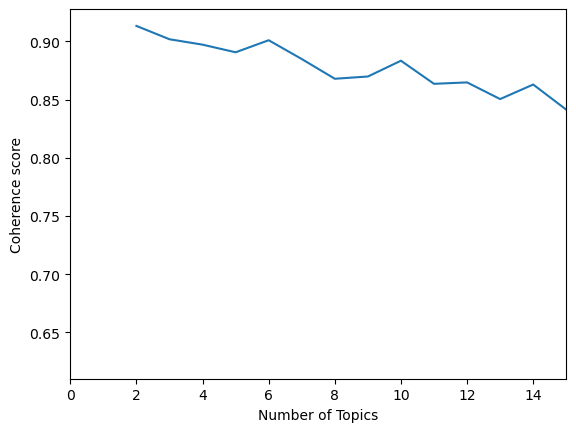

In [23]:
from tqdm import tqdm
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): # 응집도 계산
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values 

def find_optimal_number_of_topics(dictionary, corpus, processed_data): # 토픽갯수별 응집도 그래프
    limit = 50; #토픽 마지막갯수
    start = 2; #토픽 시작갯수
    step = 1; ### 1개씩 해서 돌려보기 
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                            texts=processed_data, start=start, limit=limit, step=step) 
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlim([0, 15]) 
    plt.xlabel("Number of Topics") 
    plt.ylabel("Coherence score")
#     plt.legend(("coherence_values"), loc='best') 
    plt.show() 


processed_data = [sent.strip().split(",") for sent in tqdm(open('./평점별리뷰/review_tokenized0304.csv', 'r', encoding='utf-8').readlines())]
dictionary = corpora.Dictionary(processed_data) 
dictionary.filter_extremes(no_below=10, no_above=0.05) # 출현빈도가 적거나 자주 등장하는 단어는 제거 
corpus = [dictionary.doc2bow(text) for text in processed_data]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
    
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, processed_data)

In [24]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

2023-03-04 16:31:48,159 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-03-04 16:31:48,393 : INFO : adding document #10000 to Dictionary(20397 unique tokens: ['과제', '꿀강의', '들으세요', '쉬움', '시험']...)
2023-03-04 16:31:48,623 : INFO : adding document #20000 to Dictionary(31351 unique tokens: ['과제', '꿀강의', '들으세요', '쉬움', '시험']...)
2023-03-04 16:31:48,642 : INFO : built Dictionary(32176 unique tokens: ['과제', '꿀강의', '들으세요', '쉬움', '시험']...) from 20996 documents (total 490757 corpus positions)
2023-03-04 16:31:48,643 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(32176 unique tokens: ['과제', '꿀강의', '들으세요', '쉬움', '시험']...) from 20996 documents (total 490757 corpus positions)", 'datetime': '2023-03-04T16:31:48.643140', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [39]:
import gensim
NUM_TOPICS = 6
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

2023-03-04 17:14:39,510 : INFO : using symmetric alpha at 0.16666666666666666
2023-03-04 17:14:39,514 : INFO : using symmetric eta at 0.16666666666666666
2023-03-04 17:14:39,523 : INFO : using serial LDA version on this node
2023-03-04 17:14:39,540 : INFO : running online (multi-pass) LDA training, 6 topics, 15 passes over the supplied corpus of 20996 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-04 17:14:39,543 : INFO : PROGRESS: pass 0, at document #2000/20996
2023-03-04 17:14:40,345 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:14:40,350 : INFO : topic #3 (0.167): 0.045*"수업" + 0.016*"교수님" + 0.015*"과제" + 0.013*"강의" + 0.009*"시험" + 0.008*"이해" + 0.007*"설명" + 0.007*"생각" + 0.006*"점수" + 0.006*"문제"
2023-03-04 17:14:40,351 : INFO : topic #1 (0.167): 0.039*"교수님" + 0.024*"수업" + 0.017*"시험" + 0.014*"강의" + 0.008*"과제" + 0.008*"학생" + 0.007*"

2023-03-04 17:14:44,334 : INFO : topic #1 (0.167): 0.044*"교수님" + 0.021*"수업" + 0.012*"어렵지" + 0.012*"시험" + 0.011*"강의" + 0.007*"않게" + 0.006*"않고" + 0.006*"내용" + 0.006*"과제" + 0.006*"좋아요"
2023-03-04 17:14:44,334 : INFO : topic diff=0.400294, rho=0.377964
2023-03-04 17:14:44,335 : INFO : PROGRESS: pass 0, at document #16000/20996
2023-03-04 17:14:44,939 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:14:44,945 : INFO : topic #3 (0.167): 0.049*"수업" + 0.012*"교수님" + 0.011*"과제" + 0.008*"강의" + 0.008*"이해" + 0.007*"좋은" + 0.007*"생각" + 0.006*"열심히" + 0.006*"교양" + 0.006*"추천"
2023-03-04 17:14:44,946 : INFO : topic #1 (0.167): 0.044*"교수님" + 0.019*"수업" + 0.012*"어렵지" + 0.011*"시험" + 0.011*"강의" + 0.007*"않고" + 0.006*"내용" + 0.006*"설명" + 0.005*"않게" + 0.005*"과제"
2023-03-04 17:14:44,946 : INFO : topic #0 (0.167): 0.059*"교수님" + 0.033*"수업" + 0.015*"강의" + 0.012*"시험" + 0.012*"학생" + 0.008*"과목" + 0.008*"설명" + 0.007*"과제" + 0.007*"공부" + 0.006*"주심"
2023-03-04 17:14:44,947 : INFO :

2023-03-04 17:14:48,731 : INFO : topic #5 (0.167): 0.020*"채플" + 0.016*"수업" + 0.015*"교수님" + 0.011*"과목" + 0.010*"대면" + 0.009*"조교" + 0.008*"강연" + 0.008*"비대면" + 0.008*"공연" + 0.007*"좋은"
2023-03-04 17:14:48,731 : INFO : topic diff=0.245515, rho=0.282865
2023-03-04 17:14:48,732 : INFO : PROGRESS: pass 1, at document #8000/20996
2023-03-04 17:14:49,200 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:14:49,206 : INFO : topic #2 (0.167): 0.033*"시험" + 0.026*"과제" + 0.021*"강의" + 0.020*"수업" + 0.018*"교수님" + 0.012*"문제" + 0.010*"부담" + 0.008*"점수" + 0.008*"공부" + 0.008*"열심히"
2023-03-04 17:14:49,207 : INFO : topic #5 (0.167): 0.018*"채플" + 0.017*"수업" + 0.015*"교수님" + 0.009*"과목" + 0.008*"대면" + 0.007*"조교" + 0.007*"공연" + 0.007*"좋은" + 0.006*"강연" + 0.006*"비대면"
2023-03-04 17:14:49,208 : INFO : topic #3 (0.167): 0.044*"수업" + 0.011*"채플" + 0.010*"과제" + 0.009*"교수님" + 0.009*"시간" + 0.008*"비대면" + 0.008*"강의" + 0.007*"좋은" + 0.007*"힐링" + 0.006*"들을"
2023-03-04 17:14:49,209 : INFO : 

2023-03-04 17:14:52,470 : INFO : topic diff=0.255221, rho=0.282865
2023-03-04 17:14:52,738 : INFO : -8.376 per-word bound, 332.3 perplexity estimate based on a held-out corpus of 996 documents with 19663 words
2023-03-04 17:14:52,738 : INFO : PROGRESS: pass 1, at document #20996/20996
2023-03-04 17:14:52,931 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 17:14:52,936 : INFO : topic #2 (0.167): 0.035*"시험" + 0.026*"과제" + 0.019*"수업" + 0.017*"교수님" + 0.016*"강의" + 0.013*"문제" + 0.010*"공부" + 0.010*"점수" + 0.009*"열심히" + 0.008*"학점"
2023-03-04 17:14:52,937 : INFO : topic #5 (0.167): 0.026*"조교" + 0.014*"과목" + 0.013*"수업" + 0.012*"실험" + 0.010*"교수님" + 0.008*"채플" + 0.008*"대면" + 0.006*"좋음" + 0.006*"출석" + 0.005*"시간"
2023-03-04 17:14:52,938 : INFO : topic #1 (0.167): 0.034*"교수님" + 0.010*"수업" + 0.010*"어렵지" + 0.009*"좋아요" + 0.007*"재덕" + 0.007*"않게" + 0.007*"않고" + 0.006*"들으세요" + 0.006*"지루하지" + 0.005*"않아요"
2023-03-04 17:14:52,939 : INFO : topic #0 (0.167): 0.074*"교수님" + 0

2023-03-04 17:14:55,489 : INFO : topic diff=0.258121, rho=0.272186
2023-03-04 17:14:55,490 : INFO : PROGRESS: pass 2, at document #14000/20996
2023-03-04 17:14:55,916 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:14:55,920 : INFO : topic #4 (0.167): 0.036*"교수님" + 0.027*"수업" + 0.022*"학생" + 0.019*"강의" + 0.018*"생각" + 0.010*"설명" + 0.010*"대해" + 0.008*"이해" + 0.006*"내용" + 0.006*"께서"
2023-03-04 17:14:55,921 : INFO : topic #3 (0.167): 0.044*"수업" + 0.014*"교양" + 0.009*"시간" + 0.007*"들을" + 0.007*"강의" + 0.007*"추천" + 0.006*"과제" + 0.006*"사람" + 0.006*"좋은" + 0.005*"느낌"
2023-03-04 17:14:55,922 : INFO : topic #1 (0.167): 0.029*"교수님" + 0.010*"좋아요" + 0.010*"어렵지" + 0.009*"지루하지" + 0.009*"않게" + 0.008*"고전" + 0.007*"않고" + 0.007*"수업" + 0.006*"들으세요" + 0.006*"않아요"
2023-03-04 17:14:55,922 : INFO : topic #2 (0.167): 0.033*"시험" + 0.025*"과제" + 0.021*"수업" + 0.018*"강의" + 0.017*"교수님" + 0.011*"문제" + 0.010*"부담" + 0.009*"내용" + 0.008*"점수" + 0.008*"공부"
2023-03-04 17:14:55,923 : INFO

2023-03-04 17:14:58,884 : INFO : topic diff=0.246063, rho=0.262631
2023-03-04 17:14:58,885 : INFO : PROGRESS: pass 3, at document #6000/20996
2023-03-04 17:14:59,232 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:14:59,237 : INFO : topic #4 (0.167): 0.033*"교수님" + 0.025*"수업" + 0.021*"강의" + 0.020*"학생" + 0.016*"생각" + 0.011*"설명" + 0.011*"이해" + 0.008*"대해" + 0.006*"내용" + 0.006*"노력"
2023-03-04 17:14:59,238 : INFO : topic #2 (0.167): 0.035*"시험" + 0.027*"과제" + 0.019*"수업" + 0.018*"강의" + 0.016*"교수님" + 0.014*"문제" + 0.010*"공부" + 0.009*"점수" + 0.009*"내용" + 0.008*"열심히"
2023-03-04 17:14:59,238 : INFO : topic #1 (0.167): 0.023*"회계" + 0.021*"교수님" + 0.011*"들으세요" + 0.008*"좋아요" + 0.007*"지루하지" + 0.007*"준용" + 0.007*"어렵지" + 0.006*"않고" + 0.006*"않게" + 0.005*"그저"
2023-03-04 17:14:59,239 : INFO : topic #3 (0.167): 0.039*"수업" + 0.011*"시간" + 0.008*"이다" + 0.007*"들을" + 0.007*"힐링" + 0.006*"추천" + 0.006*"과제" + 0.006*"강의" + 0.006*"듣기" + 0.006*"회계"
2023-03-04 17:14:59,240 : INFO 

2023-03-04 17:15:02,053 : INFO : PROGRESS: pass 3, at document #20000/20996
2023-03-04 17:15:02,413 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:02,418 : INFO : topic #0 (0.167): 0.085*"교수님" + 0.041*"수업" + 0.025*"강의" + 0.014*"학생" + 0.011*"최고" + 0.010*"설명" + 0.009*"주심" + 0.009*"열심히" + 0.009*"영어" + 0.008*"학점"
2023-03-04 17:15:02,419 : INFO : topic #1 (0.167): 0.016*"교수님" + 0.009*"지루하지" + 0.009*"들으세요" + 0.007*"혜영" + 0.006*"좋아요" + 0.006*"않고" + 0.006*"그저" + 0.005*"않게" + 0.005*"고전" + 0.005*"만족"
2023-03-04 17:15:02,420 : INFO : topic #2 (0.167): 0.034*"시험" + 0.027*"과제" + 0.020*"수업" + 0.017*"교수님" + 0.014*"강의" + 0.012*"문제" + 0.010*"점수" + 0.010*"공부" + 0.008*"열심히" + 0.008*"내용"
2023-03-04 17:15:02,421 : INFO : topic #5 (0.167): 0.021*"채플" + 0.015*"과목" + 0.015*"대면" + 0.015*"비대면" + 0.009*"온라인" + 0.007*"힐링" + 0.007*"좋음" + 0.007*"시간" + 0.007*"개꿀" + 0.007*"공연"
2023-03-04 17:15:02,422 : INFO : topic #4 (0.167): 0.033*"교수님" + 0.025*"수업" + 0.021*"학생" + 0.01

2023-03-04 17:15:04,688 : INFO : PROGRESS: pass 4, at document #12000/20996
2023-03-04 17:15:05,060 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:05,065 : INFO : topic #4 (0.167): 0.031*"교수님" + 0.027*"수업" + 0.021*"학생" + 0.020*"강의" + 0.019*"생각" + 0.011*"대해" + 0.009*"설명" + 0.008*"이해" + 0.006*"내용" + 0.006*"관심"
2023-03-04 17:15:05,066 : INFO : topic #2 (0.167): 0.033*"시험" + 0.026*"과제" + 0.021*"수업" + 0.017*"교수님" + 0.016*"강의" + 0.011*"문제" + 0.010*"부담" + 0.009*"점수" + 0.009*"내용" + 0.008*"공부"
2023-03-04 17:15:05,066 : INFO : topic #3 (0.167): 0.037*"수업" + 0.014*"교양" + 0.010*"시간" + 0.007*"이다" + 0.007*"들을" + 0.006*"사람" + 0.006*"추천" + 0.006*"느낌" + 0.005*"재밌음" + 0.005*"보면"
2023-03-04 17:15:05,067 : INFO : topic #5 (0.167): 0.026*"채플" + 0.015*"비대면" + 0.014*"대면" + 0.011*"힐링" + 0.011*"과목" + 0.010*"온라인" + 0.009*"패논패" + 0.008*"시간" + 0.008*"공연" + 0.007*"노래"
2023-03-04 17:15:05,068 : INFO : topic #0 (0.167): 0.087*"교수님" + 0.044*"수업" + 0.027*"강의" + 0.016*"학생"

2023-03-04 17:15:07,786 : INFO : topic diff=0.208645, rho=0.246198
2023-03-04 17:15:07,786 : INFO : PROGRESS: pass 5, at document #4000/20996
2023-03-04 17:15:08,149 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:08,154 : INFO : topic #4 (0.167): 0.030*"교수님" + 0.025*"수업" + 0.022*"강의" + 0.020*"학생" + 0.018*"생각" + 0.011*"이해" + 0.010*"설명" + 0.009*"대해" + 0.007*"내용" + 0.005*"부분"
2023-03-04 17:15:08,155 : INFO : topic #1 (0.167): 0.034*"회계" + 0.010*"준용" + 0.010*"지루하지" + 0.009*"들으세요" + 0.008*"교수님" + 0.006*"원리" + 0.006*"가르치시고" + 0.005*"재덕" + 0.005*"만족" + 0.005*"그저"
2023-03-04 17:15:08,155 : INFO : topic #3 (0.167): 0.037*"수업" + 0.008*"시간" + 0.008*"회계" + 0.008*"이다" + 0.007*"교양" + 0.007*"화학" + 0.006*"추천" + 0.006*"사람" + 0.006*"보면" + 0.006*"재밌음"
2023-03-04 17:15:08,156 : INFO : topic #5 (0.167): 0.019*"조교" + 0.015*"과목" + 0.011*"대면" + 0.010*"채플" + 0.010*"비대면" + 0.009*"실험" + 0.007*"온라인" + 0.007*"개꿀" + 0.007*"시간" + 0.006*"좋음"
2023-03-04 17:15:08,157 : INF

2023-03-04 17:15:10,640 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:10,645 : INFO : topic #1 (0.167): 0.010*"지루하지" + 0.009*"들으세요" + 0.006*"고전" + 0.006*"만족" + 0.005*"그저" + 0.005*"회계" + 0.005*"교수님" + 0.005*"가르치시고" + 0.004*"좋아요" + 0.004*"윤리"
2023-03-04 17:15:10,645 : INFO : topic #0 (0.167): 0.086*"교수님" + 0.042*"수업" + 0.028*"강의" + 0.016*"학생" + 0.012*"설명" + 0.011*"최고" + 0.009*"열심히" + 0.008*"주심" + 0.007*"질문" + 0.007*"열정"
2023-03-04 17:15:10,646 : INFO : topic #2 (0.167): 0.034*"시험" + 0.027*"과제" + 0.020*"수업" + 0.016*"교수님" + 0.015*"강의" + 0.013*"문제" + 0.011*"공부" + 0.009*"점수" + 0.009*"내용" + 0.008*"열심히"
2023-03-04 17:15:10,647 : INFO : topic #3 (0.167): 0.033*"수업" + 0.010*"교양" + 0.010*"시간" + 0.008*"이다" + 0.006*"보면" + 0.006*"사람" + 0.006*"재밌음" + 0.006*"추천" + 0.005*"느낌" + 0.005*"들을"
2023-03-04 17:15:10,648 : INFO : topic #5 (0.167): 0.028*"채플" + 0.019*"비대면" + 0.017*"대면" + 0.016*"과목" + 0.013*"온라인" + 0.010*"힐링" + 0.009*"개꿀" + 0.009*"공연" + 0.008*"시간" +

2023-03-04 17:15:13,264 : INFO : topic diff=0.183874, rho=0.239059
2023-03-04 17:15:13,264 : INFO : PROGRESS: pass 6, at document #10000/20996
2023-03-04 17:15:13,615 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:13,620 : INFO : topic #5 (0.167): 0.033*"채플" + 0.018*"비대면" + 0.016*"힐링" + 0.016*"대면" + 0.013*"온라인" + 0.011*"과목" + 0.010*"공연" + 0.010*"노래" + 0.010*"시간" + 0.009*"좋아요"
2023-03-04 17:15:13,621 : INFO : topic #1 (0.167): 0.017*"회계" + 0.011*"지루하지" + 0.011*"윤리" + 0.009*"들으세요" + 0.008*"대경" + 0.006*"그저" + 0.006*"유쾌하시고" + 0.006*"만족" + 0.005*"준용" + 0.004*"좋아요"
2023-03-04 17:15:13,622 : INFO : topic #0 (0.167): 0.092*"교수님" + 0.044*"수업" + 0.027*"강의" + 0.018*"학생" + 0.015*"영어" + 0.011*"최고" + 0.011*"설명" + 0.008*"주심" + 0.008*"열심히" + 0.008*"배려"
2023-03-04 17:15:13,622 : INFO : topic #4 (0.167): 0.028*"교수님" + 0.026*"수업" + 0.020*"강의" + 0.020*"학생" + 0.018*"생각" + 0.010*"대해" + 0.008*"이해" + 0.008*"설명" + 0.007*"내용" + 0.005*"노력"
2023-03-04 17:15:13,623 : 

2023-03-04 17:15:16,242 : INFO : topic diff=0.150408, rho=0.239059
2023-03-04 17:15:16,243 : INFO : PROGRESS: pass 7, at document #2000/20996
2023-03-04 17:15:16,598 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:16,603 : INFO : topic #5 (0.167): 0.022*"조교" + 0.015*"과목" + 0.014*"채플" + 0.013*"대면" + 0.012*"비대면" + 0.011*"실험" + 0.009*"개꿀" + 0.009*"온라인" + 0.007*"시간" + 0.007*"패논패"
2023-03-04 17:15:16,603 : INFO : topic #2 (0.167): 0.036*"시험" + 0.026*"과제" + 0.021*"수업" + 0.016*"교수님" + 0.014*"강의" + 0.013*"문제" + 0.011*"공부" + 0.010*"점수" + 0.008*"열심히" + 0.008*"내용"
2023-03-04 17:15:16,605 : INFO : topic #3 (0.167): 0.032*"수업" + 0.009*"화학" + 0.009*"교양" + 0.008*"시간" + 0.008*"이다" + 0.006*"사람" + 0.006*"재밌음" + 0.006*"보면" + 0.005*"추천" + 0.005*"처음"
2023-03-04 17:15:16,606 : INFO : topic #4 (0.167): 0.027*"교수님" + 0.025*"수업" + 0.020*"강의" + 0.019*"학생" + 0.018*"생각" + 0.011*"대해" + 0.009*"이해" + 0.008*"설명" + 0.007*"내용" + 0.006*"관심"
2023-03-04 17:15:16,607 : INFO : t

2023-03-04 17:15:19,170 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:19,175 : INFO : topic #3 (0.167): 0.030*"수업" + 0.012*"교양" + 0.008*"시간" + 0.007*"이다" + 0.007*"재밌음" + 0.006*"보면" + 0.006*"사람" + 0.005*"일본어" + 0.005*"추천" + 0.005*"느낌"
2023-03-04 17:15:19,176 : INFO : topic #2 (0.167): 0.035*"시험" + 0.025*"과제" + 0.021*"수업" + 0.016*"교수님" + 0.015*"강의" + 0.012*"문제" + 0.011*"공부" + 0.009*"점수" + 0.009*"내용" + 0.008*"열심히"
2023-03-04 17:15:19,176 : INFO : topic #0 (0.167): 0.089*"교수님" + 0.045*"수업" + 0.028*"강의" + 0.018*"학생" + 0.013*"설명" + 0.011*"최고" + 0.009*"열심히" + 0.009*"주심" + 0.008*"영어" + 0.007*"추천"
2023-03-04 17:15:19,177 : INFO : topic #5 (0.167): 0.017*"채플" + 0.014*"과목" + 0.013*"대면" + 0.013*"비대면" + 0.010*"힐링" + 0.009*"온라인" + 0.008*"개꿀" + 0.008*"시간" + 0.008*"조교" + 0.008*"패논패"
2023-03-04 17:15:19,177 : INFO : topic #4 (0.167): 0.026*"수업" + 0.026*"교수님" + 0.021*"강의" + 0.019*"생각" + 0.017*"학생" + 0.011*"대해" + 0.009*"이해" + 0.008*"설명" + 0.008*"내용" + 0.007

2023-03-04 17:15:21,681 : INFO : topic diff=0.184152, rho=0.226467
2023-03-04 17:15:21,682 : INFO : PROGRESS: pass 8, at document #8000/20996
2023-03-04 17:15:22,007 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:22,012 : INFO : topic #3 (0.167): 0.029*"수업" + 0.009*"시간" + 0.008*"이다" + 0.007*"재밌음" + 0.007*"교양" + 0.006*"느낌" + 0.006*"보면" + 0.005*"사람" + 0.005*"회계" + 0.005*"화학"
2023-03-04 17:15:22,013 : INFO : topic #4 (0.167): 0.025*"교수님" + 0.025*"수업" + 0.021*"강의" + 0.018*"생각" + 0.018*"학생" + 0.010*"대해" + 0.008*"이해" + 0.007*"설명" + 0.007*"내용" + 0.005*"도움"
2023-03-04 17:15:22,013 : INFO : topic #5 (0.167): 0.039*"채플" + 0.020*"비대면" + 0.018*"힐링" + 0.017*"대면" + 0.014*"온라인" + 0.012*"공연" + 0.012*"노래" + 0.012*"과목" + 0.010*"시간" + 0.010*"좋아요"
2023-03-04 17:15:22,014 : INFO : topic #2 (0.167): 0.035*"시험" + 0.027*"과제" + 0.021*"수업" + 0.016*"교수님" + 0.015*"강의" + 0.012*"문제" + 0.010*"공부" + 0.009*"점수" + 0.008*"내용" + 0.008*"열심히"
2023-03-04 17:15:22,015 : INFO : t

2023-03-04 17:15:24,498 : INFO : topic diff=0.172433, rho=0.226467
2023-03-04 17:15:24,715 : INFO : -8.170 per-word bound, 288.0 perplexity estimate based on a held-out corpus of 996 documents with 19663 words
2023-03-04 17:15:24,716 : INFO : PROGRESS: pass 8, at document #20996/20996
2023-03-04 17:15:24,866 : INFO : merging changes from 996 documents into a model of 20996 documents
2023-03-04 17:15:24,871 : INFO : topic #3 (0.167): 0.025*"수업" + 0.012*"화학" + 0.010*"교양" + 0.009*"시간" + 0.009*"이다" + 0.006*"재밌음" + 0.006*"사람" + 0.006*"보면" + 0.005*"느낌" + 0.005*"처음"
2023-03-04 17:15:24,872 : INFO : topic #1 (0.167): 0.010*"지루하지" + 0.009*"재덕" + 0.007*"가르치시고" + 0.006*"들으세요" + 0.005*"혜영" + 0.005*"만족" + 0.005*"그저" + 0.005*"고전" + 0.005*"유쾌하시고" + 0.004*"회계"
2023-03-04 17:15:24,873 : INFO : topic #4 (0.167): 0.024*"수업" + 0.024*"교수님" + 0.021*"강의" + 0.019*"생각" + 0.017*"학생" + 0.011*"대해" + 0.009*"이해" + 0.008*"설명" + 0.007*"내용" + 0.007*"관심"
2023-03-04 17:15:24,873 : INFO : topic #5 (0.167): 0.026*"조교" + 0

2023-03-04 17:15:26,908 : INFO : topic diff=0.192435, rho=0.220874
2023-03-04 17:15:26,909 : INFO : PROGRESS: pass 9, at document #14000/20996
2023-03-04 17:15:27,256 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:27,261 : INFO : topic #2 (0.167): 0.034*"시험" + 0.026*"과제" + 0.022*"수업" + 0.017*"교수님" + 0.015*"강의" + 0.011*"문제" + 0.009*"공부" + 0.009*"점수" + 0.009*"내용" + 0.009*"부담"
2023-03-04 17:15:27,262 : INFO : topic #0 (0.167): 0.089*"교수님" + 0.047*"수업" + 0.028*"강의" + 0.019*"학생" + 0.012*"설명" + 0.011*"최고" + 0.010*"영어" + 0.008*"열심히" + 0.008*"주심" + 0.008*"배려"
2023-03-04 17:15:27,262 : INFO : topic #5 (0.167): 0.022*"채플" + 0.016*"비대면" + 0.015*"대면" + 0.015*"힐링" + 0.011*"온라인" + 0.011*"과목" + 0.010*"부담" + 0.009*"시간" + 0.009*"패논패" + 0.009*"개꿀"
2023-03-04 17:15:27,263 : INFO : topic #4 (0.167): 0.027*"수업" + 0.024*"교수님" + 0.023*"강의" + 0.020*"생각" + 0.016*"학생" + 0.012*"대해" + 0.008*"관심" + 0.008*"내용" + 0.007*"이해" + 0.007*"설명"
2023-03-04 17:15:27,264 : INFO : 

2023-03-04 17:15:29,765 : INFO : topic diff=0.189954, rho=0.215676
2023-03-04 17:15:29,766 : INFO : PROGRESS: pass 10, at document #6000/20996
2023-03-04 17:15:30,066 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:30,071 : INFO : topic #2 (0.167): 0.036*"시험" + 0.027*"과제" + 0.020*"수업" + 0.016*"강의" + 0.016*"교수님" + 0.014*"문제" + 0.011*"공부" + 0.009*"점수" + 0.008*"내용" + 0.008*"열심히"
2023-03-04 17:15:30,072 : INFO : topic #4 (0.167): 0.025*"수업" + 0.023*"강의" + 0.023*"교수님" + 0.018*"생각" + 0.015*"학생" + 0.010*"대해" + 0.009*"이해" + 0.008*"내용" + 0.007*"설명" + 0.006*"관심"
2023-03-04 17:15:30,072 : INFO : topic #5 (0.167): 0.042*"채플" + 0.023*"비대면" + 0.020*"힐링" + 0.019*"대면" + 0.016*"온라인" + 0.013*"과목" + 0.013*"노래" + 0.012*"공연" + 0.011*"조교" + 0.010*"시간"
2023-03-04 17:15:30,073 : INFO : topic #1 (0.167): 0.030*"회계" + 0.009*"지루하지" + 0.008*"준용" + 0.007*"들으세요" + 0.006*"원리" + 0.005*"만족" + 0.005*"그저" + 0.005*"가르치시고" + 0.004*"광고" + 0.004*"했으면"
2023-03-04 17:15:30,073 : I

2023-03-04 17:15:32,524 : INFO : PROGRESS: pass 10, at document #20000/20996
2023-03-04 17:15:32,837 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:32,842 : INFO : topic #2 (0.167): 0.034*"시험" + 0.027*"과제" + 0.020*"수업" + 0.016*"교수님" + 0.013*"강의" + 0.012*"문제" + 0.010*"점수" + 0.010*"공부" + 0.008*"열심히" + 0.008*"내용"
2023-03-04 17:15:32,843 : INFO : topic #1 (0.167): 0.011*"지루하지" + 0.006*"혜영" + 0.006*"고전" + 0.006*"회계" + 0.005*"만족" + 0.005*"들으세요" + 0.005*"그저" + 0.005*"가르치시고" + 0.005*"유쾌하시고" + 0.004*"재덕"
2023-03-04 17:15:32,843 : INFO : topic #3 (0.167): 0.022*"수업" + 0.010*"교양" + 0.008*"시간" + 0.008*"재밌음" + 0.007*"이다" + 0.006*"보면" + 0.005*"사람" + 0.005*"가볍게" + 0.005*"느낌" + 0.004*"듣다"
2023-03-04 17:15:32,844 : INFO : topic #5 (0.167): 0.023*"채플" + 0.018*"비대면" + 0.017*"대면" + 0.015*"과목" + 0.012*"힐링" + 0.012*"온라인" + 0.010*"개꿀" + 0.009*"시간" + 0.008*"부담" + 0.008*"노래"
2023-03-04 17:15:32,845 : INFO : topic #4 (0.167): 0.025*"수업" + 0.023*"교수님" + 0.021*"강의" +

2023-03-04 17:15:34,868 : INFO : PROGRESS: pass 11, at document #12000/20996
2023-03-04 17:15:35,200 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:35,205 : INFO : topic #2 (0.167): 0.034*"시험" + 0.026*"과제" + 0.022*"수업" + 0.016*"교수님" + 0.015*"강의" + 0.011*"문제" + 0.010*"점수" + 0.009*"공부" + 0.009*"부담" + 0.008*"내용"
2023-03-04 17:15:35,206 : INFO : topic #3 (0.167): 0.024*"수업" + 0.011*"교양" + 0.008*"시간" + 0.007*"재밌음" + 0.007*"이다" + 0.006*"느낌" + 0.005*"사람" + 0.005*"스피킹" + 0.005*"가볍게" + 0.005*"보면"
2023-03-04 17:15:35,206 : INFO : topic #0 (0.167): 0.090*"교수님" + 0.045*"수업" + 0.027*"강의" + 0.020*"학생" + 0.013*"영어" + 0.012*"설명" + 0.011*"최고" + 0.008*"배려" + 0.008*"주심" + 0.008*"친절하시고"
2023-03-04 17:15:35,207 : INFO : topic #5 (0.167): 0.027*"채플" + 0.017*"힐링" + 0.017*"비대면" + 0.016*"대면" + 0.011*"온라인" + 0.011*"과목" + 0.011*"부담" + 0.010*"시간" + 0.010*"들을" + 0.009*"개꿀"
2023-03-04 17:15:35,207 : INFO : topic #4 (0.167): 0.027*"수업" + 0.023*"교수님" + 0.022*"강의" + 0.020

2023-03-04 17:15:37,676 : INFO : topic diff=0.162955, rho=0.206293
2023-03-04 17:15:37,677 : INFO : PROGRESS: pass 12, at document #4000/20996
2023-03-04 17:15:38,010 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:38,016 : INFO : topic #1 (0.167): 0.034*"회계" + 0.011*"지루하지" + 0.009*"준용" + 0.007*"원리" + 0.006*"가르치시고" + 0.005*"광고" + 0.005*"만족" + 0.005*"재덕" + 0.005*"들으세요" + 0.004*"그저"
2023-03-04 17:15:38,016 : INFO : topic #3 (0.167): 0.023*"수업" + 0.008*"화학" + 0.007*"재밌음" + 0.007*"이다" + 0.007*"시간" + 0.006*"회계" + 0.006*"교양" + 0.006*"보면" + 0.005*"사람" + 0.005*"응용"
2023-03-04 17:15:38,017 : INFO : topic #0 (0.167): 0.089*"교수님" + 0.044*"수업" + 0.030*"강의" + 0.018*"학생" + 0.015*"설명" + 0.010*"최고" + 0.010*"주심" + 0.009*"열심히" + 0.008*"열정" + 0.007*"학점"
2023-03-04 17:15:38,018 : INFO : topic #5 (0.167): 0.018*"조교" + 0.014*"과목" + 0.013*"대면" + 0.013*"채플" + 0.012*"비대면" + 0.010*"개꿀" + 0.009*"실험" + 0.009*"온라인" + 0.008*"시간" + 0.008*"힐링"
2023-03-04 17:15:38,019 : IN

2023-03-04 17:15:40,286 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:40,291 : INFO : topic #0 (0.167): 0.088*"교수님" + 0.043*"수업" + 0.027*"강의" + 0.019*"학생" + 0.014*"설명" + 0.011*"최고" + 0.009*"주심" + 0.008*"열심히" + 0.008*"영어" + 0.007*"열정"
2023-03-04 17:15:40,292 : INFO : topic #2 (0.167): 0.034*"시험" + 0.027*"과제" + 0.021*"수업" + 0.016*"교수님" + 0.014*"강의" + 0.013*"문제" + 0.011*"공부" + 0.009*"점수" + 0.008*"내용" + 0.008*"열심히"
2023-03-04 17:15:40,293 : INFO : topic #1 (0.167): 0.011*"지루하지" + 0.008*"회계" + 0.006*"고전" + 0.006*"만족" + 0.005*"그저" + 0.005*"가르치시고" + 0.004*"들으세요" + 0.004*"윤리" + 0.004*"유쾌하시고" + 0.004*"했으면"
2023-03-04 17:15:40,294 : INFO : topic #3 (0.167): 0.021*"수업" + 0.008*"교양" + 0.008*"시간" + 0.007*"재밌음" + 0.007*"이다" + 0.006*"보면" + 0.005*"느낌" + 0.005*"사람" + 0.005*"가볍게" + 0.005*"응용"
2023-03-04 17:15:40,295 : INFO : topic #5 (0.167): 0.027*"채플" + 0.019*"비대면" + 0.018*"대면" + 0.015*"과목" + 0.014*"힐링" + 0.013*"온라인" + 0.011*"개꿀" + 0.010*"시간" + 0.009*"노래

2023-03-04 17:15:42,744 : INFO : topic diff=0.145736, rho=0.202039
2023-03-04 17:15:42,744 : INFO : PROGRESS: pass 13, at document #10000/20996
2023-03-04 17:15:43,063 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:43,068 : INFO : topic #3 (0.167): 0.021*"수업" + 0.008*"시간" + 0.008*"재밌음" + 0.007*"이다" + 0.007*"교양" + 0.006*"스피킹" + 0.006*"보면" + 0.006*"느낌" + 0.005*"듣다" + 0.005*"사람"
2023-03-04 17:15:43,069 : INFO : topic #2 (0.167): 0.035*"시험" + 0.027*"과제" + 0.021*"수업" + 0.017*"교수님" + 0.014*"강의" + 0.012*"문제" + 0.009*"점수" + 0.009*"공부" + 0.008*"열심히" + 0.008*"부담"
2023-03-04 17:15:43,070 : INFO : topic #1 (0.167): 0.020*"회계" + 0.011*"지루하지" + 0.010*"윤리" + 0.008*"대경" + 0.006*"그저" + 0.006*"만족" + 0.006*"유쾌하시고" + 0.005*"준용" + 0.005*"들으세요" + 0.004*"원리"
2023-03-04 17:15:43,070 : INFO : topic #4 (0.167): 0.026*"수업" + 0.022*"교수님" + 0.022*"강의" + 0.019*"생각" + 0.015*"학생" + 0.011*"대해" + 0.008*"내용" + 0.007*"이해" + 0.006*"관심" + 0.006*"설명"
2023-03-04 17:15:43,071 : I

2023-03-04 17:15:45,578 : INFO : topic #0 (0.167): 0.089*"교수님" + 0.043*"수업" + 0.024*"강의" + 0.019*"학생" + 0.014*"설명" + 0.011*"주심" + 0.010*"최고" + 0.009*"영어" + 0.009*"열심히" + 0.009*"열정"
2023-03-04 17:15:45,578 : INFO : topic diff=0.113109, rho=0.202039
2023-03-04 17:15:45,579 : INFO : PROGRESS: pass 14, at document #2000/20996
2023-03-04 17:15:45,919 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:45,925 : INFO : topic #3 (0.167): 0.021*"수업" + 0.009*"화학" + 0.007*"재밌음" + 0.007*"이다" + 0.007*"교양" + 0.007*"시간" + 0.005*"보면" + 0.005*"사람" + 0.004*"일본어" + 0.004*"느낌"
2023-03-04 17:15:45,925 : INFO : topic #4 (0.167): 0.026*"수업" + 0.022*"교수님" + 0.022*"강의" + 0.019*"생각" + 0.015*"학생" + 0.011*"대해" + 0.008*"이해" + 0.008*"내용" + 0.007*"관심" + 0.006*"설명"
2023-03-04 17:15:45,926 : INFO : topic #0 (0.167): 0.090*"교수님" + 0.045*"수업" + 0.025*"강의" + 0.020*"학생" + 0.014*"설명" + 0.010*"최고" + 0.010*"주심" + 0.009*"열심히" + 0.009*"영어" + 0.008*"열정"
2023-03-04 17:15:45,927 : INFO : 

2023-03-04 17:15:47,982 : INFO : topic diff=0.153216, rho=0.198037
2023-03-04 17:15:47,983 : INFO : PROGRESS: pass 14, at document #16000/20996
2023-03-04 17:15:48,325 : INFO : merging changes from 2000 documents into a model of 20996 documents
2023-03-04 17:15:48,331 : INFO : topic #1 (0.167): 0.011*"지루하지" + 0.010*"회계" + 0.008*"고전" + 0.007*"만족" + 0.006*"그저" + 0.005*"윤리" + 0.005*"유쾌하시고" + 0.004*"가르치시고" + 0.004*"대경" + 0.004*"들으세요"
2023-03-04 17:15:48,332 : INFO : topic #5 (0.167): 0.019*"채플" + 0.014*"대면" + 0.014*"비대면" + 0.013*"과목" + 0.013*"힐링" + 0.010*"온라인" + 0.009*"개꿀" + 0.009*"부담" + 0.009*"시간" + 0.008*"들을"
2023-03-04 17:15:48,333 : INFO : topic #3 (0.167): 0.020*"수업" + 0.009*"교양" + 0.007*"재밌음" + 0.007*"시간" + 0.006*"이다" + 0.006*"보면" + 0.006*"일본어" + 0.005*"가볍게" + 0.005*"듣다" + 0.005*"중국어"
2023-03-04 17:15:48,334 : INFO : topic #0 (0.167): 0.089*"교수님" + 0.045*"수업" + 0.027*"강의" + 0.020*"학생" + 0.014*"설명" + 0.010*"최고" + 0.009*"영어" + 0.009*"주심" + 0.008*"열심히" + 0.007*"배려"
2023-03-04 17:15:48,3

(0, '0.089*"교수님" + 0.043*"수업" + 0.024*"강의" + 0.020*"학생" + 0.014*"설명" + 0.011*"주심" + 0.010*"최고" + 0.010*"영어" + 0.009*"열심히" + 0.009*"열정"')
(1, '0.010*"지루하지" + 0.008*"재덕" + 0.007*"가르치시고" + 0.006*"회계" + 0.005*"그저" + 0.005*"만족" + 0.005*"혜영" + 0.005*"고전" + 0.005*"유쾌하시고" + 0.004*"들으세요"')
(2, '0.035*"시험" + 0.027*"과제" + 0.020*"수업" + 0.016*"교수님" + 0.013*"강의" + 0.013*"문제" + 0.011*"공부" + 0.010*"점수" + 0.009*"열심히" + 0.008*"학점"')
(3, '0.018*"수업" + 0.012*"화학" + 0.008*"교양" + 0.008*"이다" + 0.008*"시간" + 0.007*"재밌음" + 0.006*"보면" + 0.005*"가볍게" + 0.004*"사람" + 0.004*"느낌"')
(4, '0.026*"수업" + 0.022*"강의" + 0.021*"교수님" + 0.019*"생각" + 0.014*"학생" + 0.011*"대해" + 0.008*"이해" + 0.007*"내용" + 0.007*"관심" + 0.006*"과목"')
(5, '0.024*"조교" + 0.018*"채플" + 0.015*"과목" + 0.014*"대면" + 0.014*"비대면" + 0.012*"실험" + 0.011*"힐링" + 0.010*"개꿀" + 0.010*"온라인" + 0.009*"시간"')


In [40]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [41]:
pyLDAvis.save_html(vis, '토픽모델링 5점결과6개버전0304.html')

In [42]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [43]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_8092/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_8092/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)


,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,2,0.6787,"[(0, 0.2092365), (1, 0.028126212), (2, 0.67872..."
1,1,0,0.3797,"[(0, 0.37968764), (1, 0.02085129), (2, 0.23523..."
2,2,2,0.8452,"[(0, 0.0128727), (1, 0.012848095), (2, 0.84517..."
3,3,2,0.5399,"[(0, 0.021102834), (1, 0.020983167), (2, 0.539..."
4,4,2,0.5180,"[(0, 0.01526338), (1, 0.0151656335), (2, 0.518..."
5,5,2,0.9747,"[(2, 0.97467554)]"
6,6,2,0.7033,"[(0, 0.014042471), (1, 0.013998812), (2, 0.703..."
7,7,2,0.7226,"[(2, 0.72259545), (4, 0.16352613), (5, 0.08416..."
8,8,2,0.9476,"[(0, 0.010488113), (1, 0.010420669), (2, 0.947..."
9,9,2,0.7384,"[(2, 0.7383759), (4, 0.22473541)]"


In [44]:
topictable['가장 비중이 높은 토픽'] = topictable['가장 비중이 높은 토픽'] + 1
topictable.head(10)

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,3,0.6787,"[(0, 0.2092365), (1, 0.028126212), (2, 0.67872..."
1,1,1,0.3797,"[(0, 0.37968764), (1, 0.02085129), (2, 0.23523..."
2,2,3,0.8452,"[(0, 0.0128727), (1, 0.012848095), (2, 0.84517..."
3,3,3,0.5399,"[(0, 0.021102834), (1, 0.020983167), (2, 0.539..."
4,4,3,0.5180,"[(0, 0.01526338), (1, 0.0151656335), (2, 0.518..."
5,5,3,0.9747,"[(2, 0.97467554)]"
6,6,3,0.7033,"[(0, 0.014042471), (1, 0.013998812), (2, 0.703..."
7,7,3,0.7226,"[(2, 0.72259545), (4, 0.16352613), (5, 0.08416..."
8,8,3,0.9476,"[(0, 0.010488113), (1, 0.010420669), (2, 0.947..."
9,9,3,0.7384,"[(2, 0.7383759), (4, 0.22473541)]"


In [45]:
# 토픽 번호를 첨부함으로서 어떤 주제인지 찾을 수 있게 분류
df['토픽 번호'] = topictable['가장 비중이 높은 토픽']
df['토픽 비중'] = topictable['가장 높은 토픽의 비중']
df.head()

,개정형태소,토픽 번호,토픽 비중,원본리뷰
0,"역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움",3,0.6787,역시 꿀강의 꼭 들으세요 시험도 과제도 쉬움
1,"진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니다...",1,0.3797,진짜 꼭 들으시기를 추천합니다 배우는 것도 많고 편합니다 추천해요
2,"kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다, ...",3,0.8452,kcu면 말 다했다고 봄 퀴즈5번 과제1번 둘 다 매우 쉬움 시험은 기말 한 번 꿀...
3,"학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯",3,0.5399,학점 편하게 따기에 좋음 근데 족보는 있어야 편할듯
4,"그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, 교...",3,0.5180,그냥 kcu 강의는 꿀강의다 아무리 할게 많아봤자 다른 교양보다 쉽다


In [46]:
data = pd.read_csv('./평점별리뷰/5점리뷰.csv')
data.head()

,강의명,학점,강좌유형,패논패여부,이수학년,전공여부,학과,교수명,리뷰,작성시점,평가별점수,공감수,캠퍼스,강의명길이,리뷰길이,리뷰_형태소_tuple,리뷰_형태소_list,리뷰_형태소_only_N,개정형태소
0,기업가정신과창업 KCU,3,이론,x,전학년,교양,교양,김한수,역시 꿀강의 꼭 들으세요 시험도 과제도 쉬움,22년 2학기 수강자,5,0,인문,13,24,"[('역시', 'Noun'), ('꿀', 'Noun'), ('강의', 'Noun')...","['역시', '꿀', '강의', '꼭', '들으세요', '시험', '도', '과제'...","['역시', '꿀', '강의', '꼭', '시험', '과제', '쉬움']","역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움"
1,기업가정신과창업 KCU,3,이론,x,전학년,교양,교양,김한수,진짜 꼭 들으시기를 추천합니다 배우는 것도 많고 편합니다 추천해요,22년 2학기 수강자,5,0,인문,13,36,"[('진짜', 'Noun'), ('꼭', 'Noun'), ('들으', 'Verb')...","['진짜', '꼭', '들으', '시기', '를', '추천', '합니다', '배우는...","['진짜', '꼭', '시기', '추천', '것', '추천']","진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니다..."
2,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,kcu면 말 다했다고 봄 퀴즈5번 과제1번 둘 다 매우 쉬움 시험은 기말 한 번 꿀...,22년 2학기 수강자,5,0,인문,10,62,"[('kcu', 'Alpha'), ('면', 'Noun'), ('말', 'Noun'...","['kcu', '면', '말', '다', '했다고', '봄', '퀴즈', '5', ...","['면', '말', '봄', '퀴즈', '번', '과제', '번', '둘', '매우...","kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다, ..."
3,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,학점 편하게 따기에 좋음 근데 족보는 있어야 편할듯,22년 2학기 수강자,5,0,인문,10,28,"[('학점', 'Noun'), ('편하게', 'Adjective'), ('따기에',...","['학점', '편하게', '따기에', '좋음', '근데', '족보', '는', '있...","['학점', '족보']","학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯"
4,환경과웰빙 KCU,3,이론,x,전학년,교양,교양,김한수,그냥 kcu 강의는 꿀강의다 아무리 할게 많아봤자 다른 교양보다 쉽다,22년 2학기 수강자,5,0,인문,10,39,"[('그냥', 'Noun'), ('kcu', 'Alpha'), ('강의', 'Nou...","['그냥', 'kcu', '강의', '는', '꿀', '강의', '다', '아무리'...","['그냥', '강의', '꿀', '강의', '다른', '교양']","그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, 교..."


In [47]:
df['원본리뷰'] = data['리뷰']
df.head()

,개정형태소,토픽 번호,토픽 비중,원본리뷰
0,"역시, 꿀강의, 꼭, 들으세요, 시험, 도, 과제, 도, 쉬움",3,0.6787,역시 꿀강의 꼭 들으세요 시험도 과제도 쉬움
1,"진짜, 꼭, 들으, 시기, 를, 추천, 합니다, 배우는, 것, 도, 많고, 편합니다...",1,0.3797,진짜 꼭 들으시기를 추천합니다 배우는 것도 많고 편합니다 추천해요
2,"kcu, 면, 말, 다, 했다고, 봄, 퀴즈, 5, 번, 과제, 1번, 둘, 다, ...",3,0.8452,kcu면 말 다했다고 봄 퀴즈5번 과제1번 둘 다 매우 쉬움 시험은 기말 한 번 꿀...
3,"학점, 편하게, 따기에, 좋음, 근데, 족보, 는, 있어야, 편할듯",3,0.5399,학점 편하게 따기에 좋음 근데 족보는 있어야 편할듯
4,"그냥, kcu, 강의, 는, 꿀강의, 다, 아무리, 할게, 많아, 봤자, 다른, 교...",3,0.5180,그냥 kcu 강의는 꿀강의다 아무리 할게 많아봤자 다른 교양보다 쉽다


In [48]:
df.to_csv('6개토픽분류결과0304.csv', encoding='utf-8-sig', index=False)

In [49]:
topics

[(0,
  '0.089*"교수님" + 0.043*"수업" + 0.024*"강의" + 0.020*"학생" + 0.014*"설명" + 0.011*"주심" + 0.010*"최고" + 0.010*"영어" + 0.009*"열심히" + 0.009*"열정"'),
 (1,
  '0.010*"지루하지" + 0.008*"재덕" + 0.007*"가르치시고" + 0.006*"회계" + 0.005*"그저" + 0.005*"만족" + 0.005*"혜영" + 0.005*"고전" + 0.005*"유쾌하시고" + 0.004*"들으세요"'),
 (2,
  '0.035*"시험" + 0.027*"과제" + 0.020*"수업" + 0.016*"교수님" + 0.013*"강의" + 0.013*"문제" + 0.011*"공부" + 0.010*"점수" + 0.009*"열심히" + 0.008*"학점"'),
 (3,
  '0.018*"수업" + 0.012*"화학" + 0.008*"교양" + 0.008*"이다" + 0.008*"시간" + 0.007*"재밌음" + 0.006*"보면" + 0.005*"가볍게" + 0.004*"사람" + 0.004*"느낌"'),
 (4,
  '0.026*"수업" + 0.022*"강의" + 0.021*"교수님" + 0.019*"생각" + 0.014*"학생" + 0.011*"대해" + 0.008*"이해" + 0.007*"내용" + 0.007*"관심" + 0.006*"과목"'),
 (5,
  '0.024*"조교" + 0.018*"채플" + 0.015*"과목" + 0.014*"대면" + 0.014*"비대면" + 0.012*"실험" + 0.011*"힐링" + 0.010*"개꿀" + 0.010*"온라인" + 0.009*"시간"')]